In [1]:
!pip install catboost
!pip install lightgbm
!pip install optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from datetime import datetime
import time 
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
import scipy.stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import optuna
#from xgboost import XGBRegressor
#from pycaret.regression import setup, compare_models, models
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p
from sklearn import linear_model

## Load the data

In [2]:
df_train = pd.read_csv('Ames_HousePrice.csv',index_col=0)

In [3]:
df_raw=df_train.copy()

## Examine the data

In [4]:
df_train.shape

(2580, 81)

In [5]:
df_train.head(10)

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
1   909176150        856     126000          30       RL          NaN   
2   905476230       1049     139500         120       RL         42.0   
3   911128020       1001     124900          30  C (all)         60.0   
4   535377150       1039     114000          70       RL         80.0   
5   534177230       1665     227000          60       RL         70.0   
6   908128060       1922     198500          85       RL         64.0   
7   902135020        936      93000          20       RM         60.0   
8   528228540       1246     187687          20       RL         53.0   
9   923426010        889     137500          20       RL         74.0   
10  908186050       1072     140000         180       RM         35.0   

    LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
1      7890   Pave   NaN      Reg         Lvl    AllPub    Corner       Gtl   
2      4235   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
3      6060   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
4      8146   Pave   NaN      Reg         Lvl    AllPub    Corner       Gtl   
5      8400   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
6      7301   Pave   NaN      Reg         Lvl    AllPub    Corner       Gtl   
7      6000   Pave  Pave      Reg         Bnk    AllPub    Inside       Mod   
8      3710   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
9     12395   Pave   NaN      Reg         Lvl    AllPub    Corner       Gtl   
10     3675   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   

   Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  \
1         SWISU       Norm       Norm     1Fam     1Story            6   
2       Edwards       Norm       Norm   TwnhsE     1Story            5   
3        IDOTRR       Norm       Norm     1Fam     1Story            5   
4       OldTown       Norm       Norm     1Fam     2Story            4   
5        NWAmes       Norm       Norm     1Fam     2Story            8   
6       Edwards       Norm       Norm     1Fam     SFoyer            7   
7       OldTown       Norm       Norm   2fmCon     1Story            4   
8       Blmngtn       Norm       Norm     1Fam     1Story            7   
9       Mitchel       Norm       Norm     1Fam     1Story            5   
10      Edwards       Norm       Norm   TwnhsE     SFoyer            6   

    OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st  \
1             6       1939          1950     Gable  CompShg     Wd Sdng   
2             5       1984          1984     Gable  CompShg     HdBoard   
3             9       1930          2007       Hip  CompShg     MetalSd   
4             8       1900          2003     Gable  CompShg     MetalSd   
5             6       2001          2001     Gable  CompShg     VinylSd   
6             5       2003          2003     Gable  CompShg     HdBoard   
7             4       1953          1953     Gable  CompShg     MetalSd   
8             5       2007          2008     Gable  CompShg     WdShing   
9             6       1984          1984     Gable  CompShg     HdBoard   
10            5       2005          2005     Gable  CompShg     VinylSd   

   Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
1      Wd Sdng       None         0.0        TA        TA     CBlock       TA   
2      HdBoard    BrkFace       149.0        Gd        TA     CBlock       Gd   
3      MetalSd       None         0.0        Gd        TA     BrkTil       TA   
4      MetalSd       None         0.0        Gd        Gd     BrkTil       Fa   
5      VinylSd       None         0.0        Gd        TA      PConc       Gd   
6      HdBoard    BrkFace       500.0        Gd        TA       Slab      NaN   
7      MetalSd       None         0.0        Fa        TA     CBlock       Fa   
8      Wd Shng    BrkFace        20.0        Gd

In [6]:
#Check the number of NAs in each column
df_train.isna().sum()

PID                 0
GrLivArea           0
SalePrice           0
MSSubClass          0
MSZoning            0
LotFrontage       462
LotArea             0
Street              0
Alley            2412
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType         14
MasVnrArea         14
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           69
BsmtCond           69
BsmtExposure       71
BsmtFinType1       69
BsmtFinSF1          1
BsmtFinType2       70
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF  

# Data Cleaning/Preprocessing

In [7]:
target=df_train.SalePrice

In [8]:
test_ids=df_train.PID

In [9]:
df_train=df_train.drop(columns=['PID', 'SalePrice'])

In [10]:
df_train_copy=df_train.copy()

### Use .info() to see length and dtypes

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2580 entries, 1 to 763
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2580 non-null   int64  
 1   MSSubClass     2580 non-null   int64  
 2   MSZoning       2580 non-null   object 
 3   LotFrontage    2118 non-null   float64
 4   LotArea        2580 non-null   int64  
 5   Street         2580 non-null   object 
 6   Alley          168 non-null    object 
 7   LotShape       2580 non-null   object 
 8   LandContour    2580 non-null   object 
 9   Utilities      2580 non-null   object 
 10  LotConfig      2580 non-null   object 
 11  LandSlope      2580 non-null   object 
 12  Neighborhood   2580 non-null   object 
 13  Condition1     2580 non-null   object 
 14  Condition2     2580 non-null   object 
 15  BldgType       2580 non-null   object 
 16  HouseStyle     2580 non-null   object 
 17  OverallQual    2580 non-null   int64  
 18  OverallCo

## Identify numerical and categorical variables

In [12]:
cols_list=list(df_train.columns)
cols_list

['GrLivArea',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'Enc

In [13]:
#MSSUBClass is actually a categoical data coluumn per the data descrpition text file
df_train.MSSubClass=df_train.MSSubClass.astype(str)

In [14]:
#looking at columns that consist of numberic values only
df_train.select_dtypes("number")
#df_train._get_numeric_data()

GrLivArea  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
1          856          NaN     7890            6            6       1939   
2         1049         42.0     4235            5            5       1984   
3         1001         60.0     6060            5            9       1930   
4         1039         80.0     8146            4            8       1900   
5         1665         70.0     8400            8            6       2001   
..         ...          ...      ...          ...          ...        ...   
759        952          NaN     8854            6            6       1916   
760       1733          NaN    13680            3            5       1955   
761       2002         82.0     6270            5            6       1949   
762       1842          NaN     8826            7            5       2000   
763       1911         80.0     9554            8            5       1993   

     YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
1            1950         0.0       238.0         0.0      618.0        856.0   
2            1984       149.0       552.0       393.0      104.0       1049.0   
3            2007         0.0       737.0         0.0      100.0        837.0   
4            2003         0.0         0.0         0.0      405.0        405.0   
5            2001         0.0       643.0         0.0      167.0        810.0   
..            ...         ...         ...         ...        ...          ...   
759          1950         0.0         0.0         0.0      952.0        952.0   
760          1955         0.0         0.0         0.0        0.0          0.0   
761          1950         0.0       284.0         0.0      717.0       1001.0   
762          2000       144.0       841.0         0.0      144.0        985.0   
763          1994       125.0       380.0         0.0      397.0        777.0   

     1stFlrSF  2ndFlrSF  LowQualFinSF  BsmtFullBath  BsmtHalfBath  FullBath  \
1         856         0             0           1.0           0.0         1   
2        1049         0             0           1.0           0.0         2   
3        1001         0             0           0.0           0.0         1   
4         717       322             0           0.0           0.0         1   
5         810       855             0           1.0           0.0         2   
..        ...       ...           ...           ...           ...       ...   
759       952         0             0           0.0           0.0         1   
760      1733         0             0           0.0           0.0         2   
761      1001      1001             0           0.0           0.0         2   
762       985       857             0           1.0           0.0         2   
763      1065       846             0           0.0           0.0         2   

     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
1           0             2             1             4           1   
2           0             2             1             5           0   
3           0             2             1             5           0   
4           0             2             1             6           0   
5           1             3             1             6           0   
..        ...           ...           ...           ...         ...   
759         0             2             1             4           1   
760         0             4             1             8           1   
761         0             4             2             8           0   
762         1             3             1             7           1   
763         1             3             1             8           1   

     GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
1         1939.0         2.0       399.0           0            0   
2         1984.0         1.0       266.0           0          105   
3         1930.0         1.0       216.0         154            0   
4         1940.0         1.0 

# EDA/Visualization

In [15]:
#Make MSSubClass categorical 

In [16]:
def feature_plot(df,col):
    sns.set_style('darkgrid')
    plt.figure(figsize = (32, 12))
    
    plt.subplot(1, 2, 1)
    
    order = df.groupby(by=[col])['SalePrice'].mean().sort_values().index
    
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        sns.distplot(df[col])
        plt.ylabel("Density", fontsize=30)
        plt.title("Density Plot of "+str(col),fontsize=30)
        plt.xticks(fontsize=30)
        
    else: #categorical variable 
        sns.countplot(x=col, data=df, order=order)
        plt.ylabel("Count", fontsize=30)
        
    plt.xlabel(col,fontsize=30)
    plt.xticks(rotation=90,fontsize=30)
    plt.yticks(fontsize=30)
    
    
    plt.subplot(1, 2, 2)
    
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        sns.regplot(x=col, y="SalePrice", data=df, scatter_kws={'alpha':0.3})
        plt.title("Sale Price vs "+str(col),fontsize=30)
    else:#categorical variable 
        sns.boxplot(x=col, y="SalePrice", data=df, order=order)
        
    plt.xlabel(col, fontsize=30)
    plt.ylabel("Sale Price", fontsize=30)
    plt.xticks(rotation=90,fontsize=30)
    plt.yticks(fontsize=30)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

/home/jacquizz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


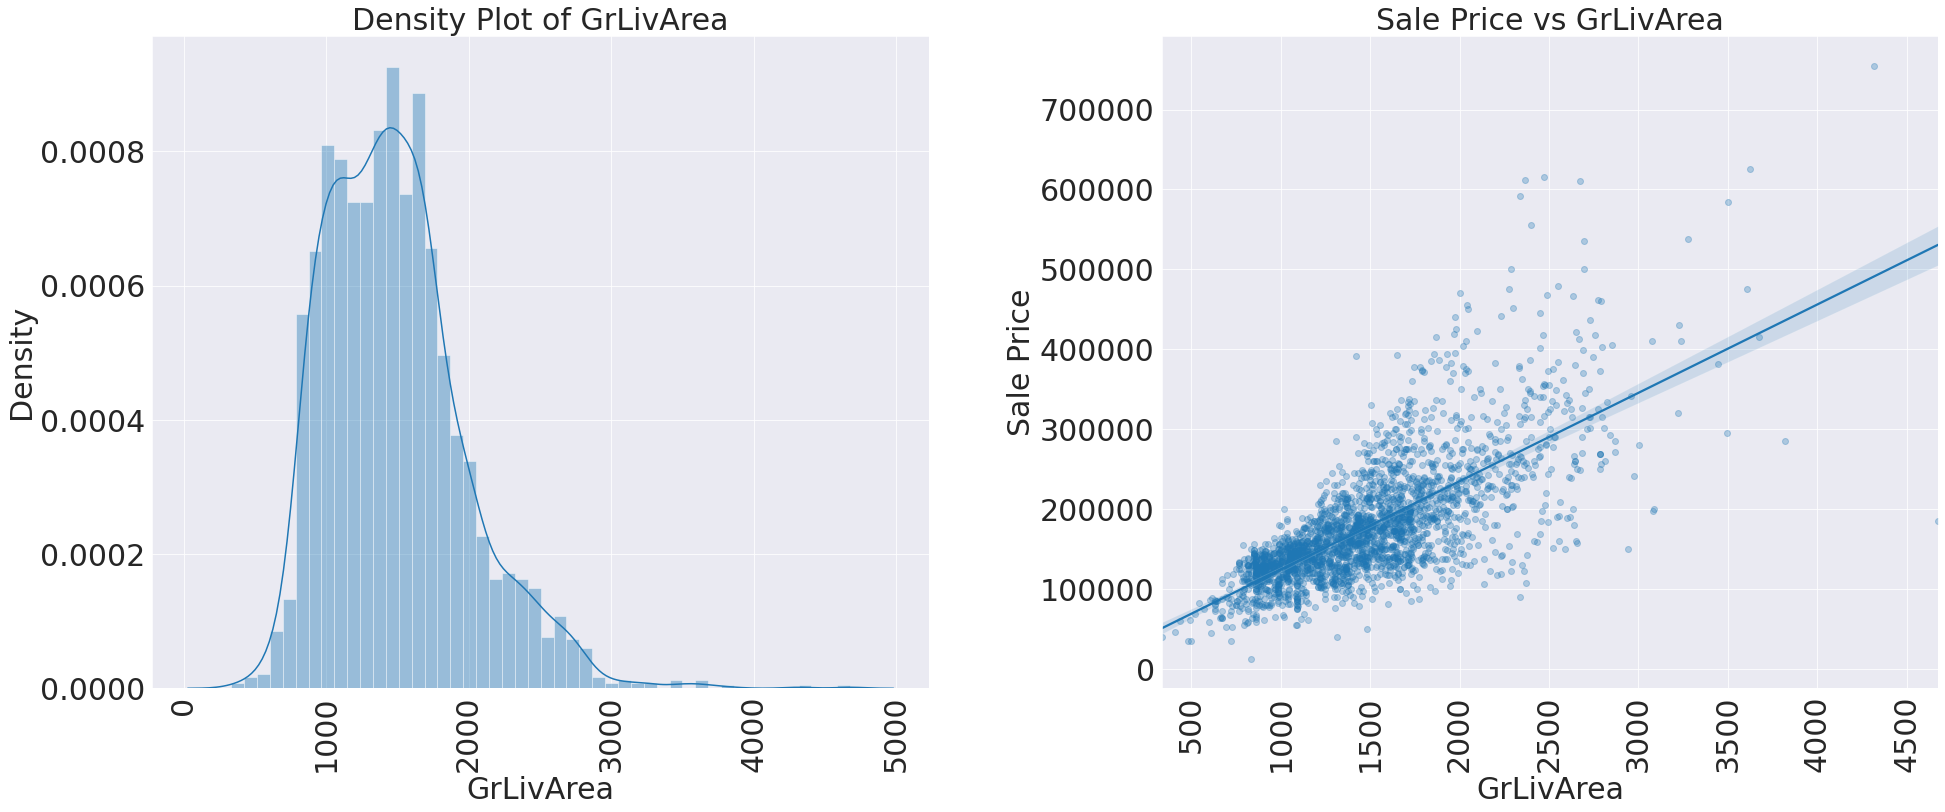

In [17]:
feature_plot(df_raw,"GrLivArea")

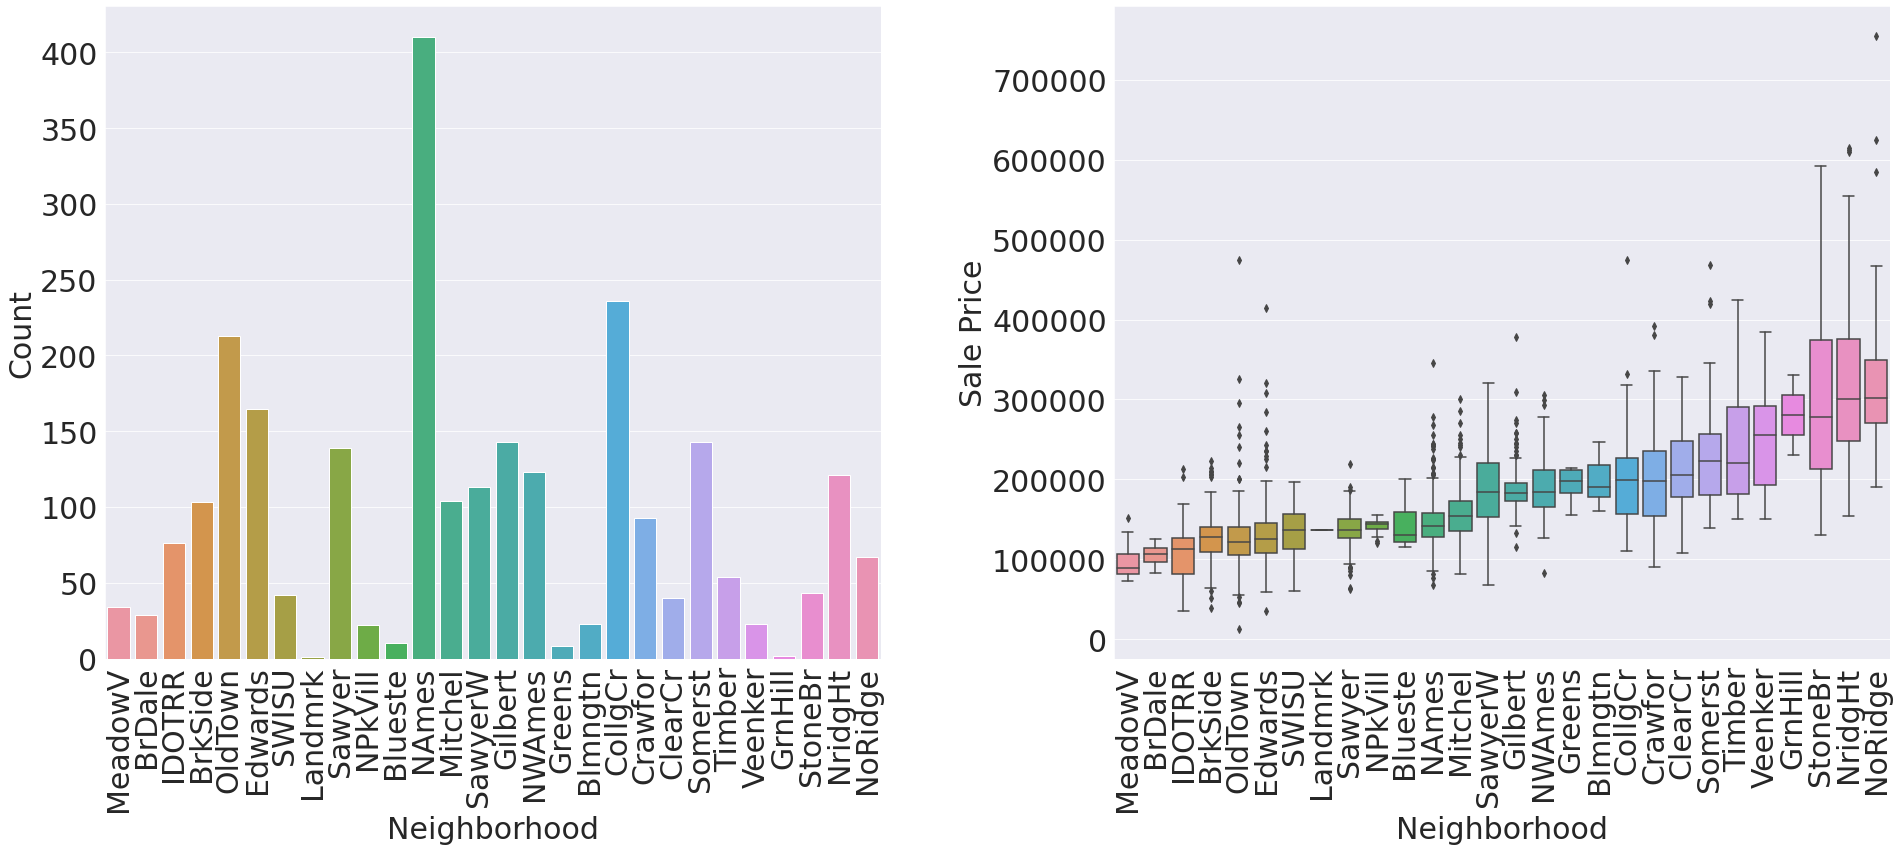

In [18]:
feature_plot(df_raw, "Neighborhood")

In [19]:
df_raw.MSSubClass=df_raw.MSSubClass.astype(str)

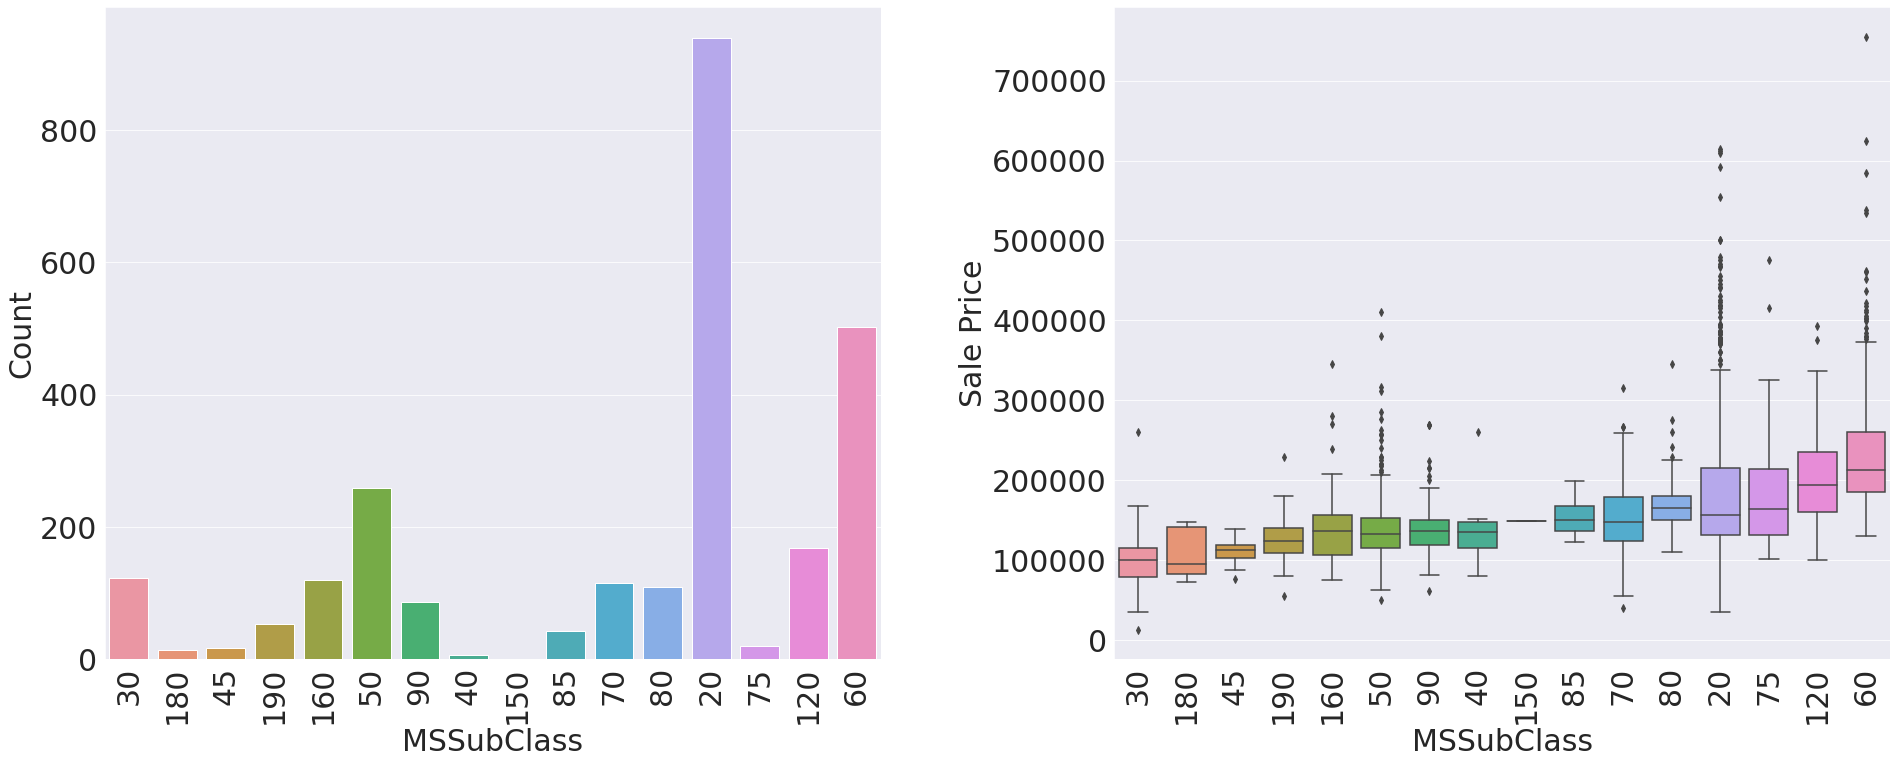

In [20]:
feature_plot(df_raw, "MSSubClass")

In [21]:
df_train.head()

GrLivArea MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1        856         30       RL          NaN     7890   Pave   NaN      Reg   
2       1049        120       RL         42.0     4235   Pave   NaN      Reg   
3       1001         30  C (all)         60.0     6060   Pave   NaN      Reg   
4       1039         70       RL         80.0     8146   Pave   NaN      Reg   
5       1665         60       RL         70.0     8400   Pave   NaN      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
1         Lvl    AllPub    Corner       Gtl        SWISU       Norm   
2         Lvl    AllPub    Inside       Gtl      Edwards       Norm   
3         Lvl    AllPub    Inside       Gtl       IDOTRR       Norm   
4         Lvl    AllPub    Corner       Gtl      OldTown       Norm   
5         Lvl    AllPub    Inside       Gtl       NWAmes       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
1       Norm     1Fam     1Story            6            6       1939   
2       Norm   TwnhsE     1Story            5            5       1984   
3       Norm     1Fam     1Story            5            9       1930   
4       Norm     1Fam     2Story            4            8       1900   
5       Norm     1Fam     2Story            8            6       2001   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
1          1950     Gable  CompShg     Wd Sdng     Wd Sdng       None   
2          1984     Gable  CompShg     HdBoard     HdBoard    BrkFace   
3          2007       Hip  CompShg     MetalSd     MetalSd       None   
4          2003     Gable  CompShg     MetalSd     MetalSd       None   
5          2001     Gable  CompShg     VinylSd     VinylSd       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
1         0.0        TA        TA     CBlock       TA       TA           No   
2       149.0        Gd        TA     CBlock       Gd       TA           Mn   
3         0.0        Gd        TA     BrkTil       TA       TA           No   
4         0.0        Gd        Gd     BrkTil       Fa       TA           No   
5         0.0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
1          Rec       238.0          Unf         0.0      618.0        856.0   
2          GLQ       552.0          ALQ       393.0      104.0       1049.0   
3          ALQ       737.0          Unf         0.0      100.0        837.0   
4          Unf         0.0          Unf         0.0      405.0        405.0   
5          GLQ       643.0          Unf         0.0      167.0        810.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
1    GasA        TA          Y      SBrkr       856         0             0   
2    GasA        TA          Y      SBrkr      1049         0             0   
3    GasA        Ex          Y      SBrkr      1001         0             0   
4    GasA        Gd          Y      SBrkr       717       322             0   
5    GasA        Ex          Y      SBrkr       810       855             0   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
1           1.0           0.0         1         0             2             1   
2           1.0           0.0         2         0             2             1   
3           0.0           0.0         1         0             2             1   
4           0.0           0.0         1         0             2             1   
5           1.0           0.0         2         1             3             1   

  KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  \
1          TA             4        Typ           1          Gd     Detchd   
2          Gd             5        Typ           0         NaN     Attchd   
3          Gd             5        Typ           0         NaN     Detchd 

### How does each numerical feature correlate to the Sale Price?

In [22]:
top_corr_features=df_train.corrwith(df_train["SalePrice"]).sort_values(ascending=False)
top_corr_features

KeyError: 'SalePrice'

# (Top 10) features which correlate to the Sale Price

In [ ]:
for feature in top_corr_features.index:
    if feature=="SalePrice":
        continue
    feature_plot(df_raw, feature)

# Visualization of Sale Price vs categorical features

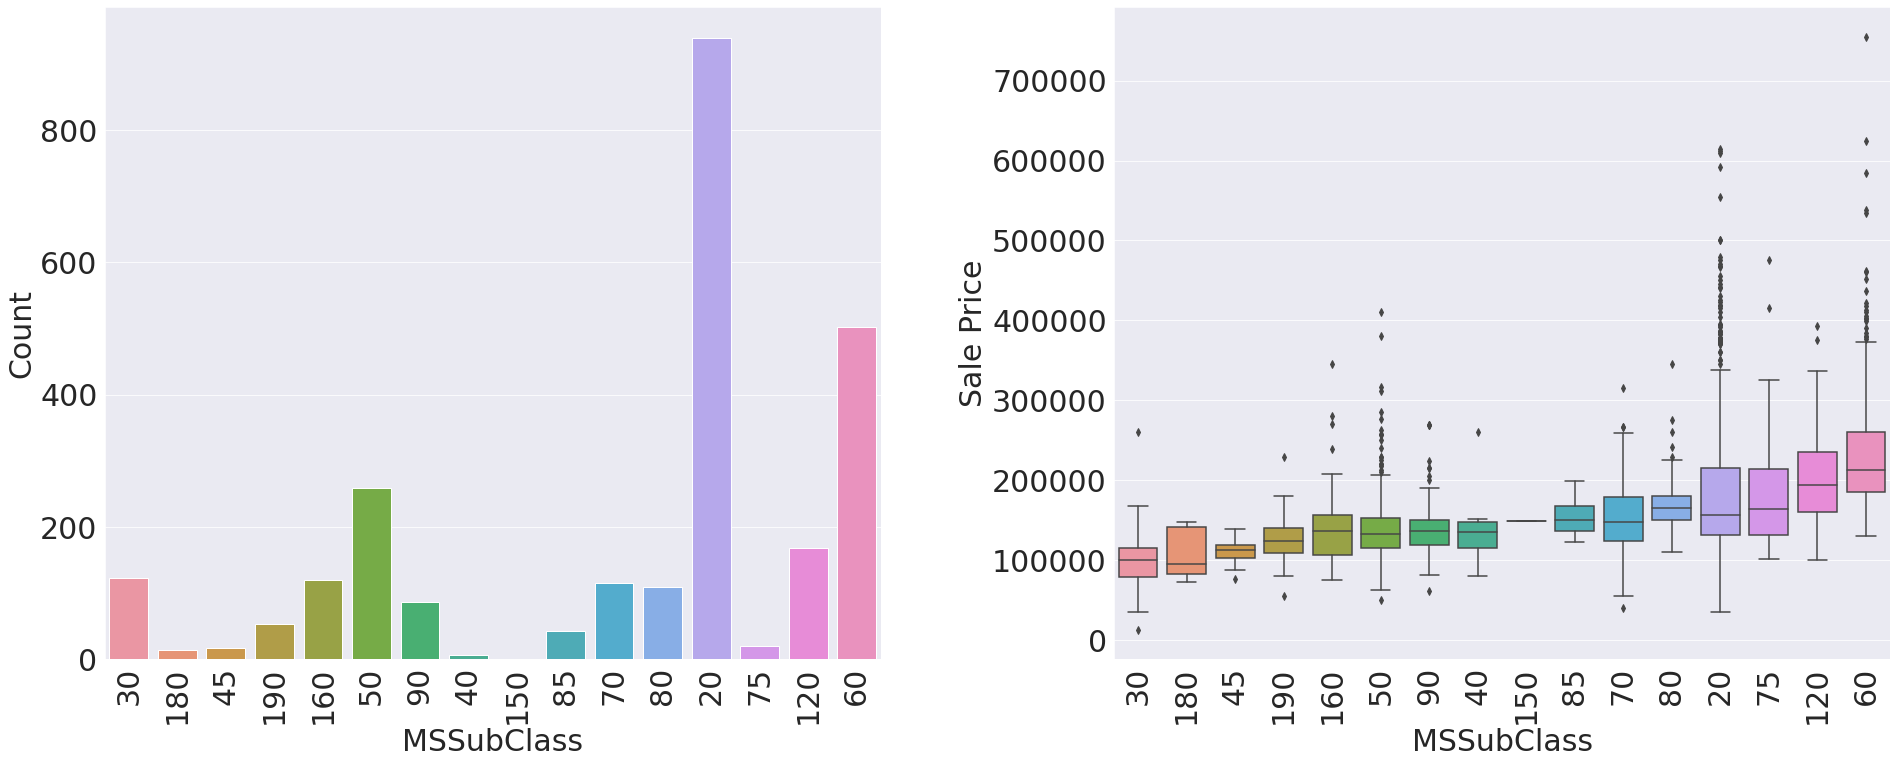

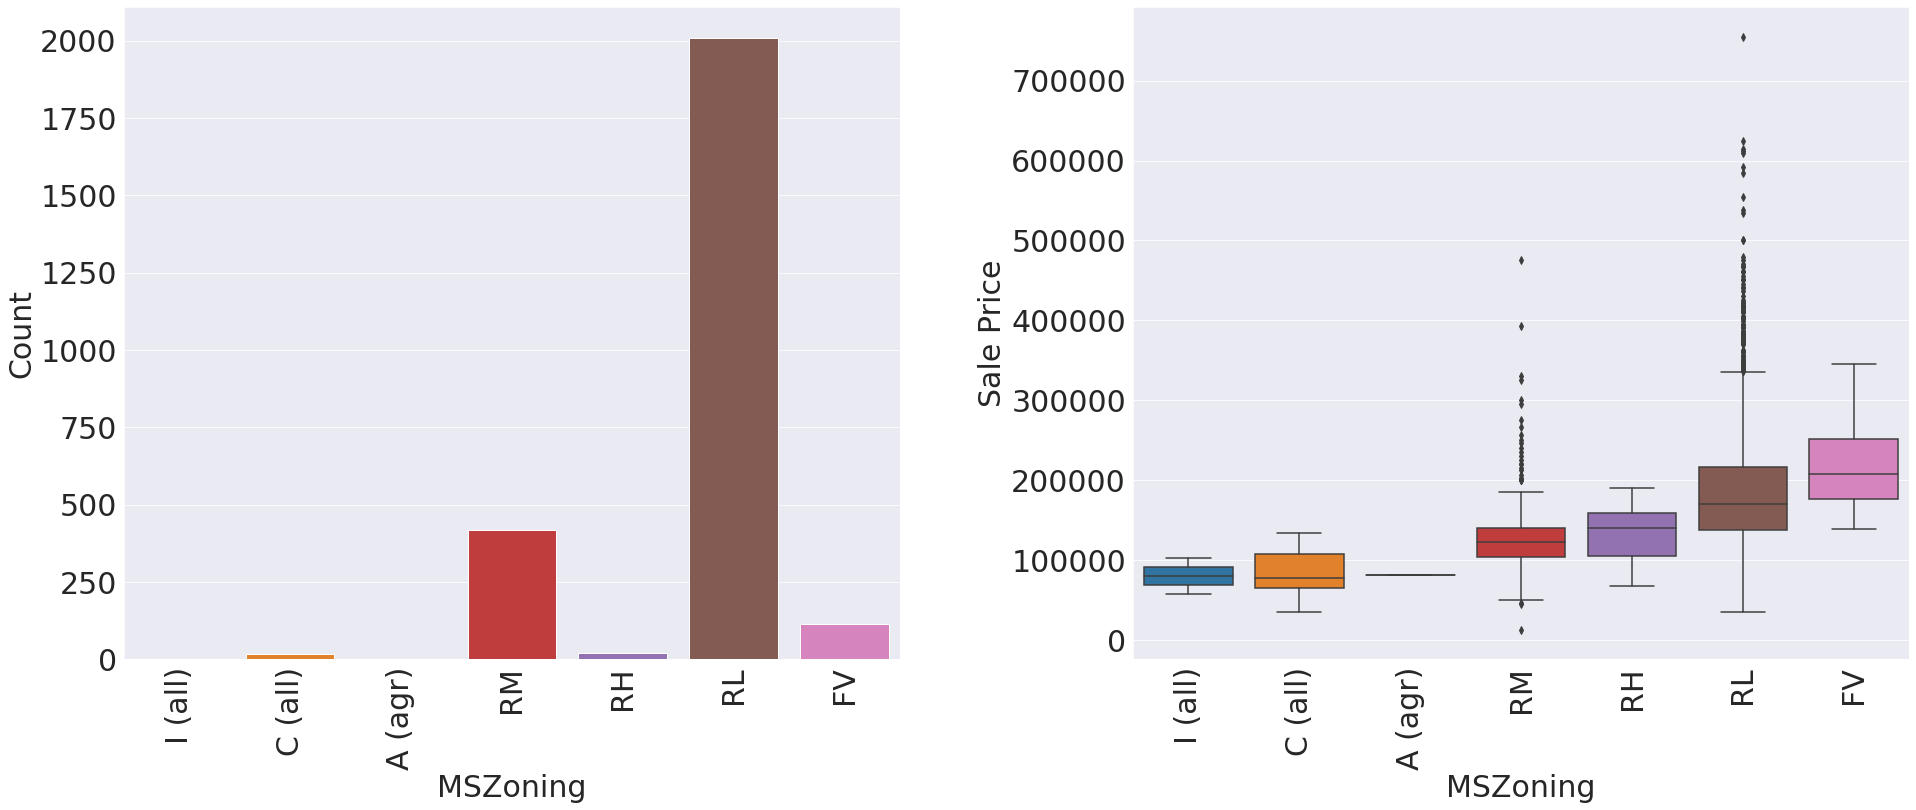

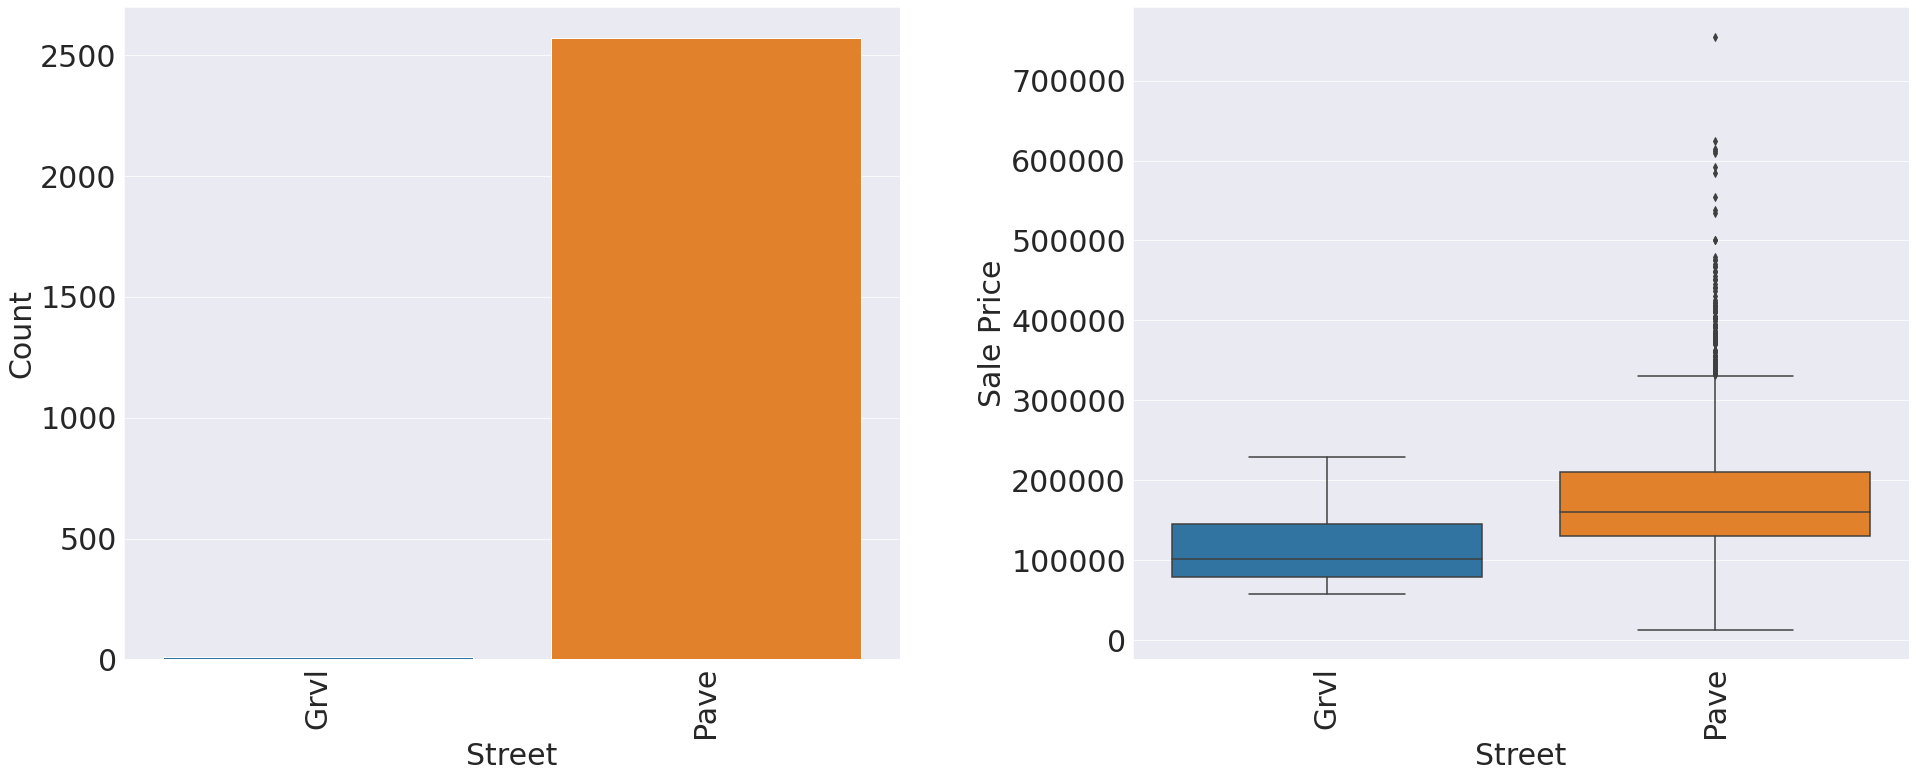

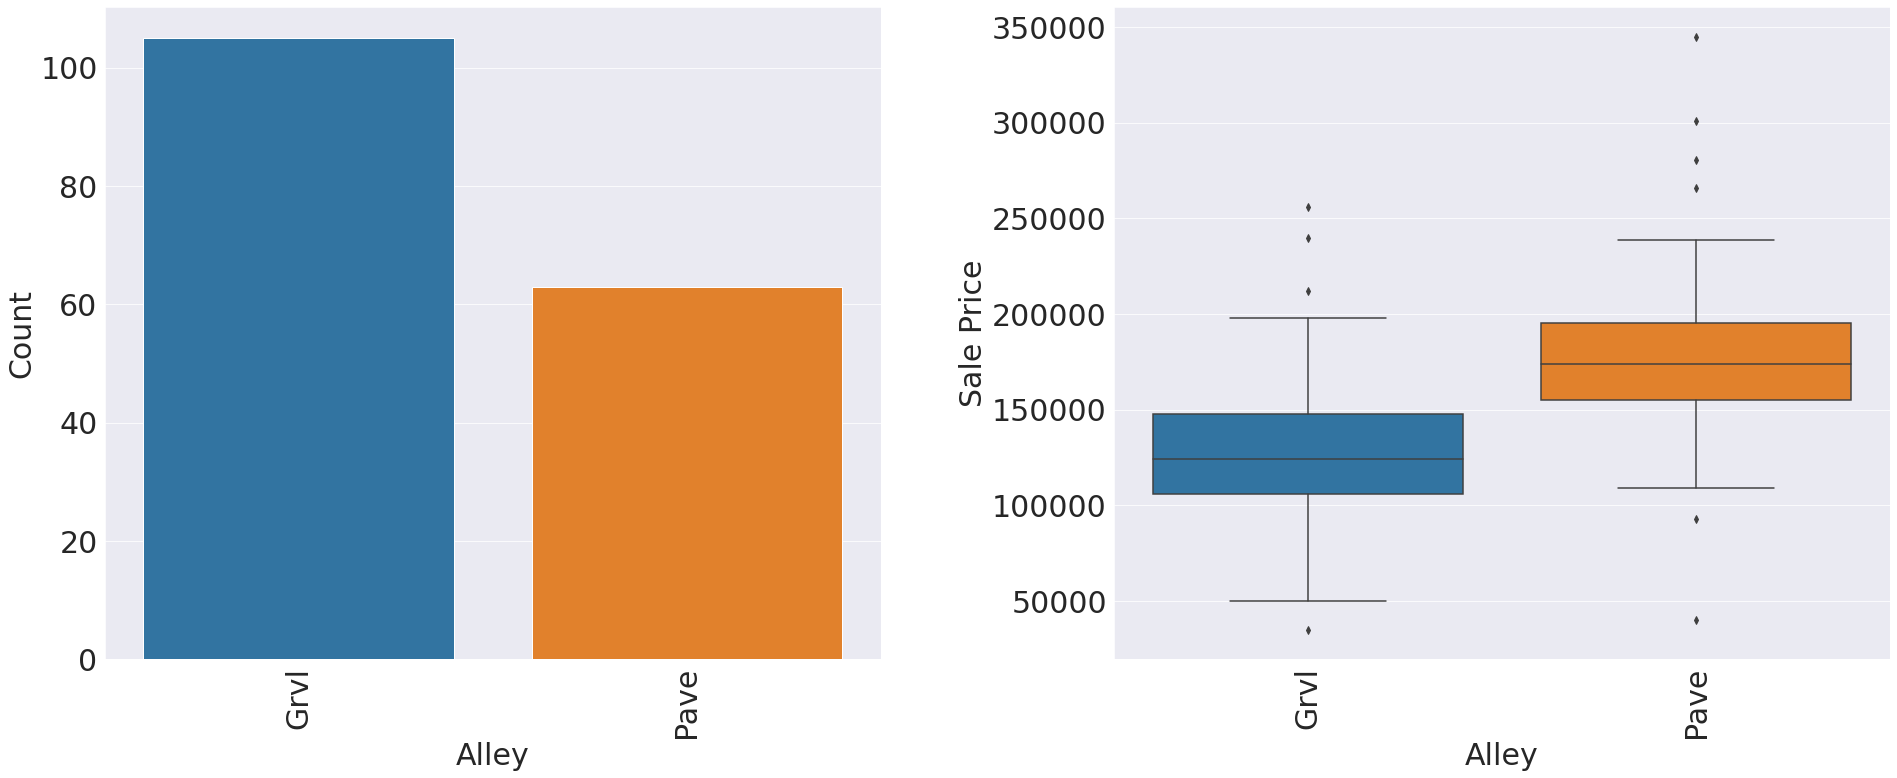

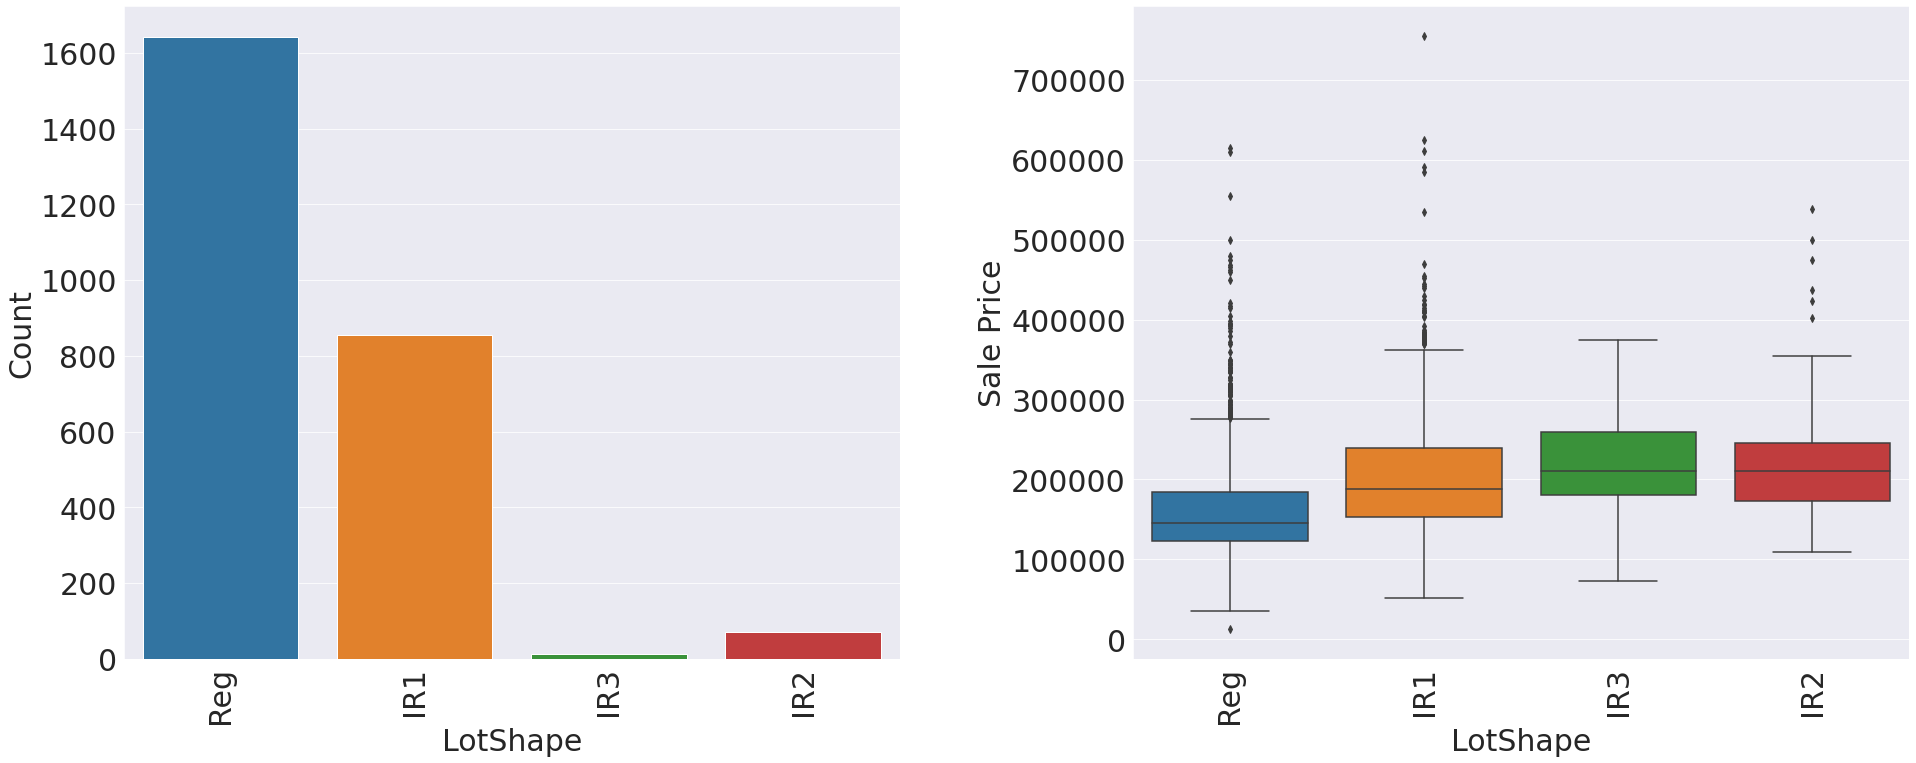

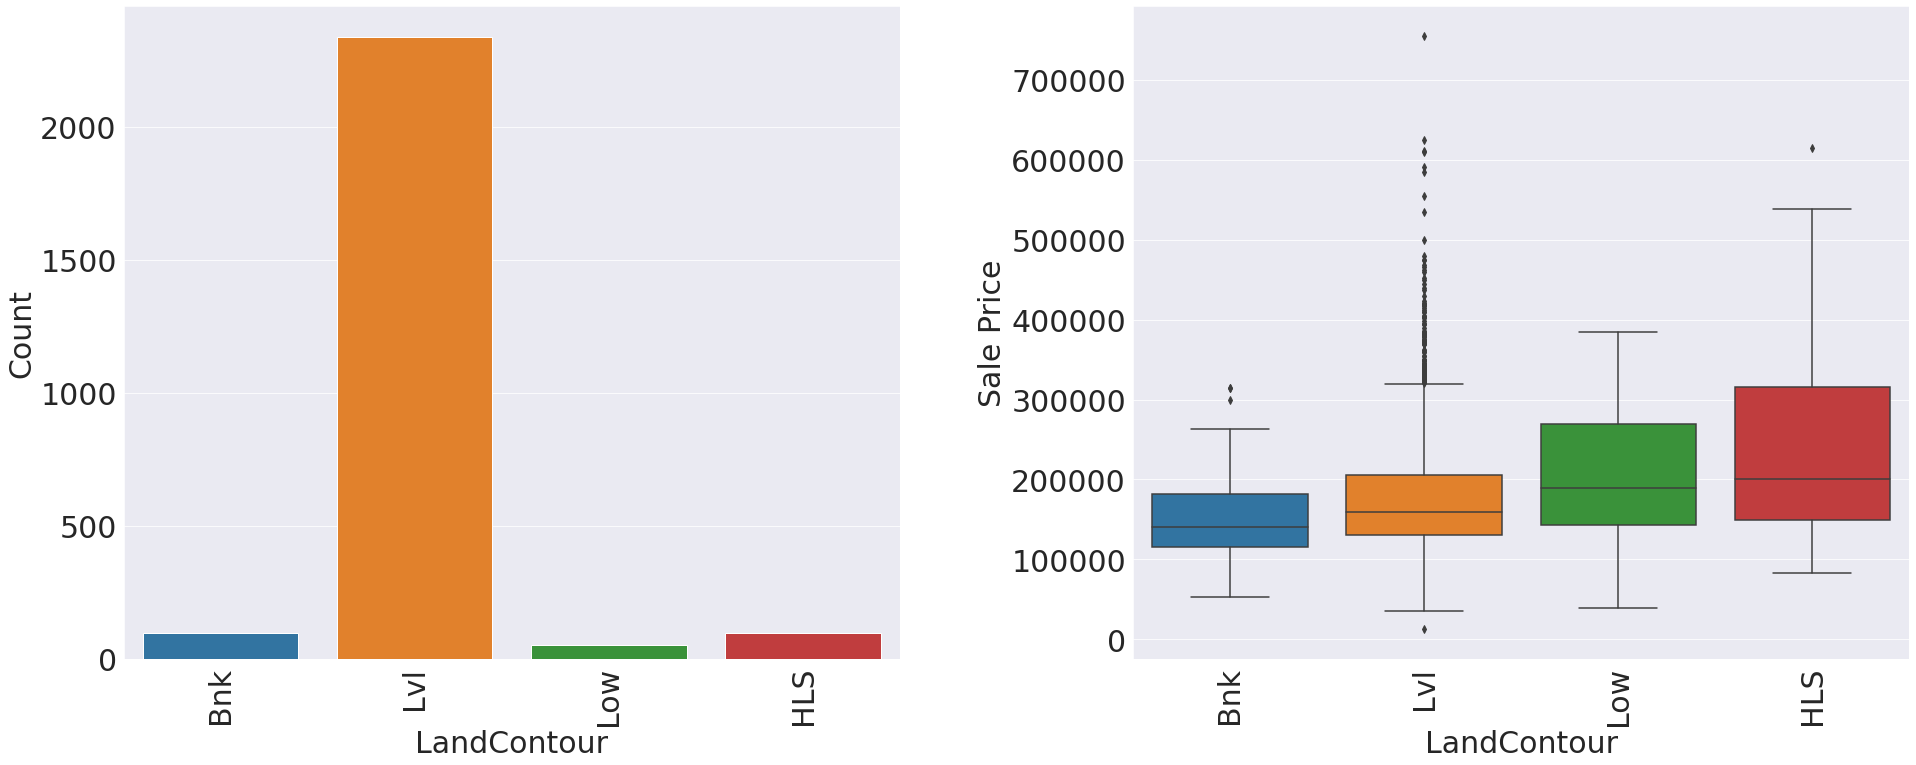

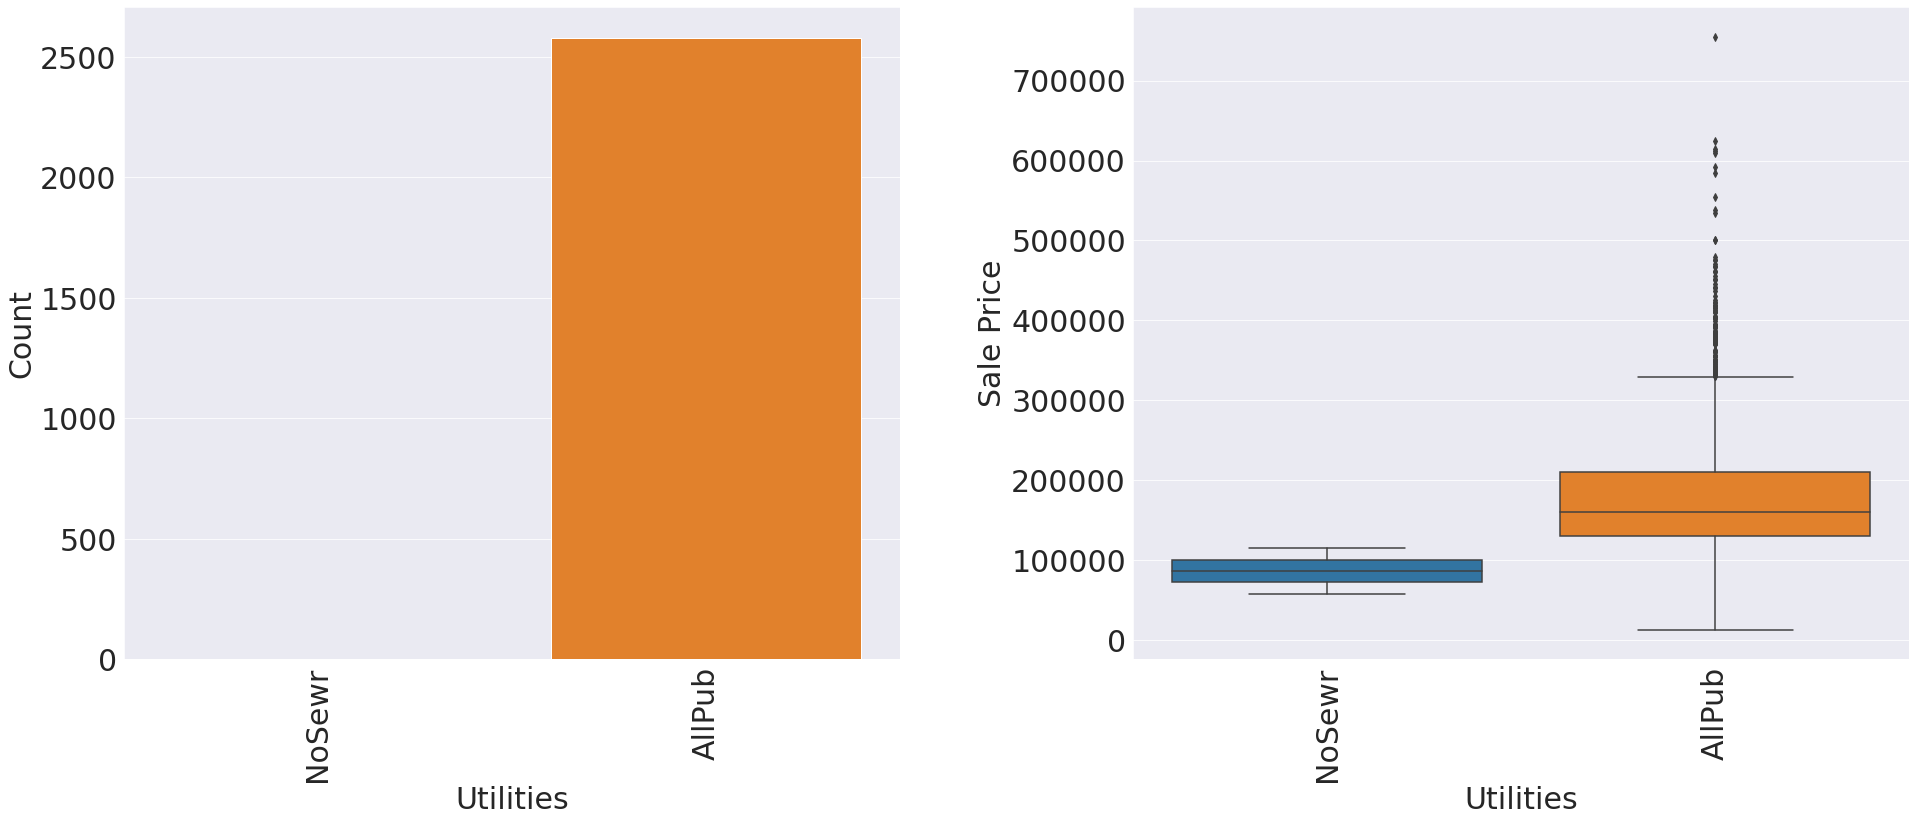

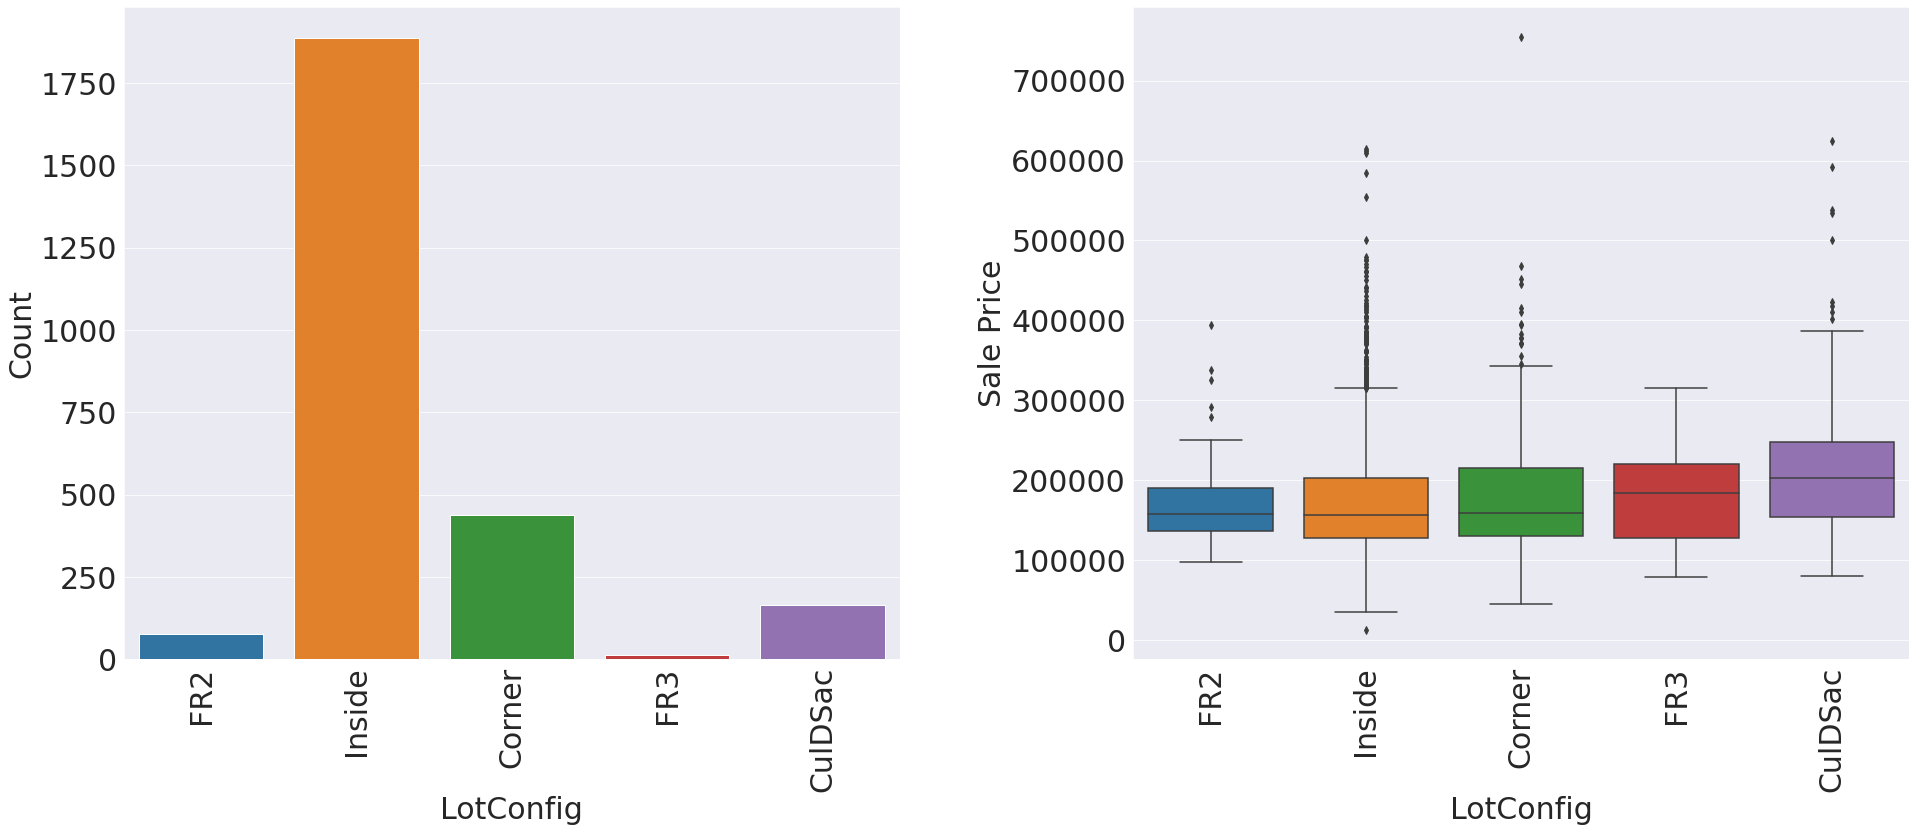

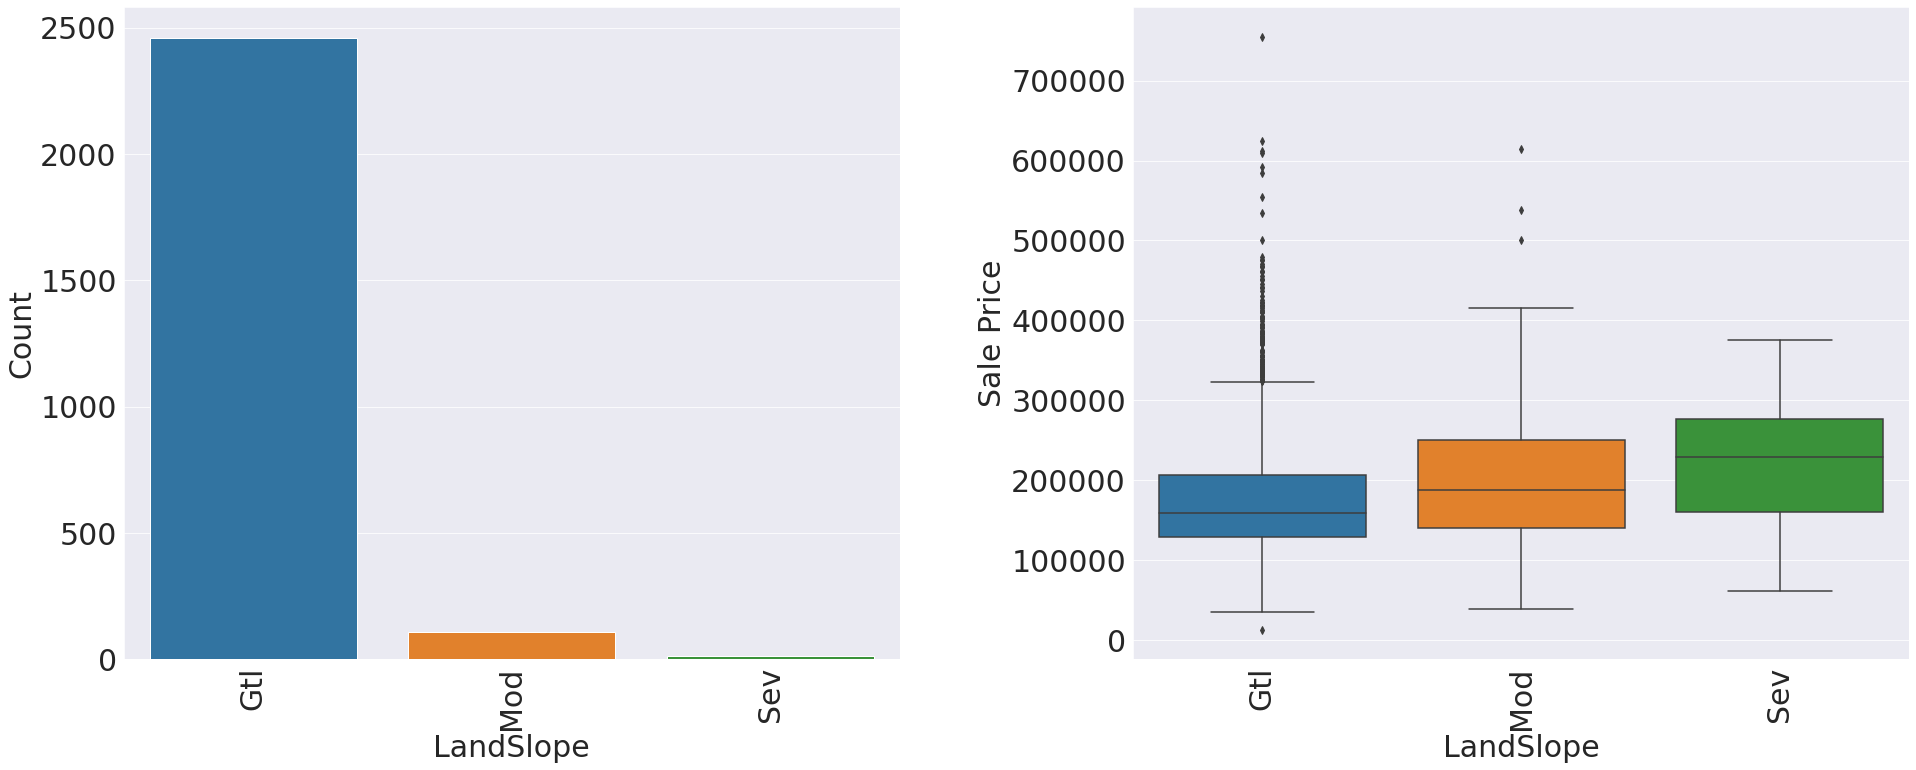

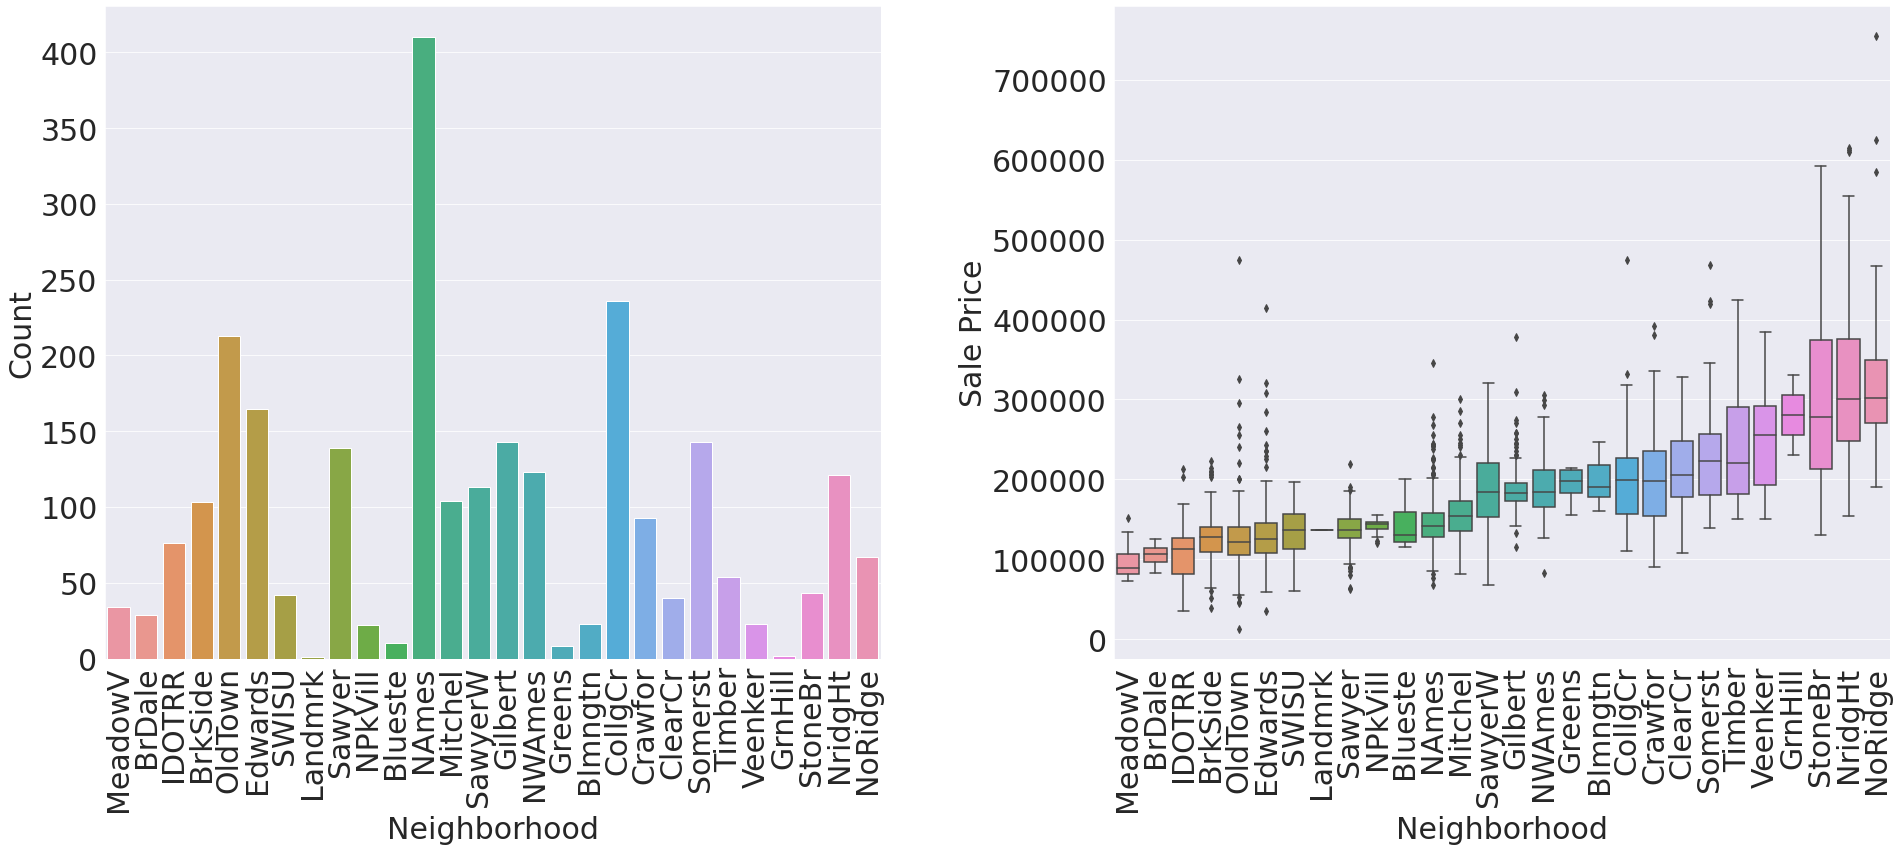

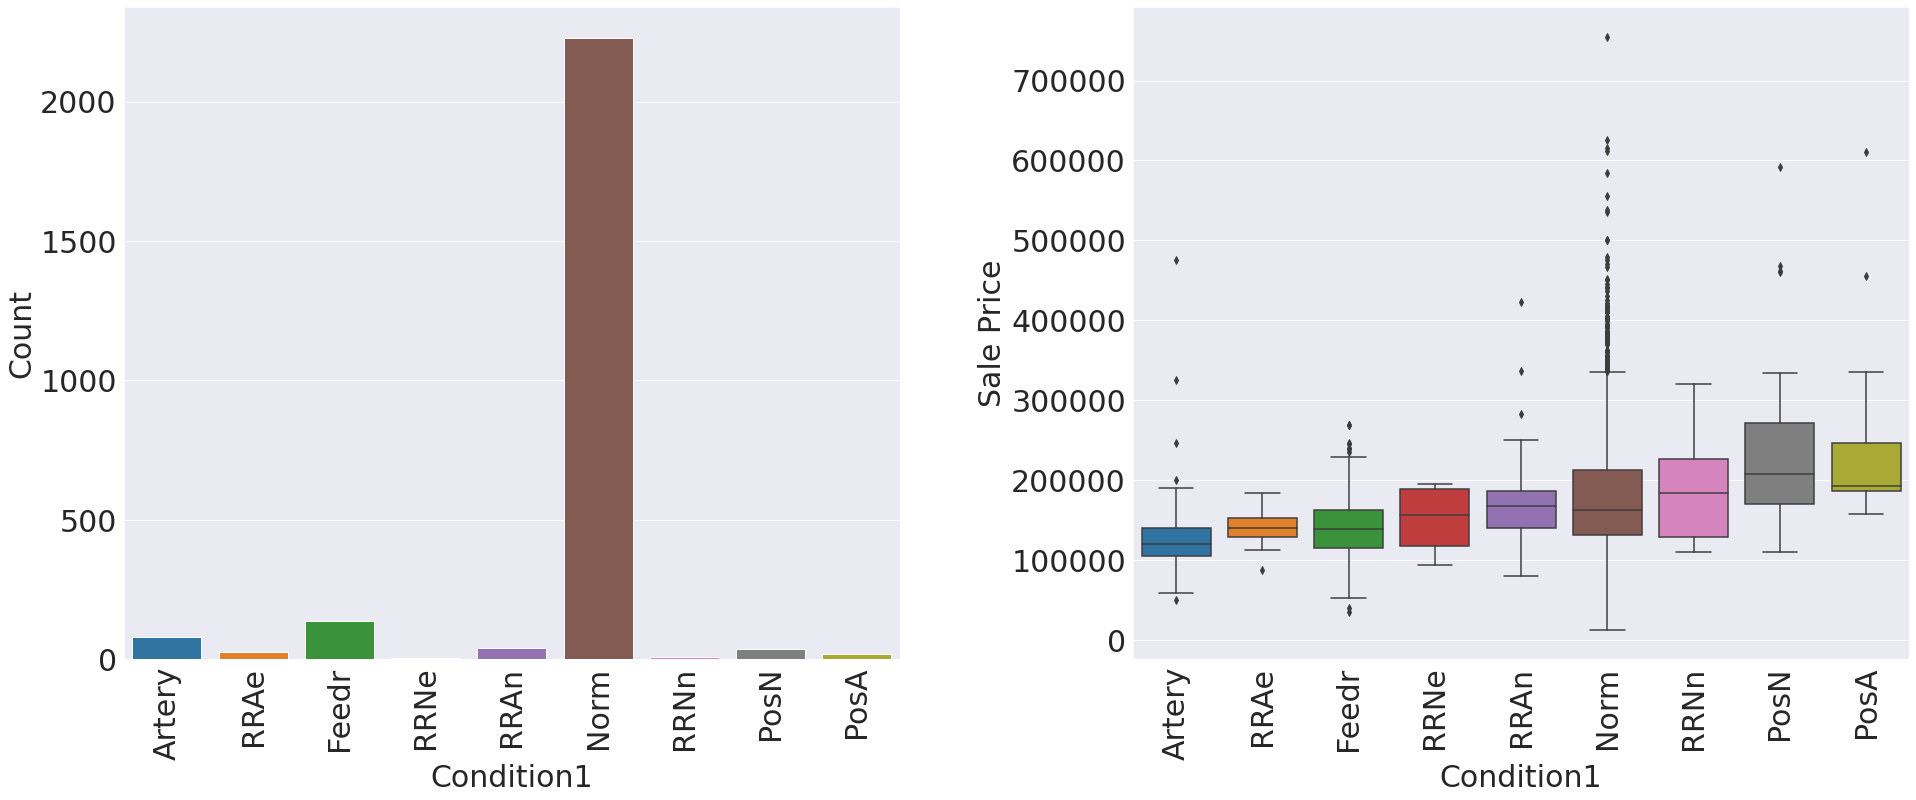

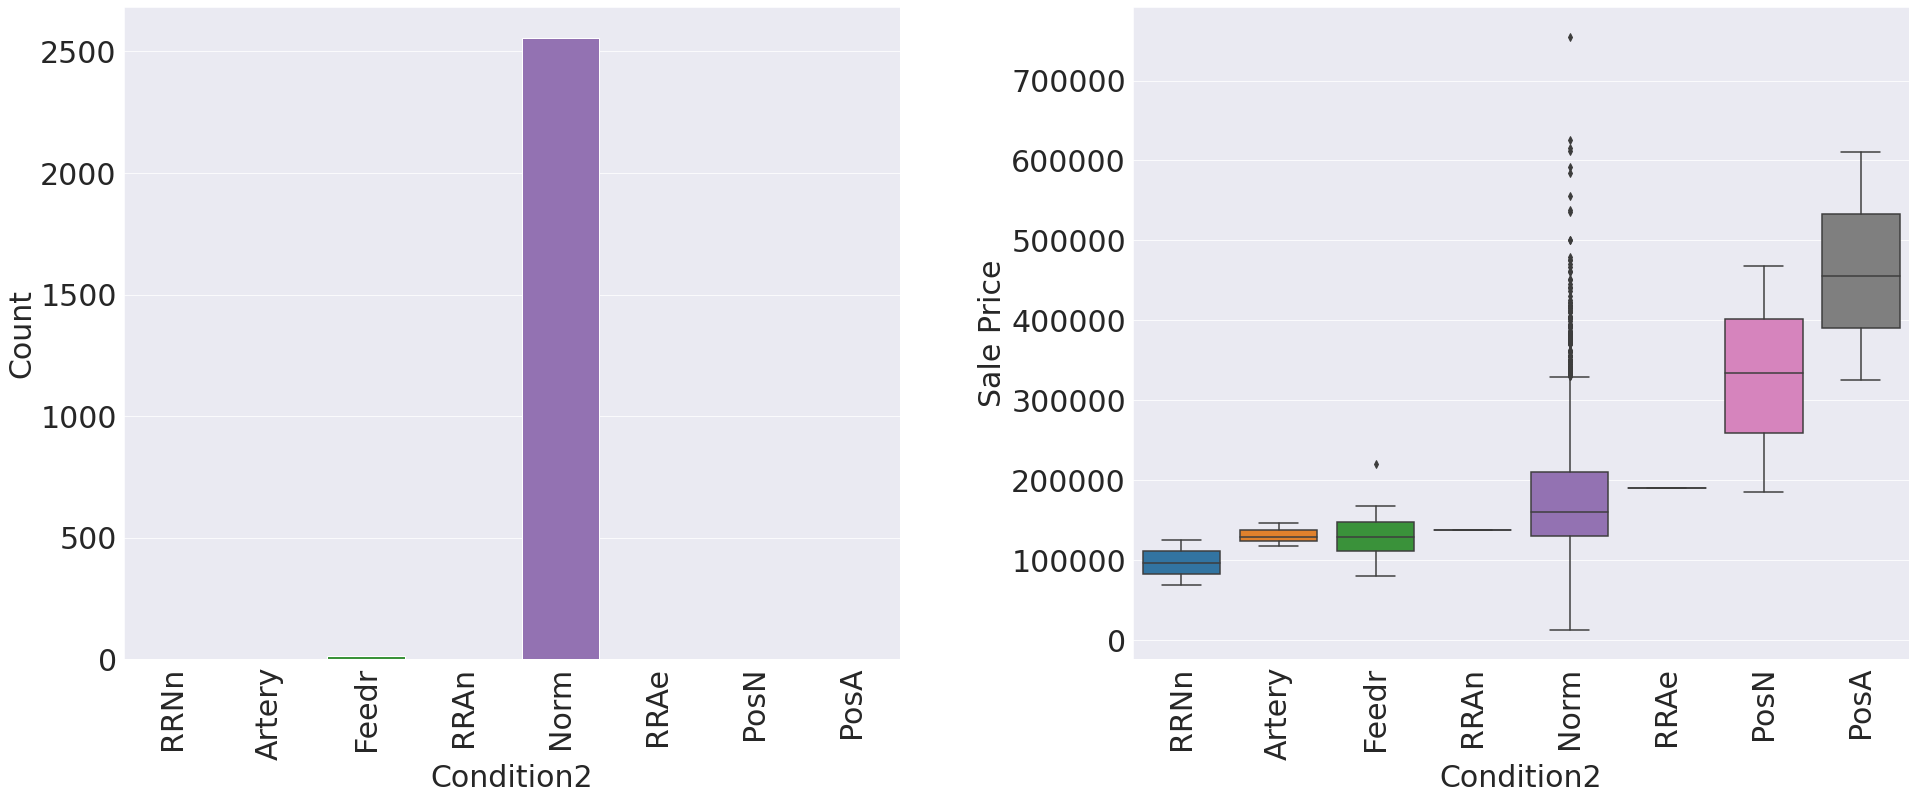

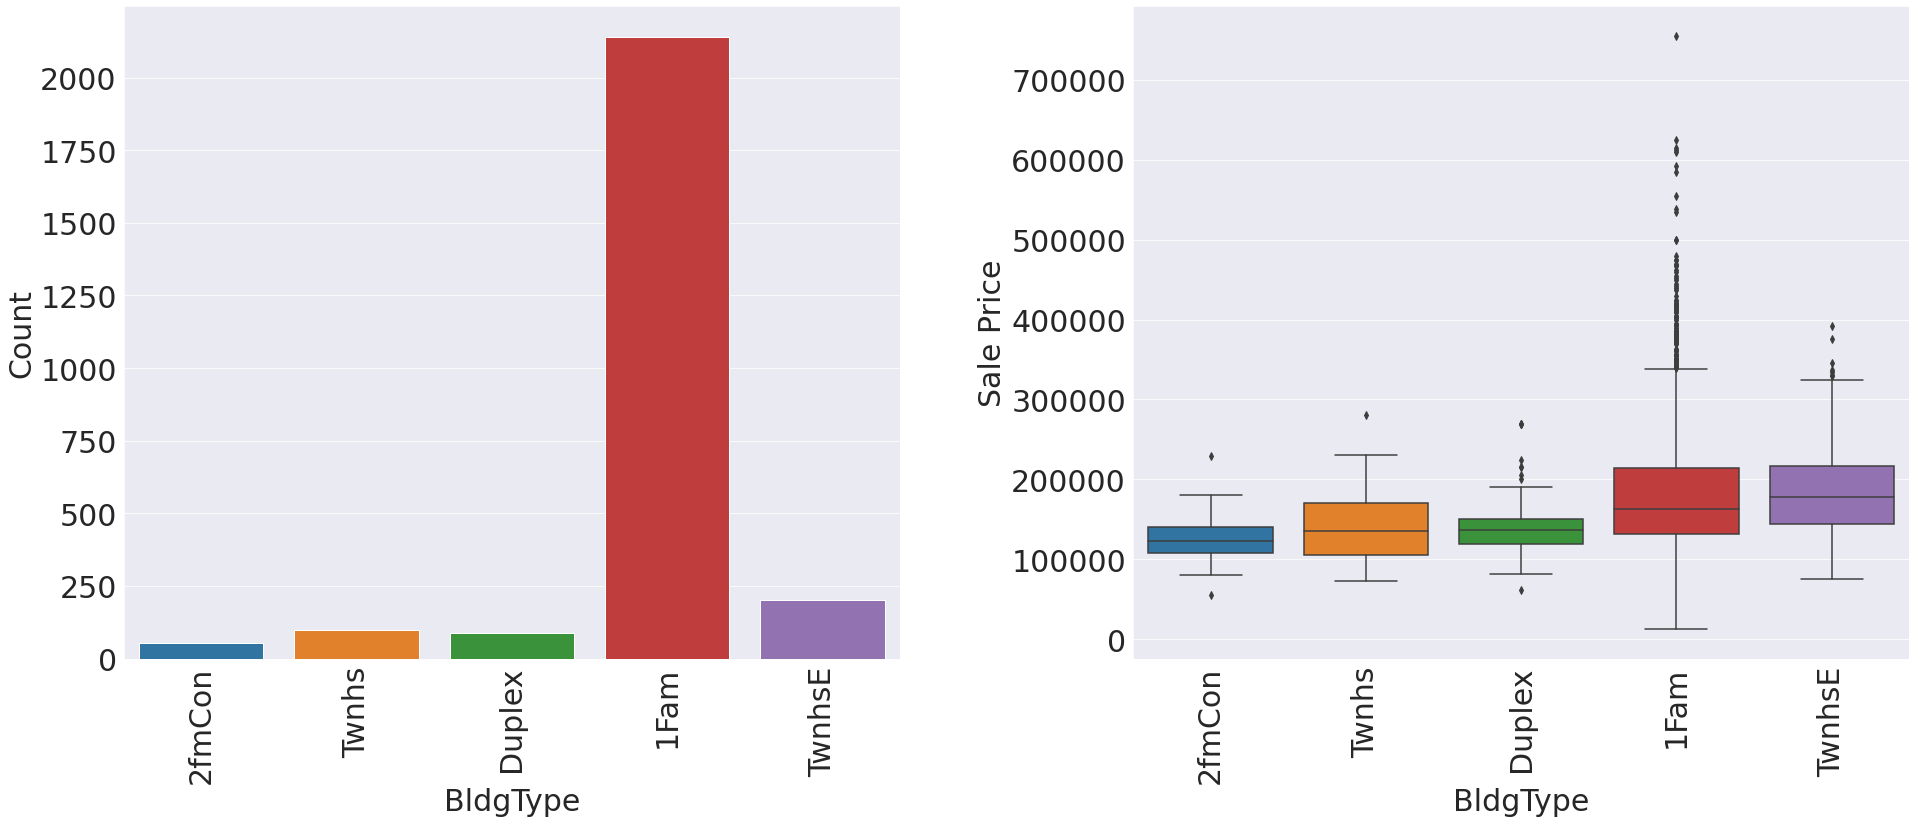

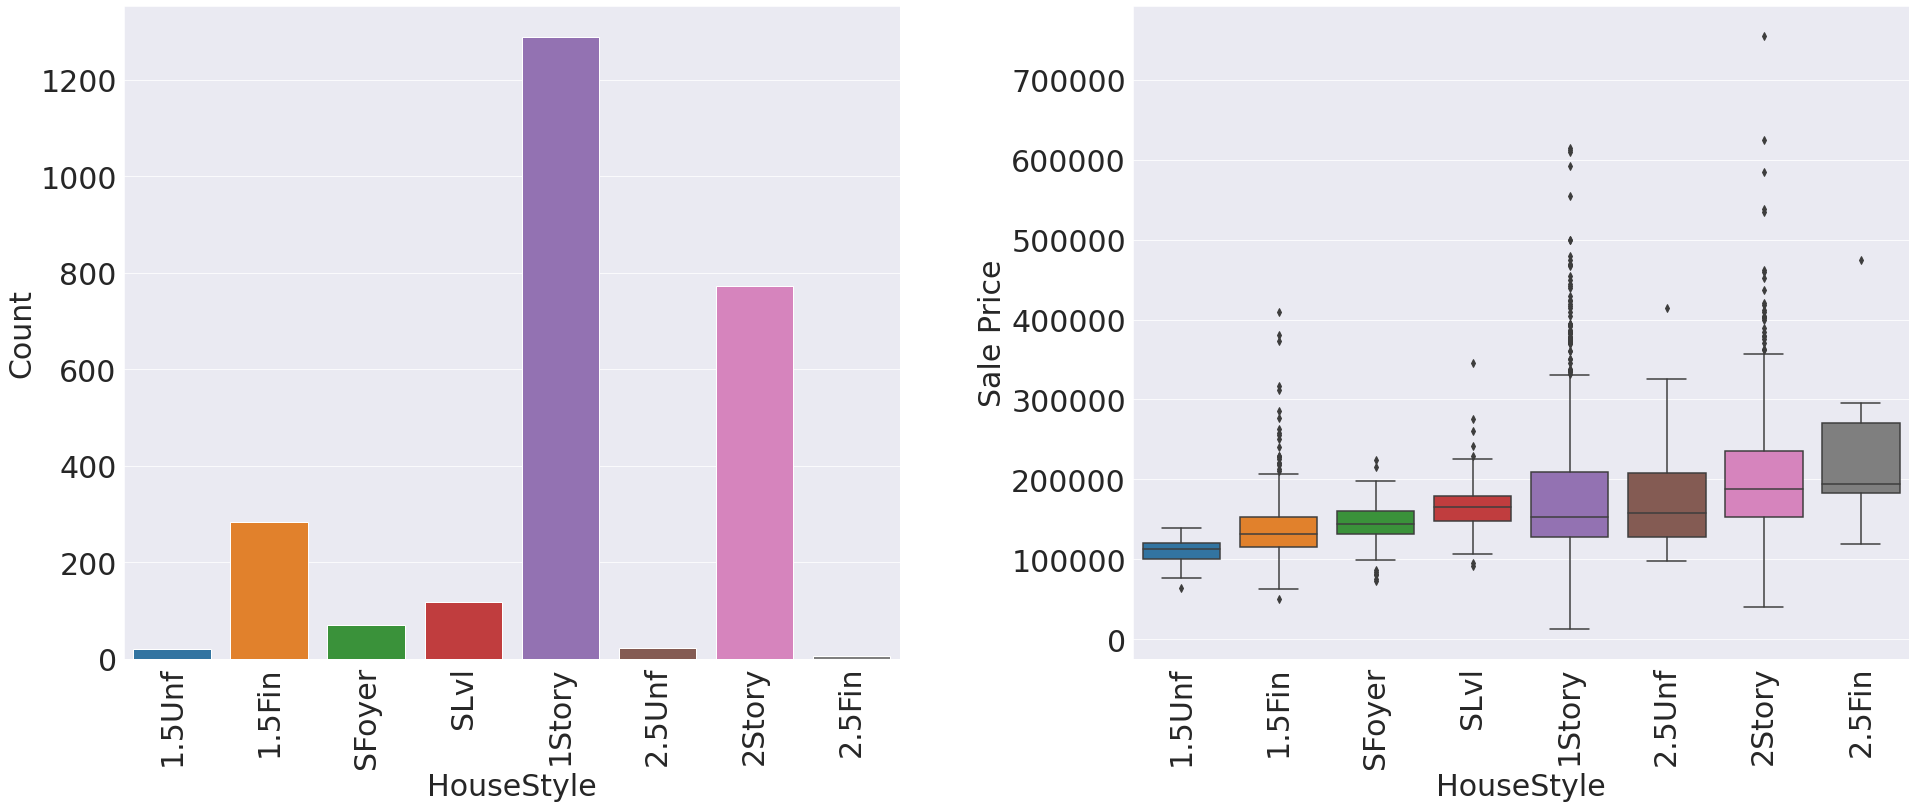

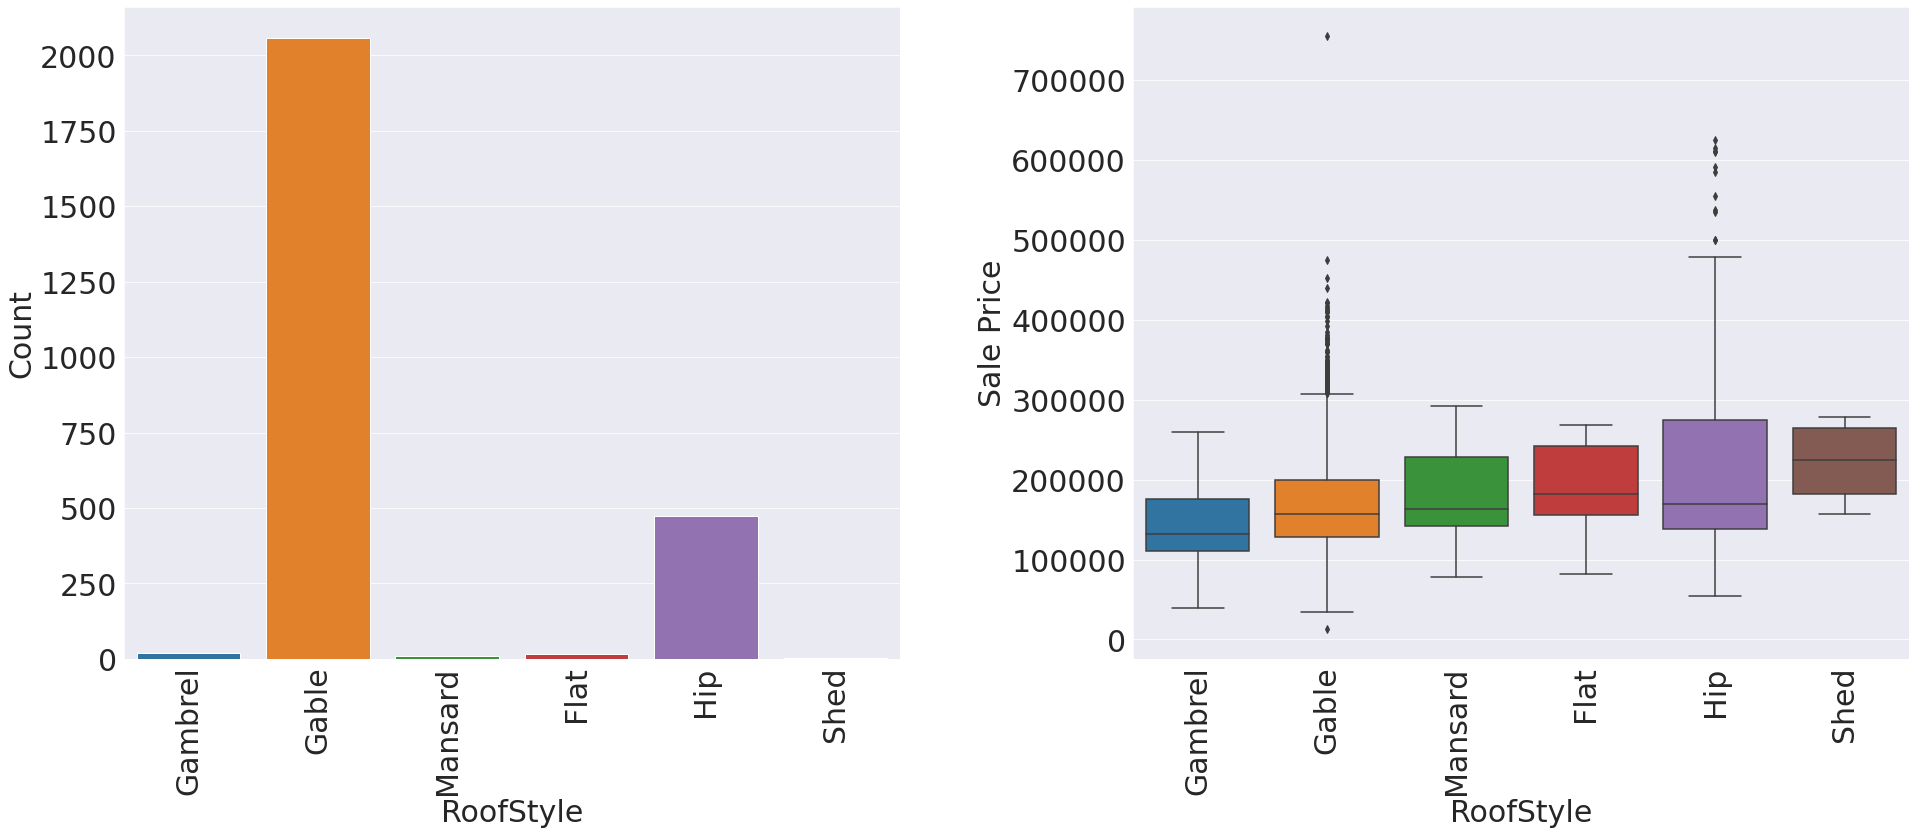

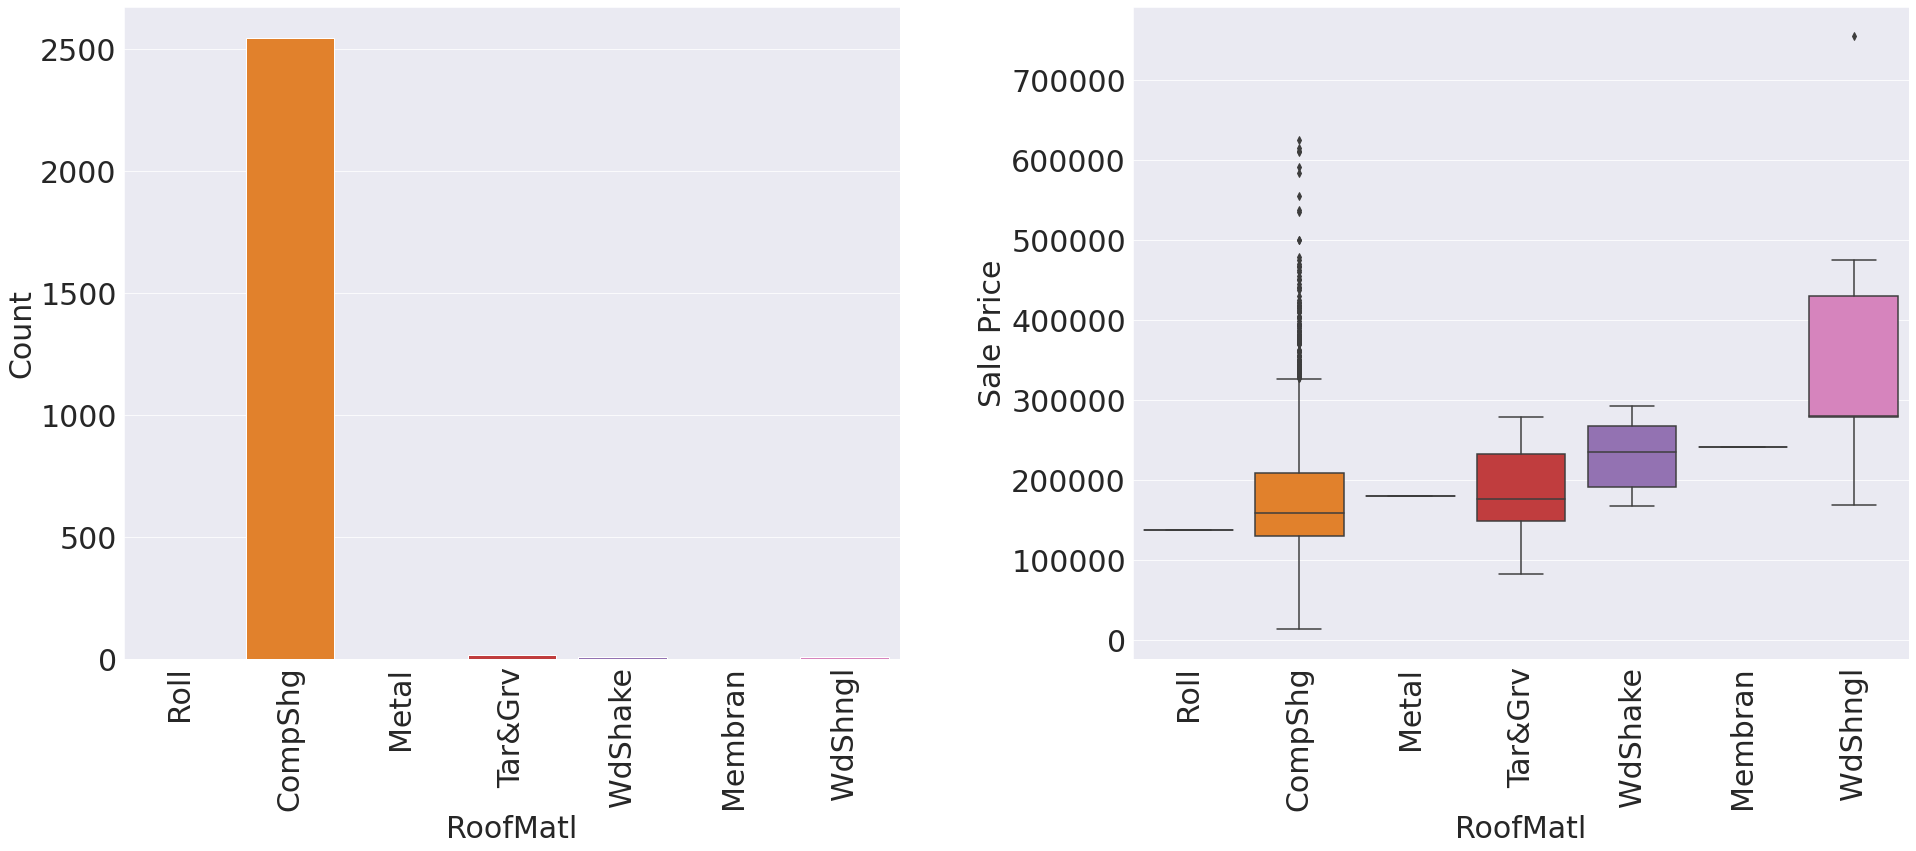

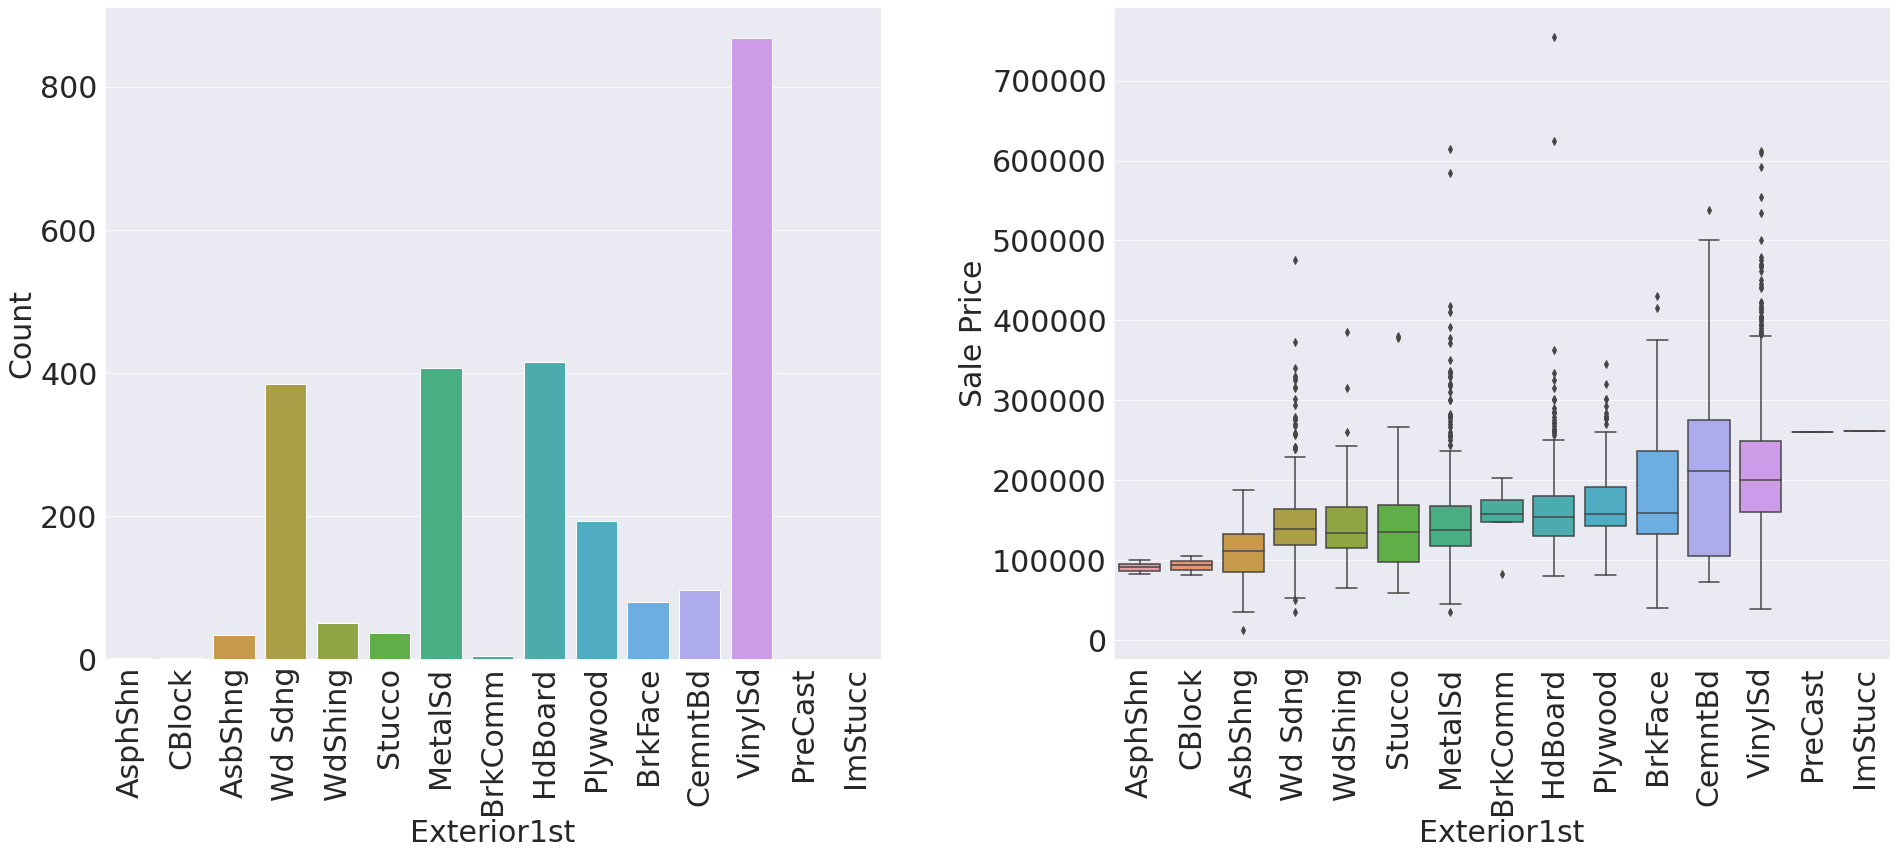

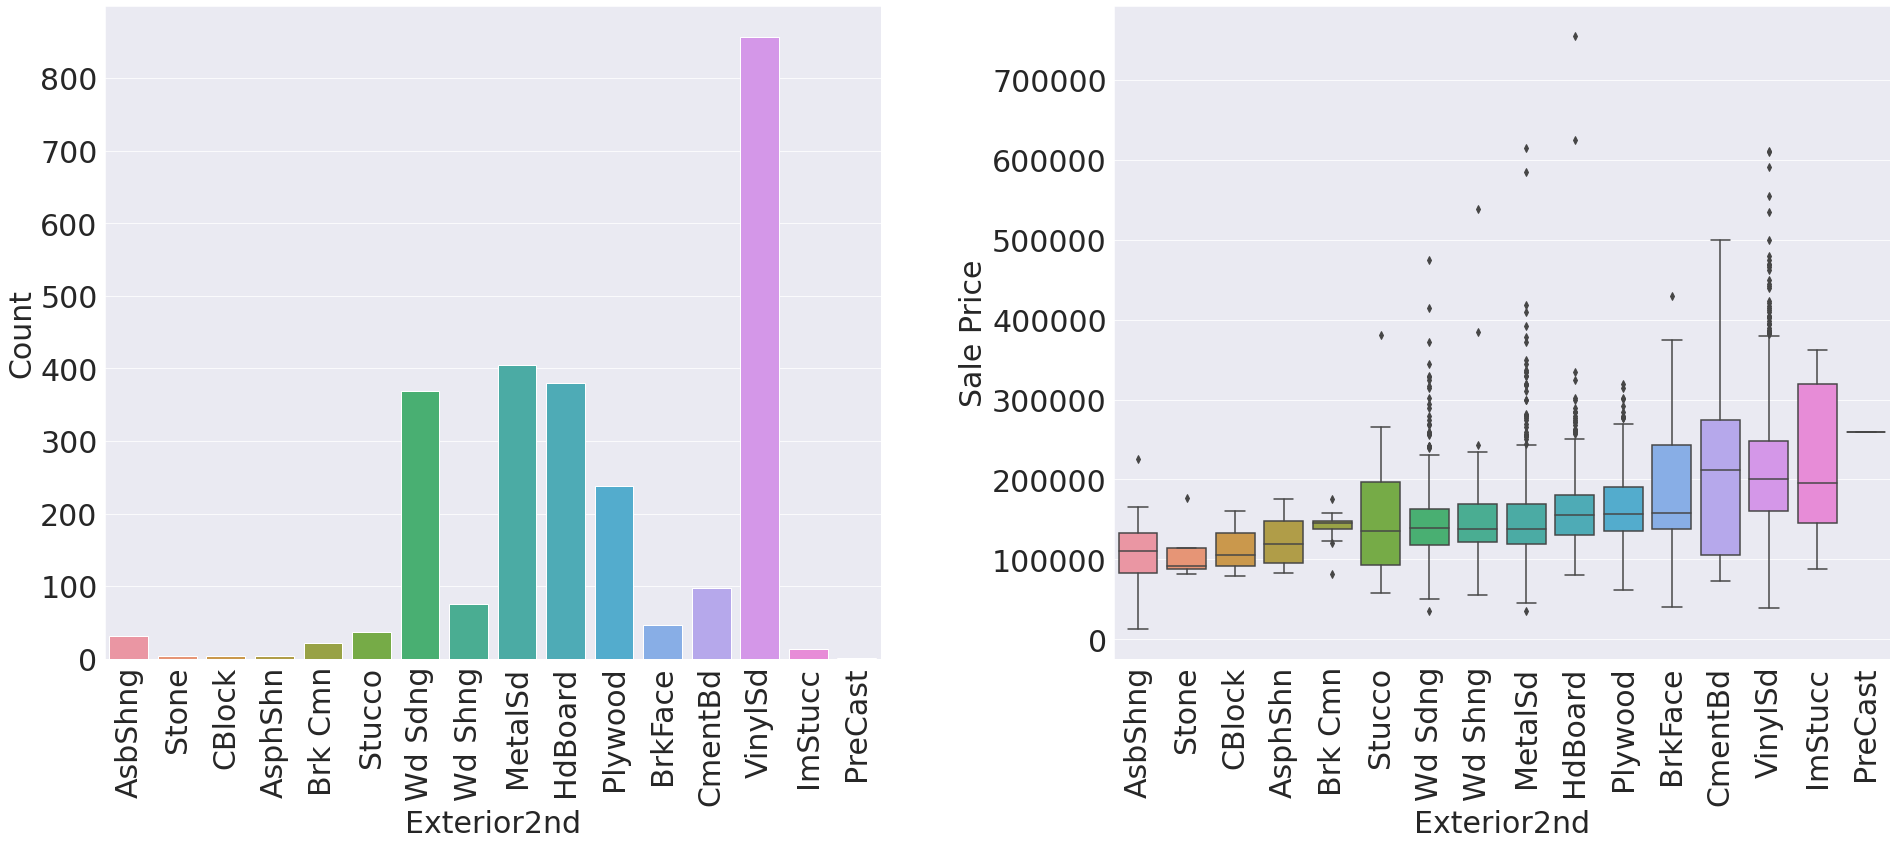

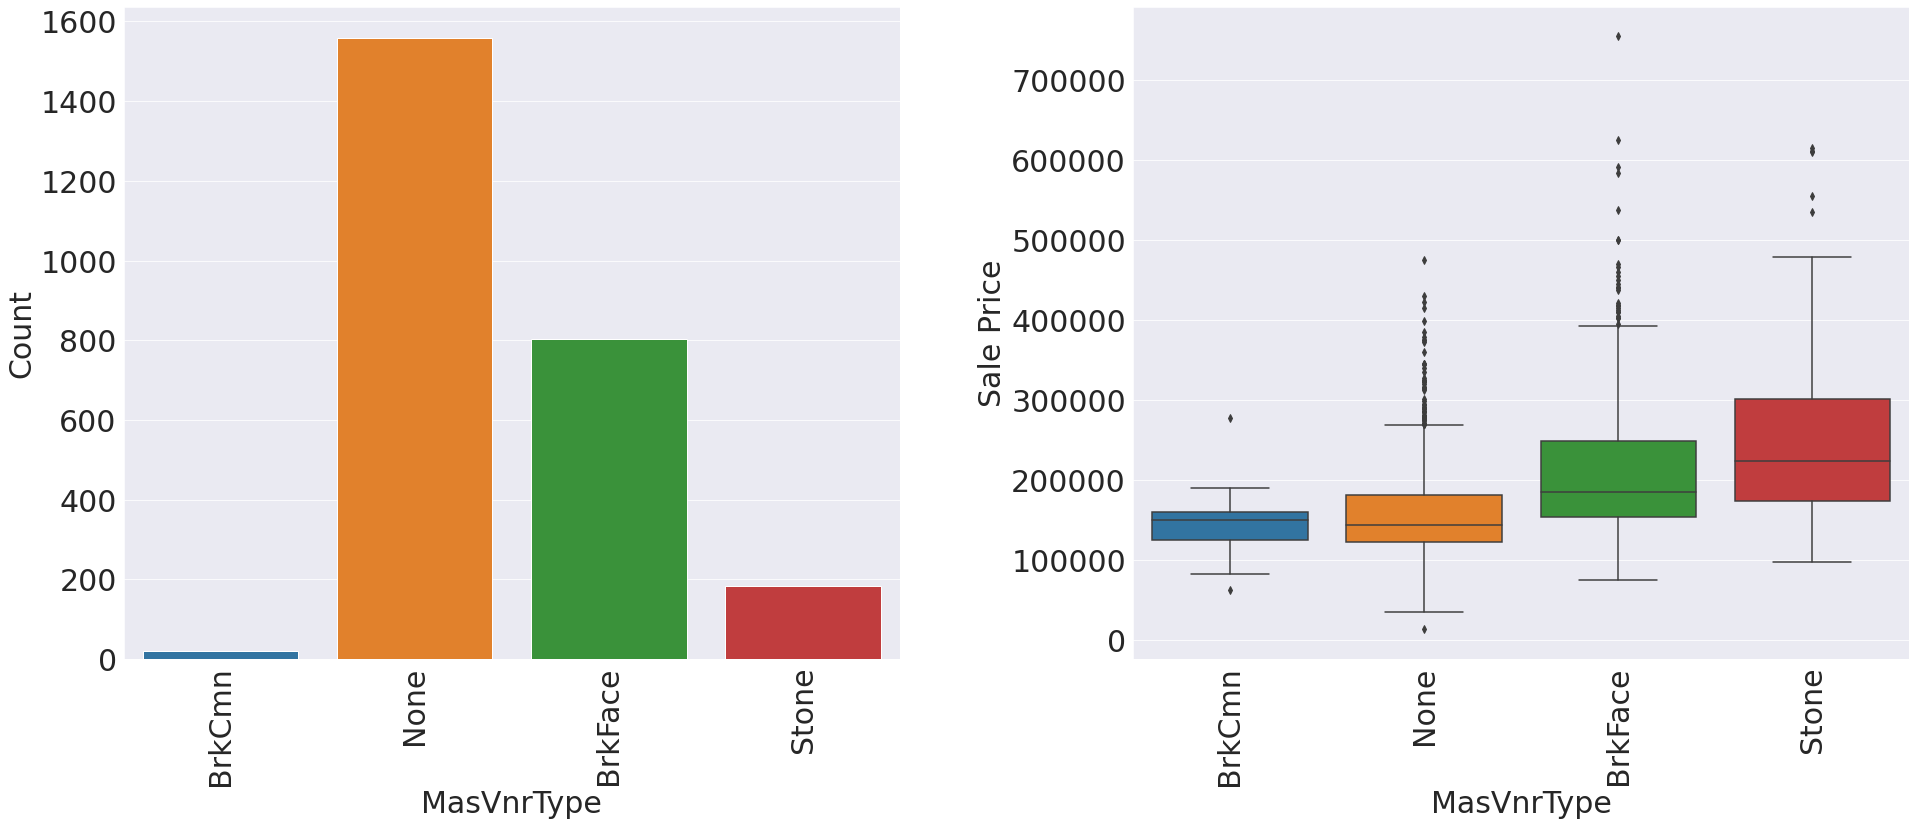

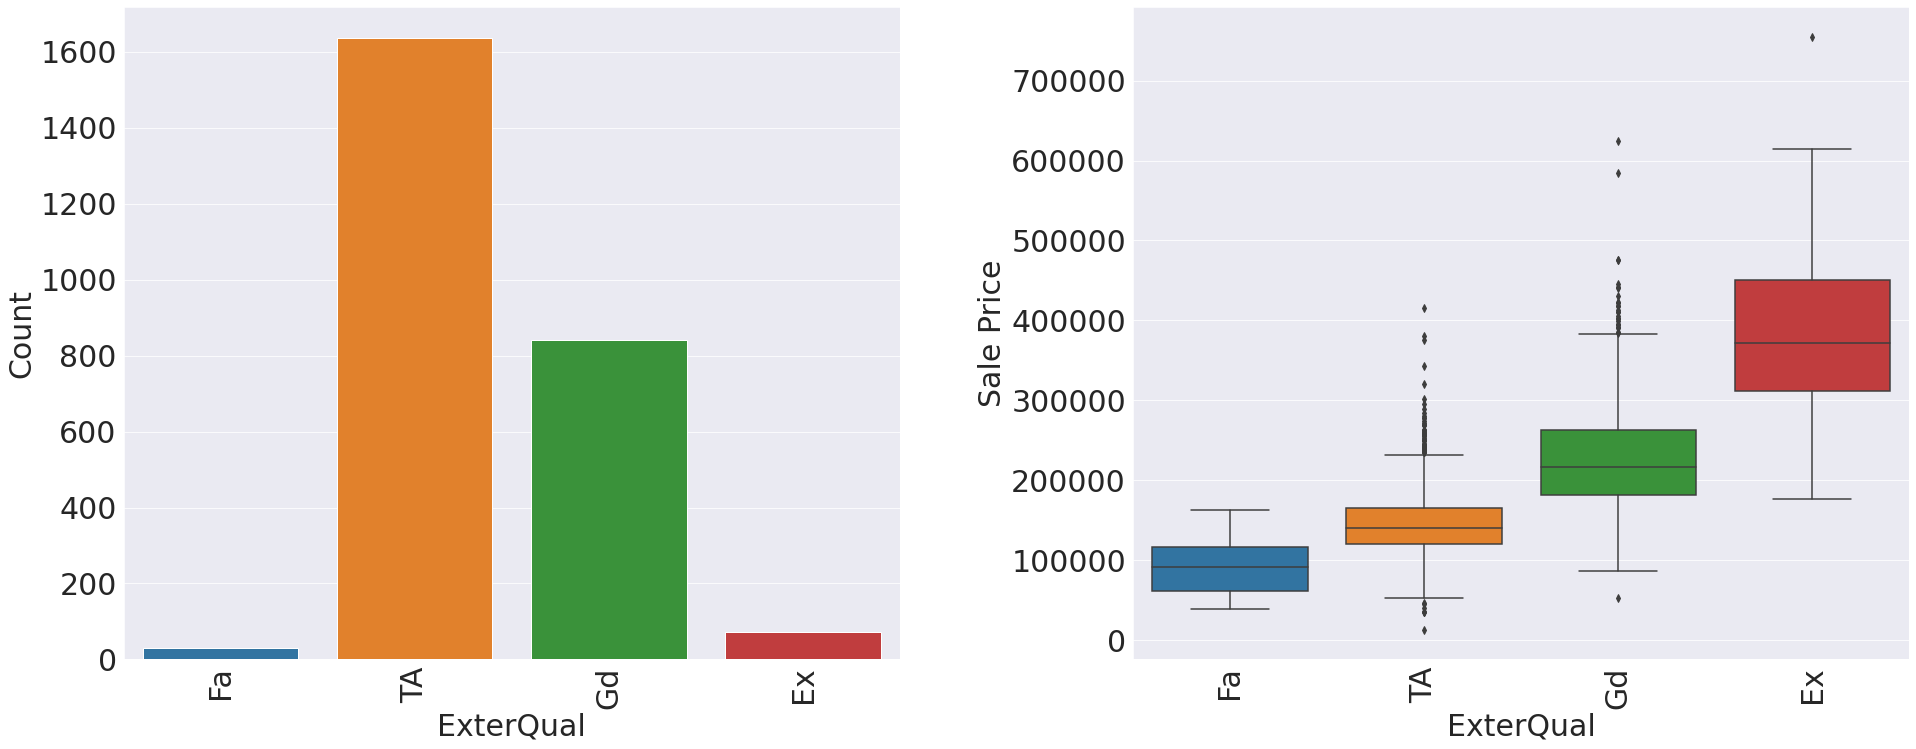

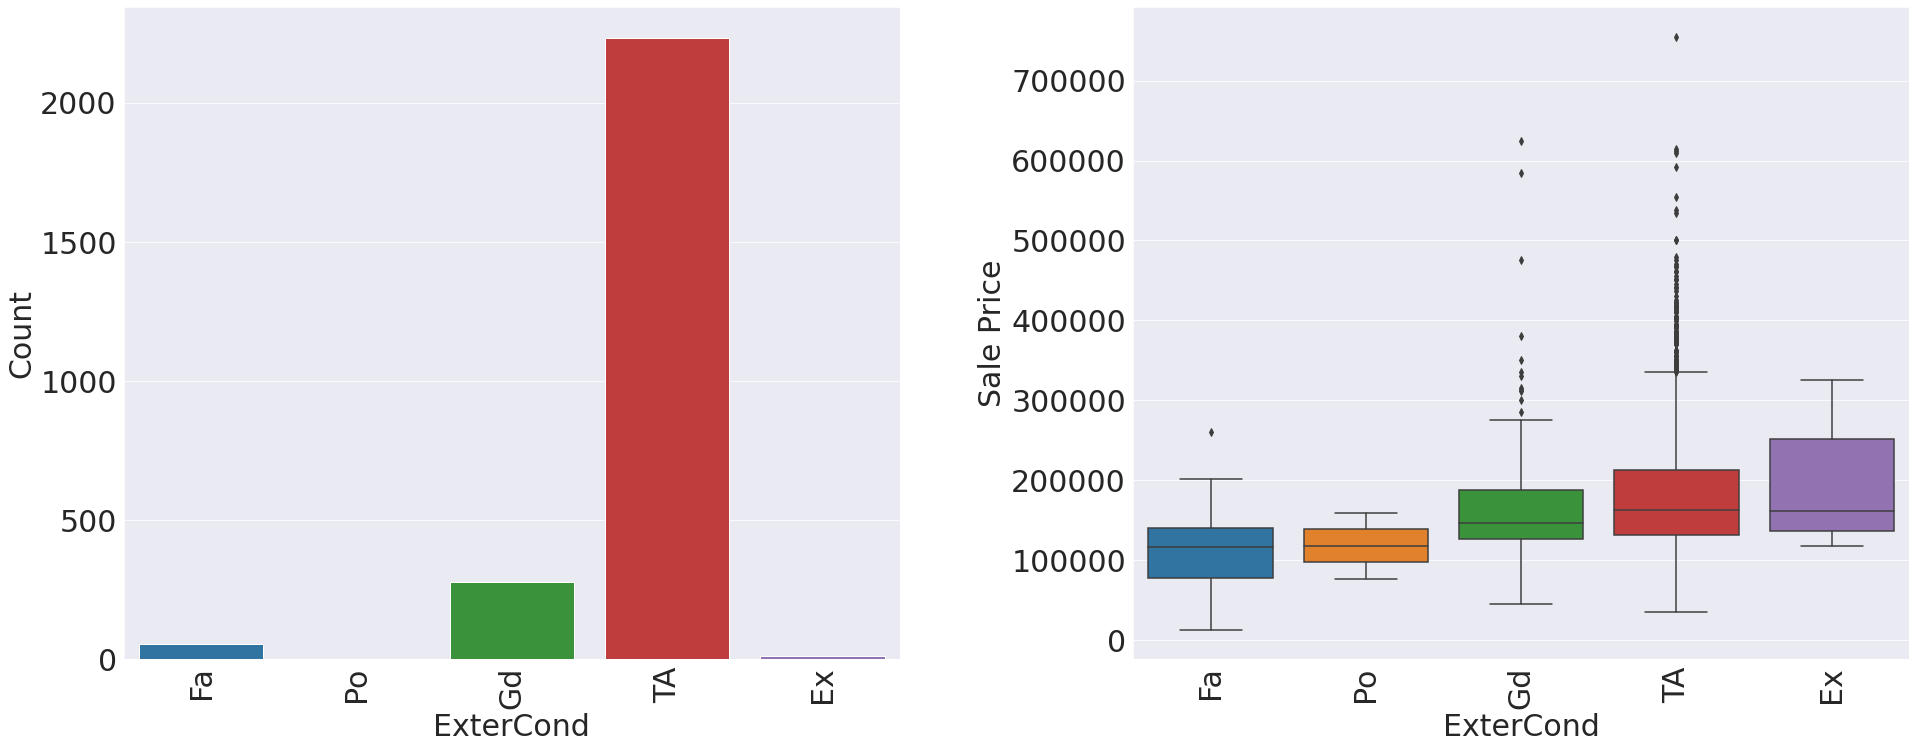

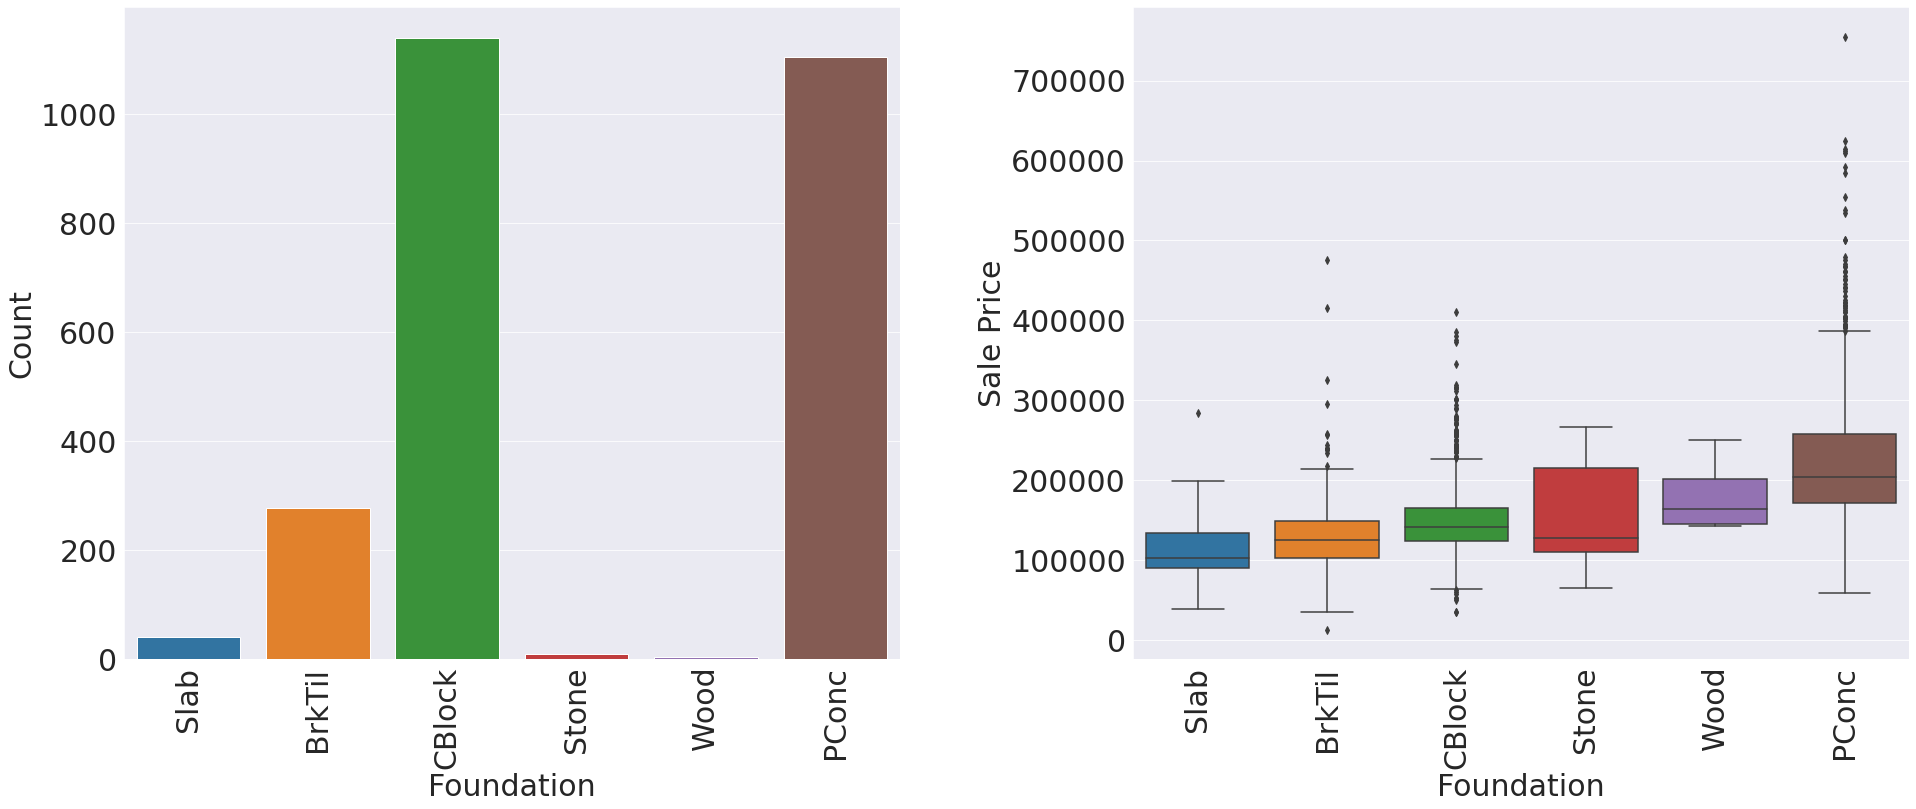

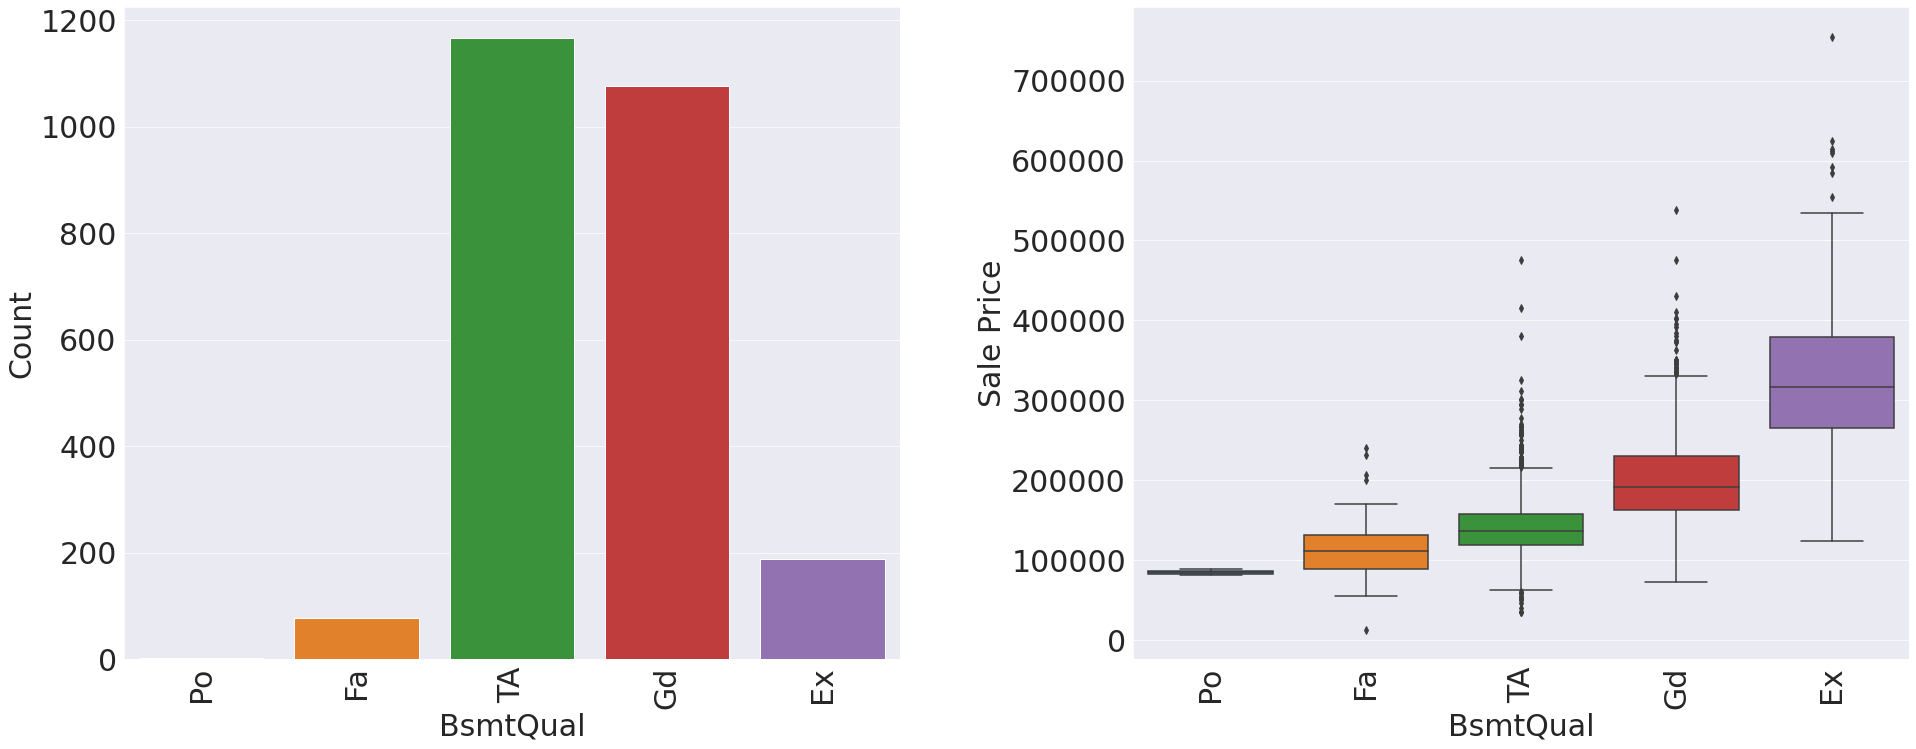

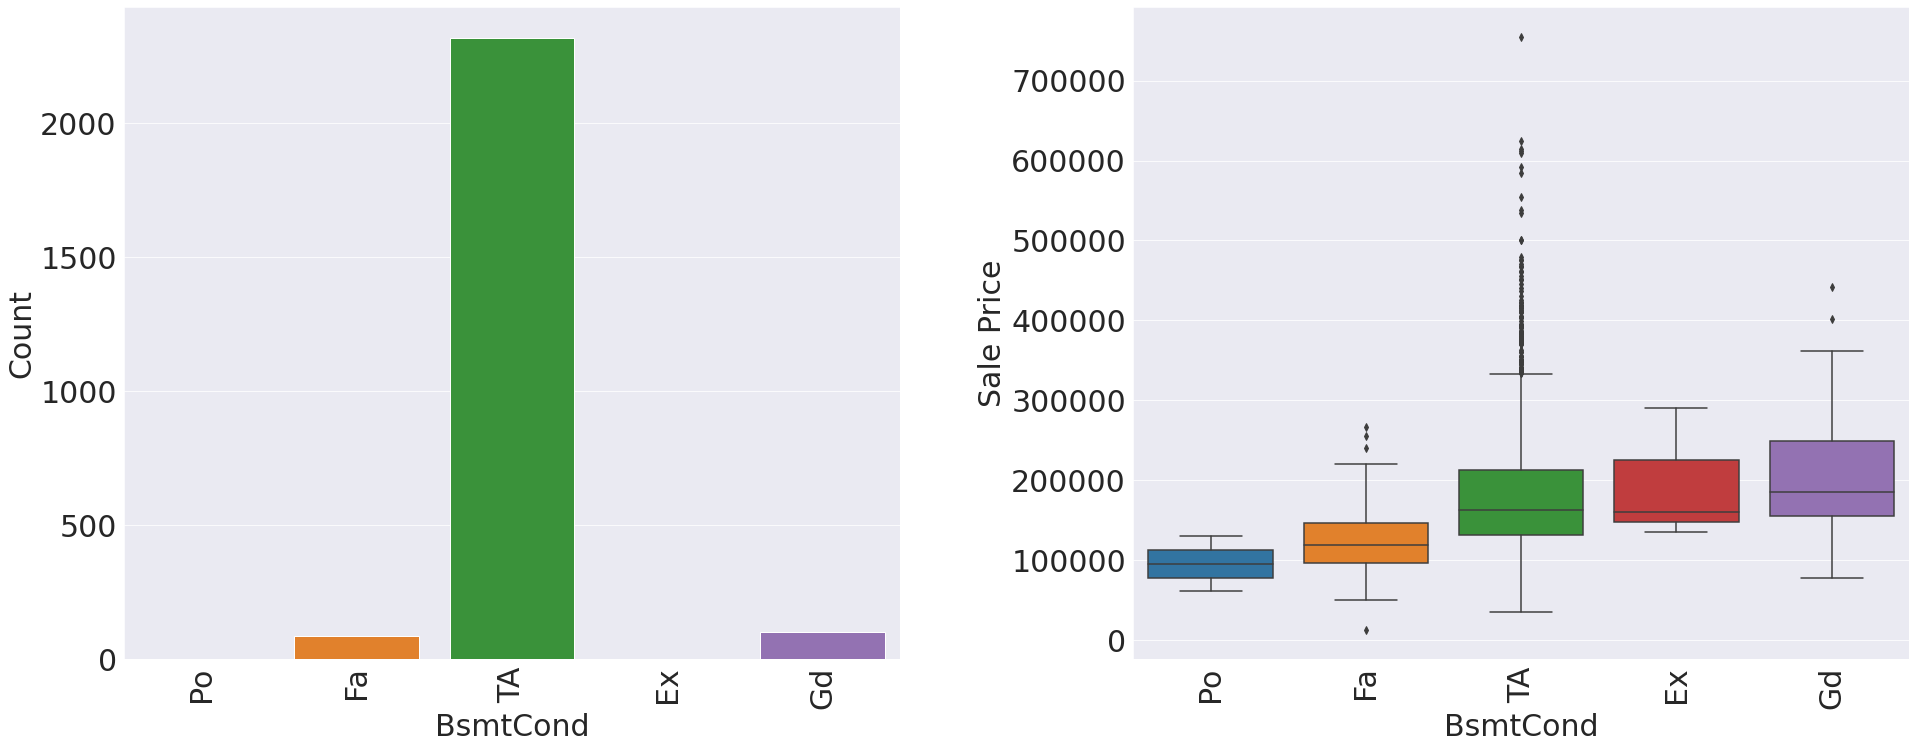

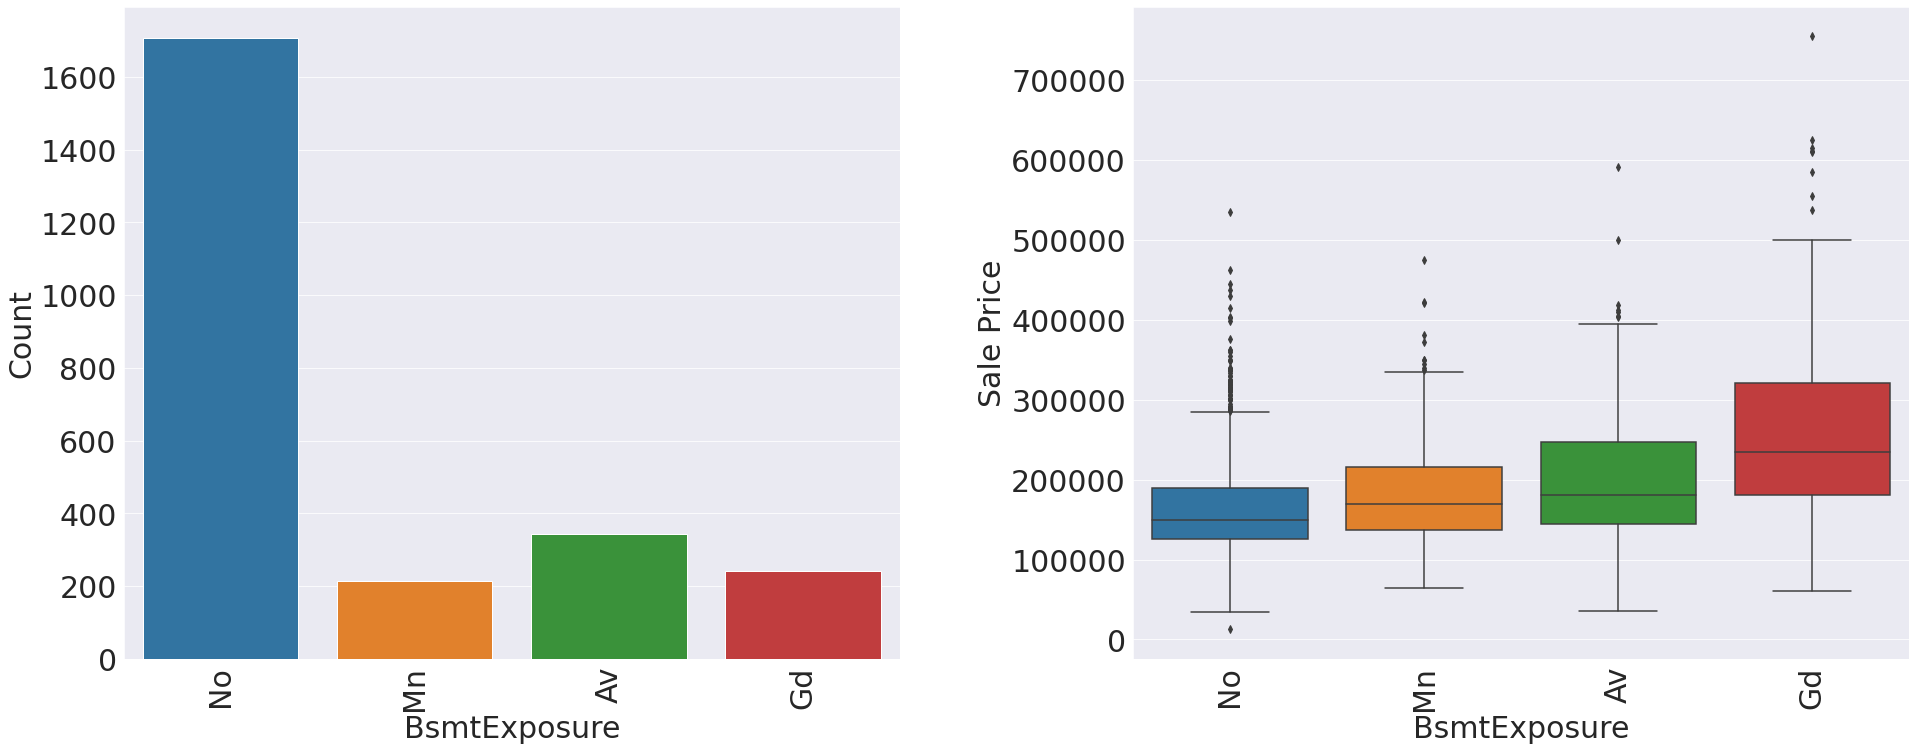

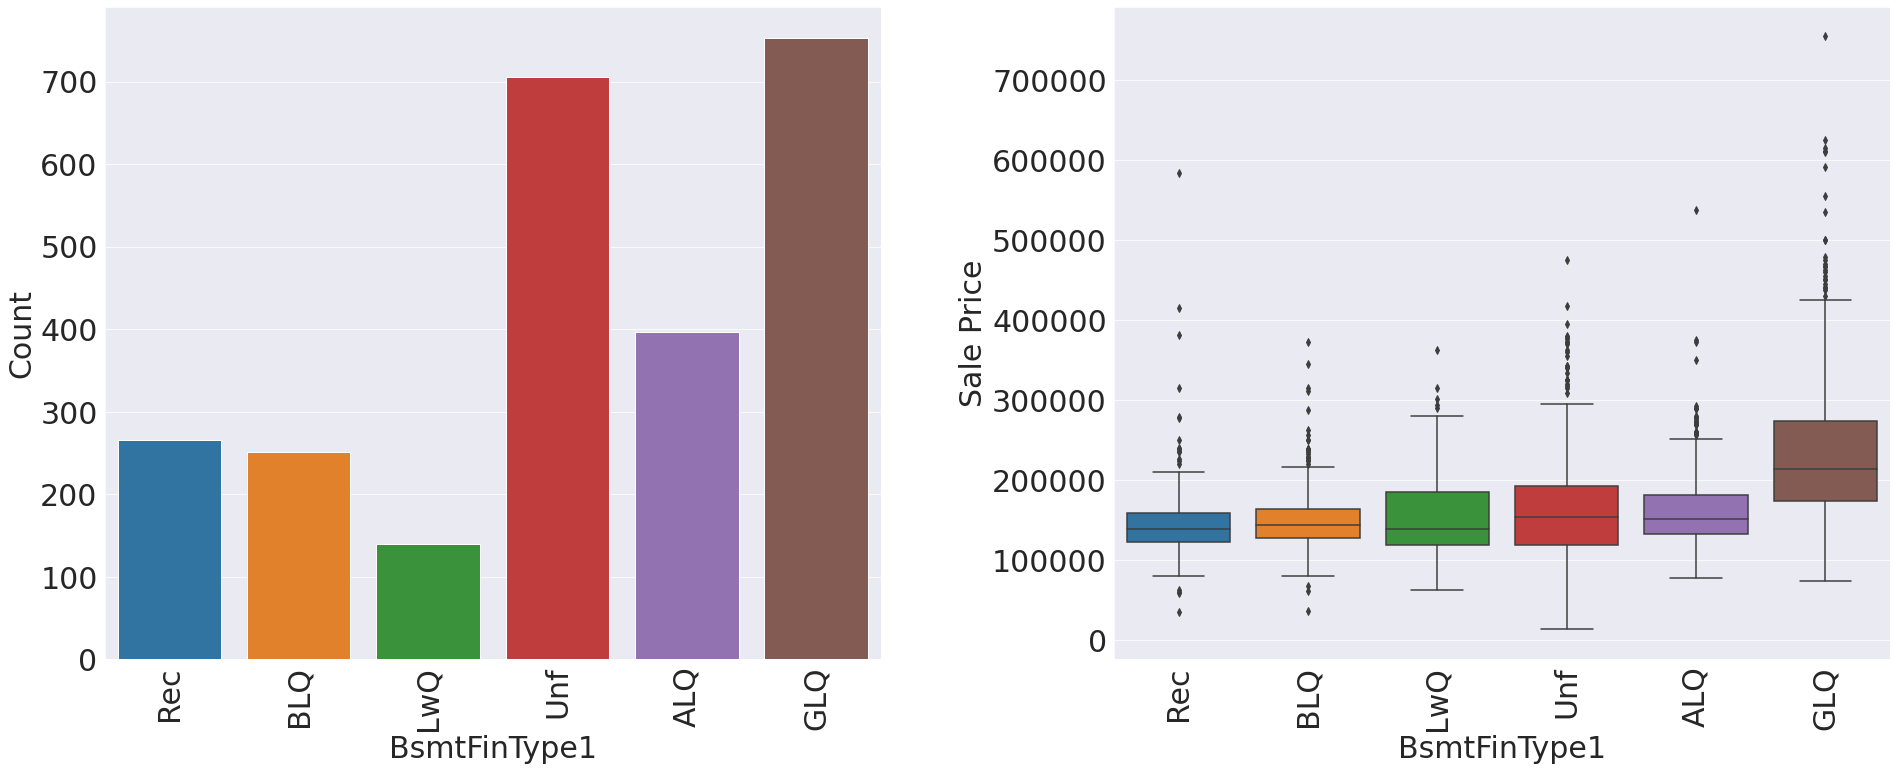

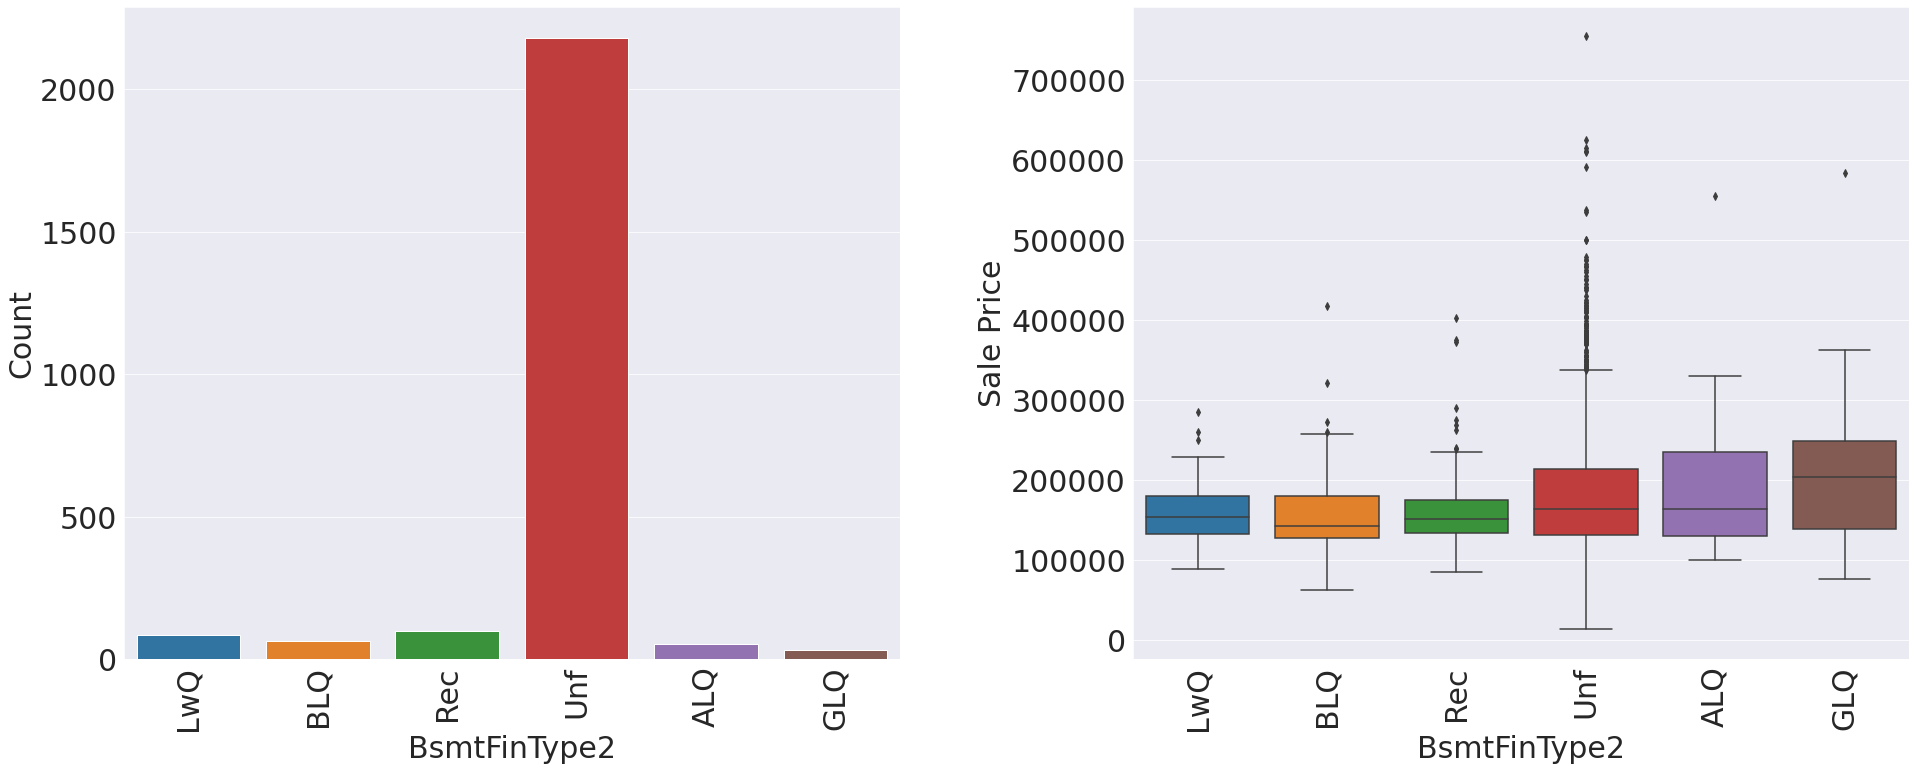

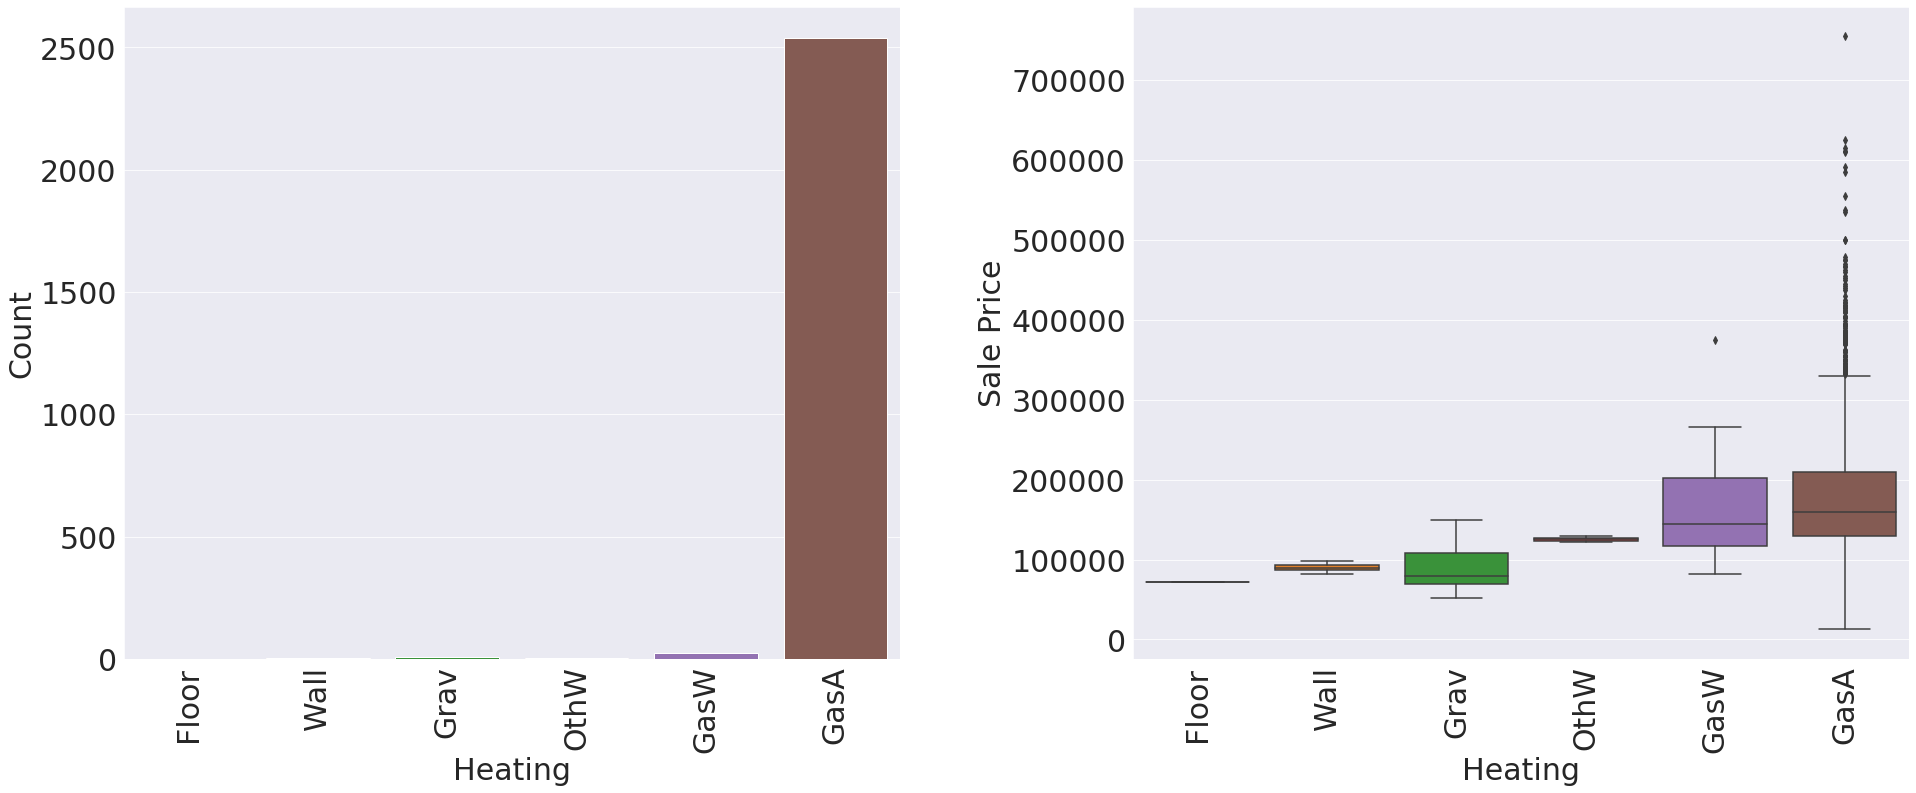

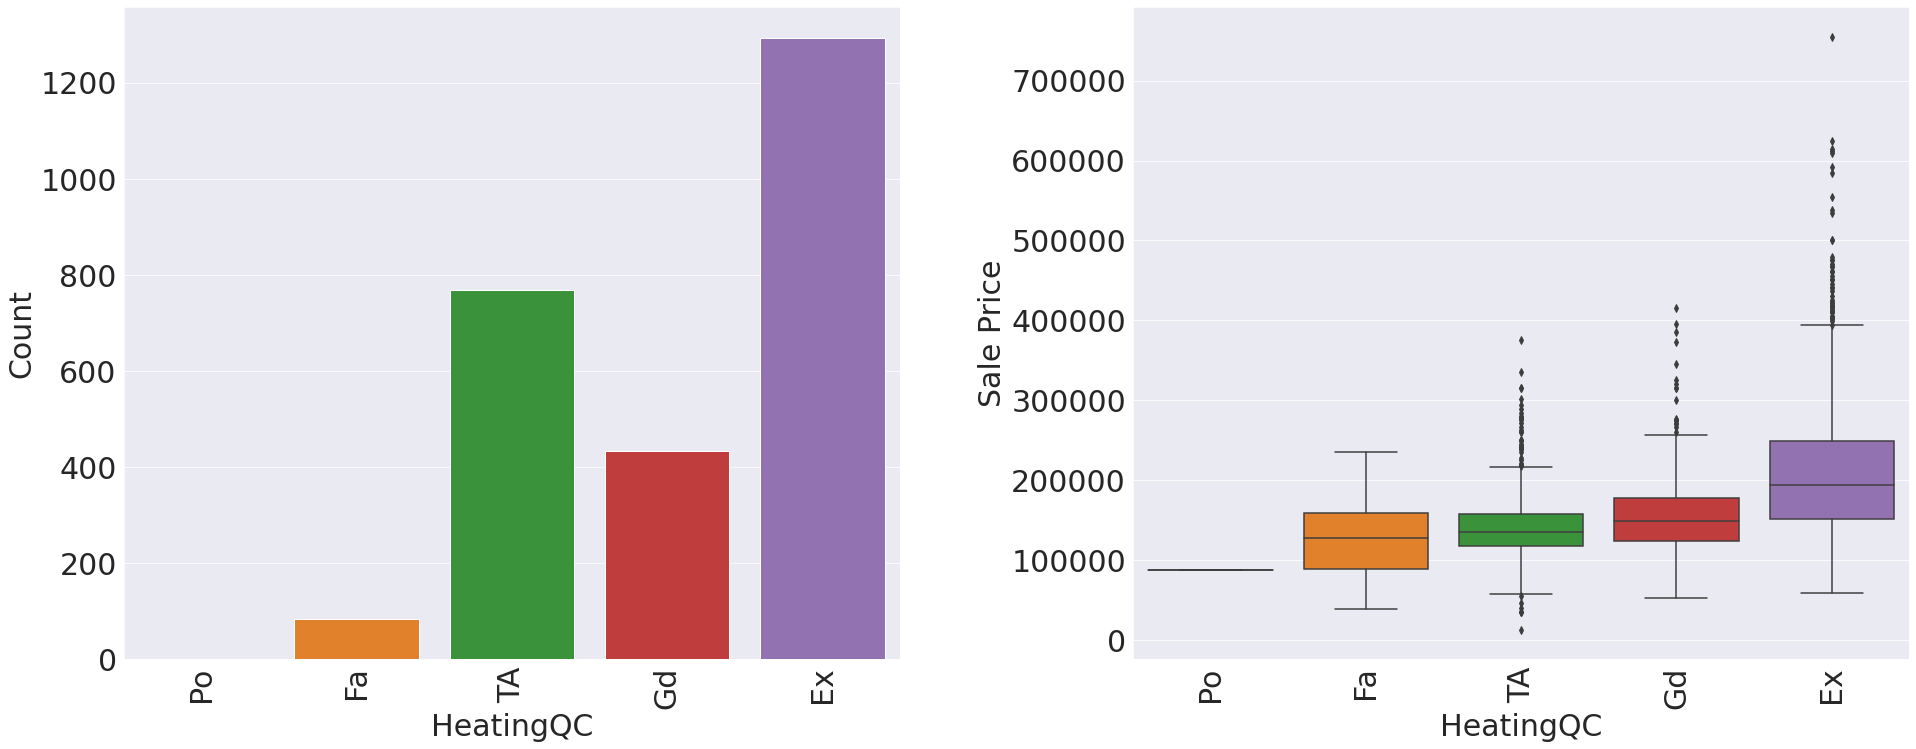

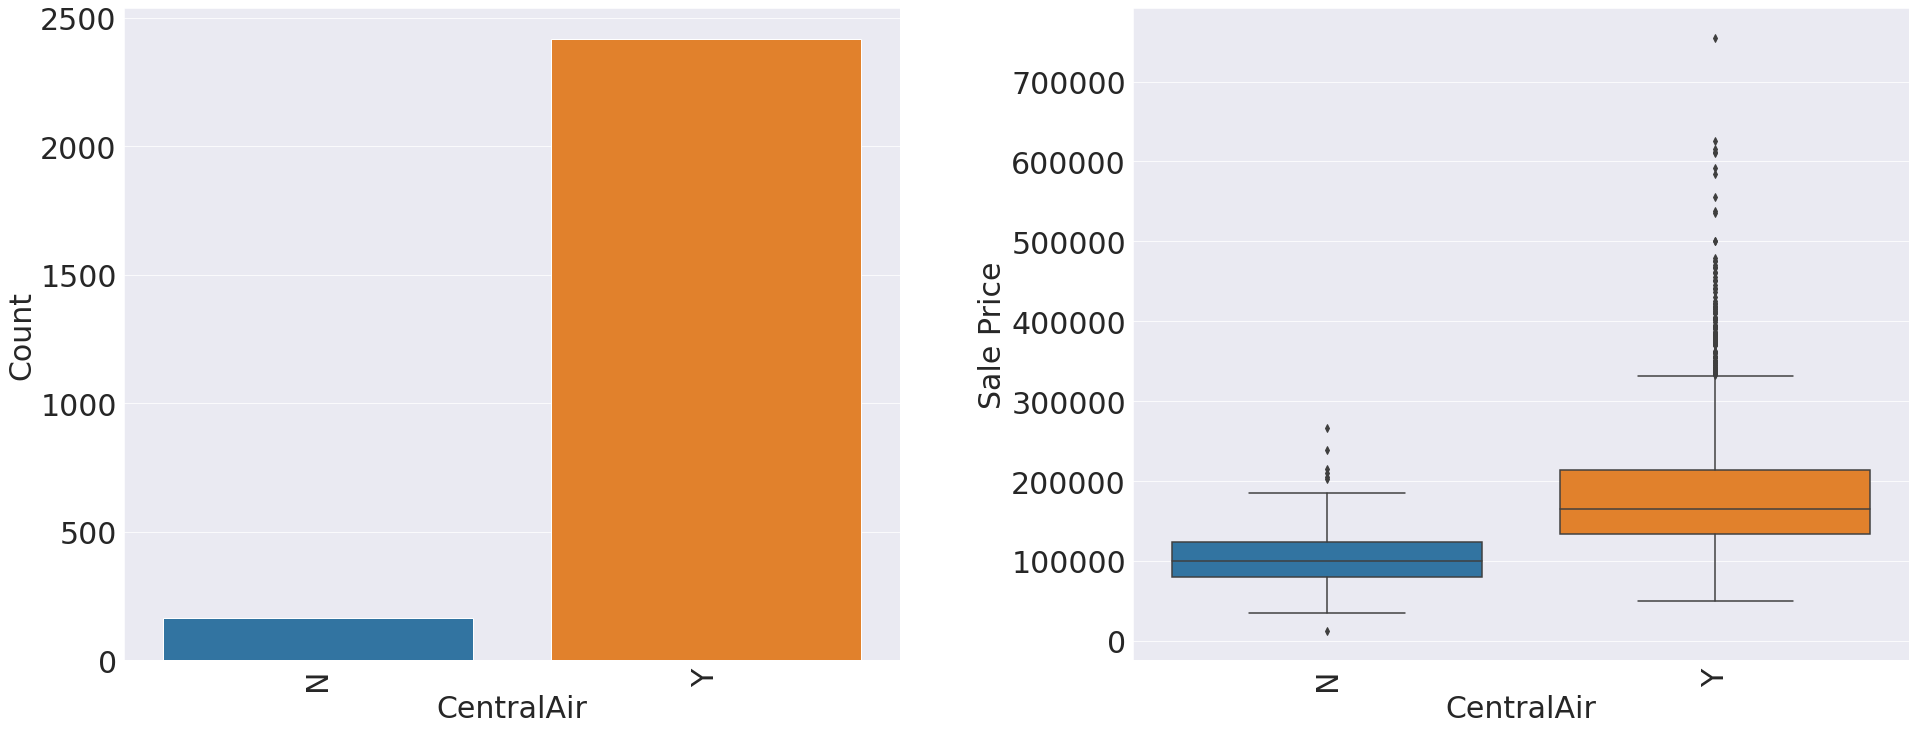

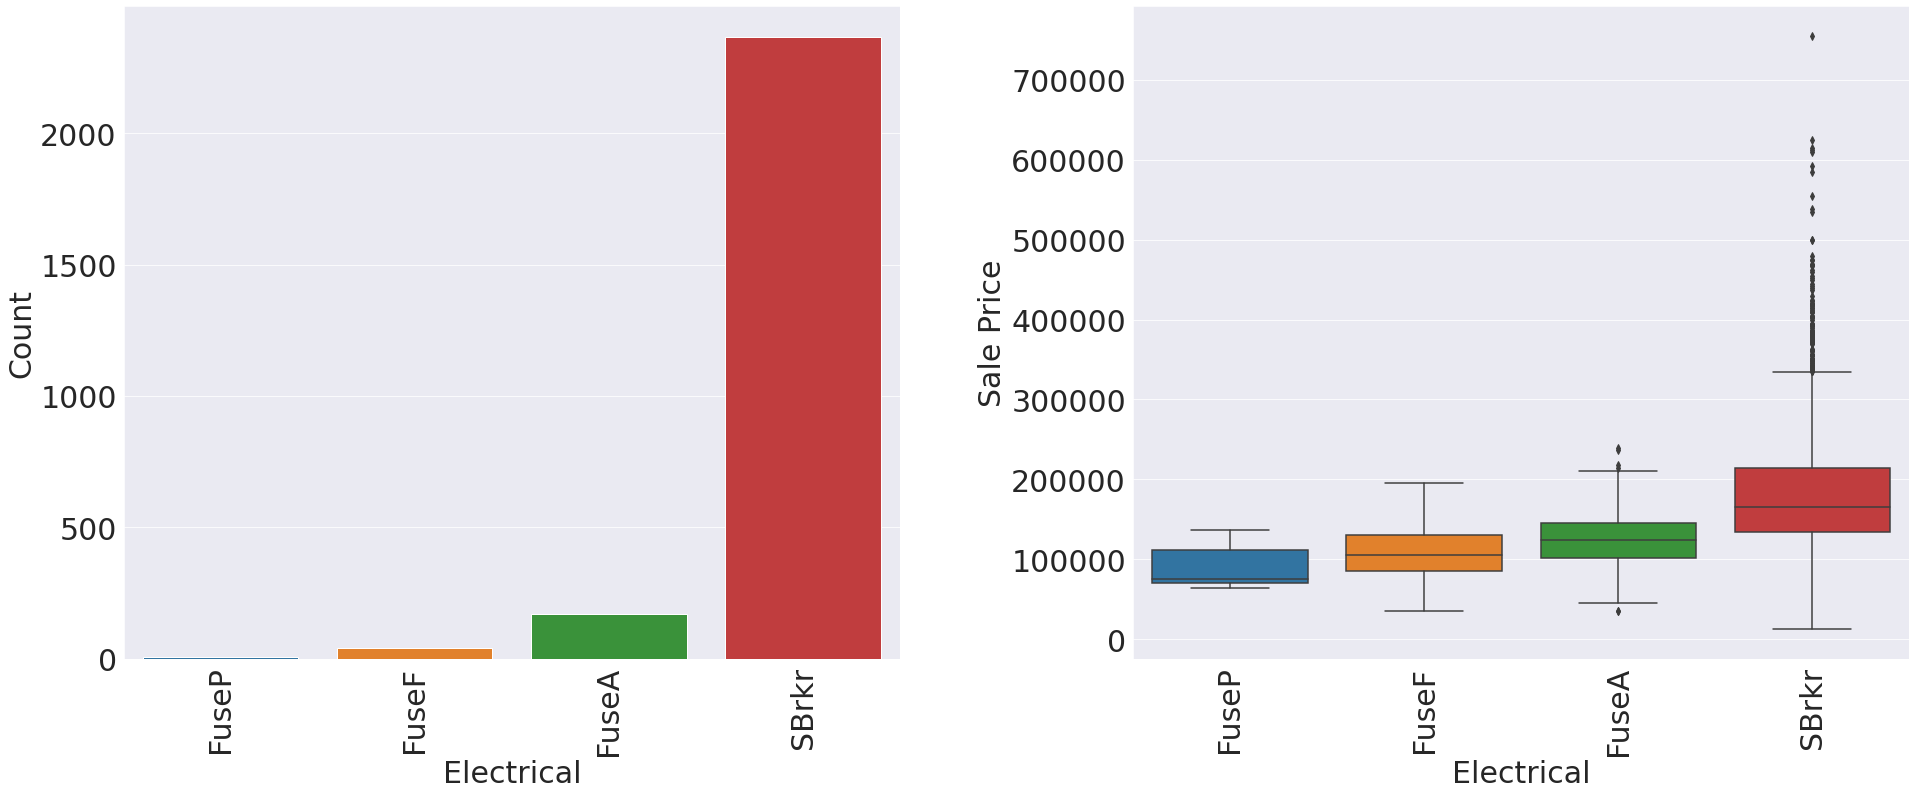

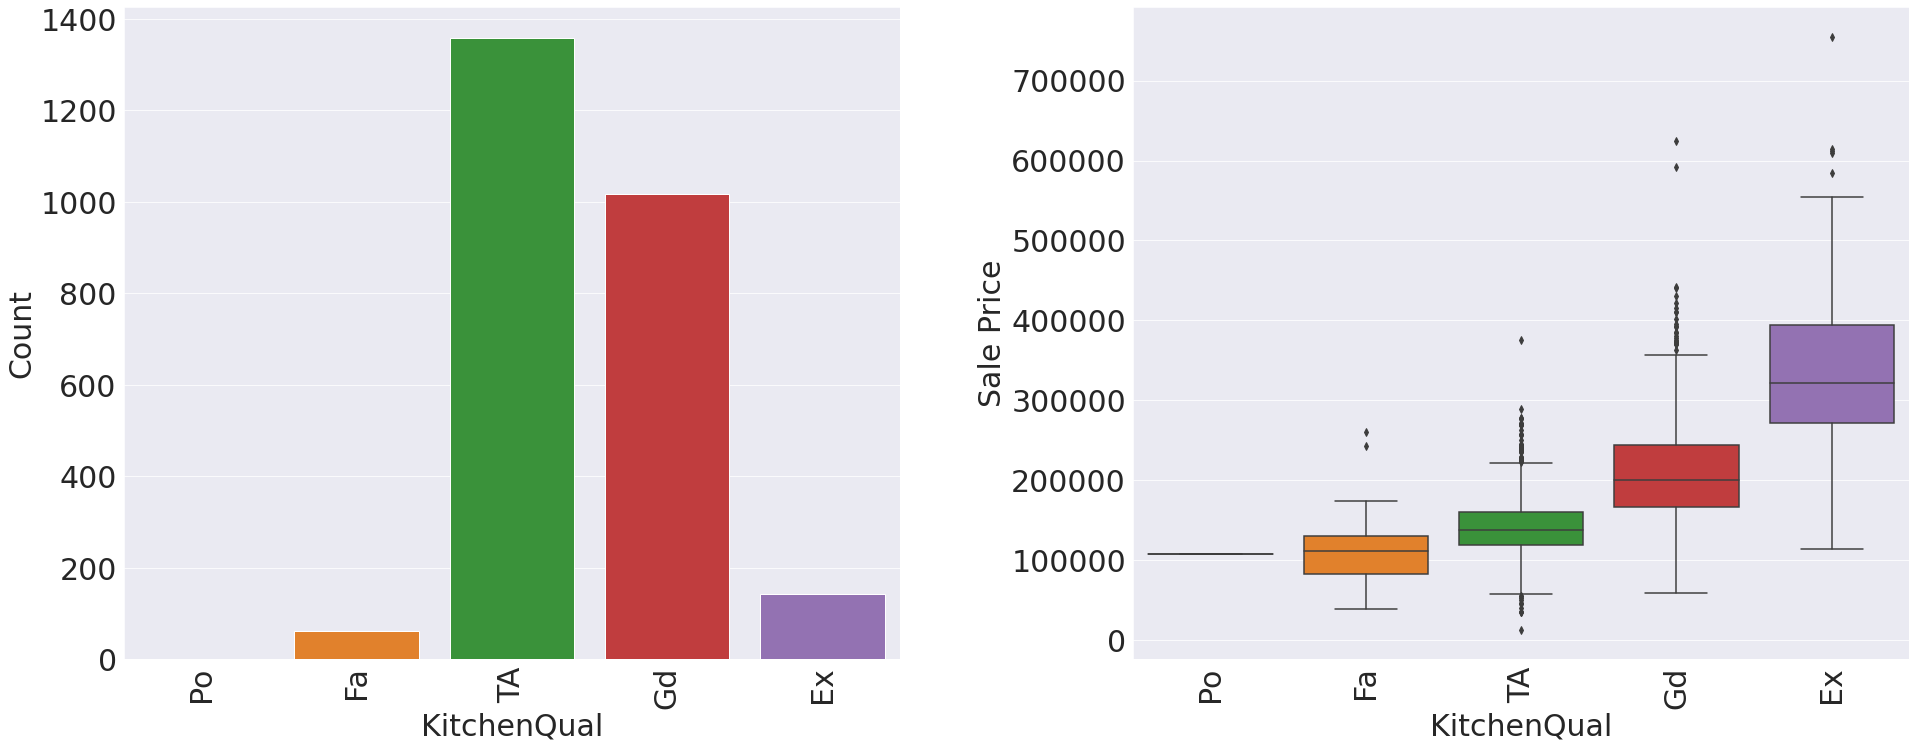

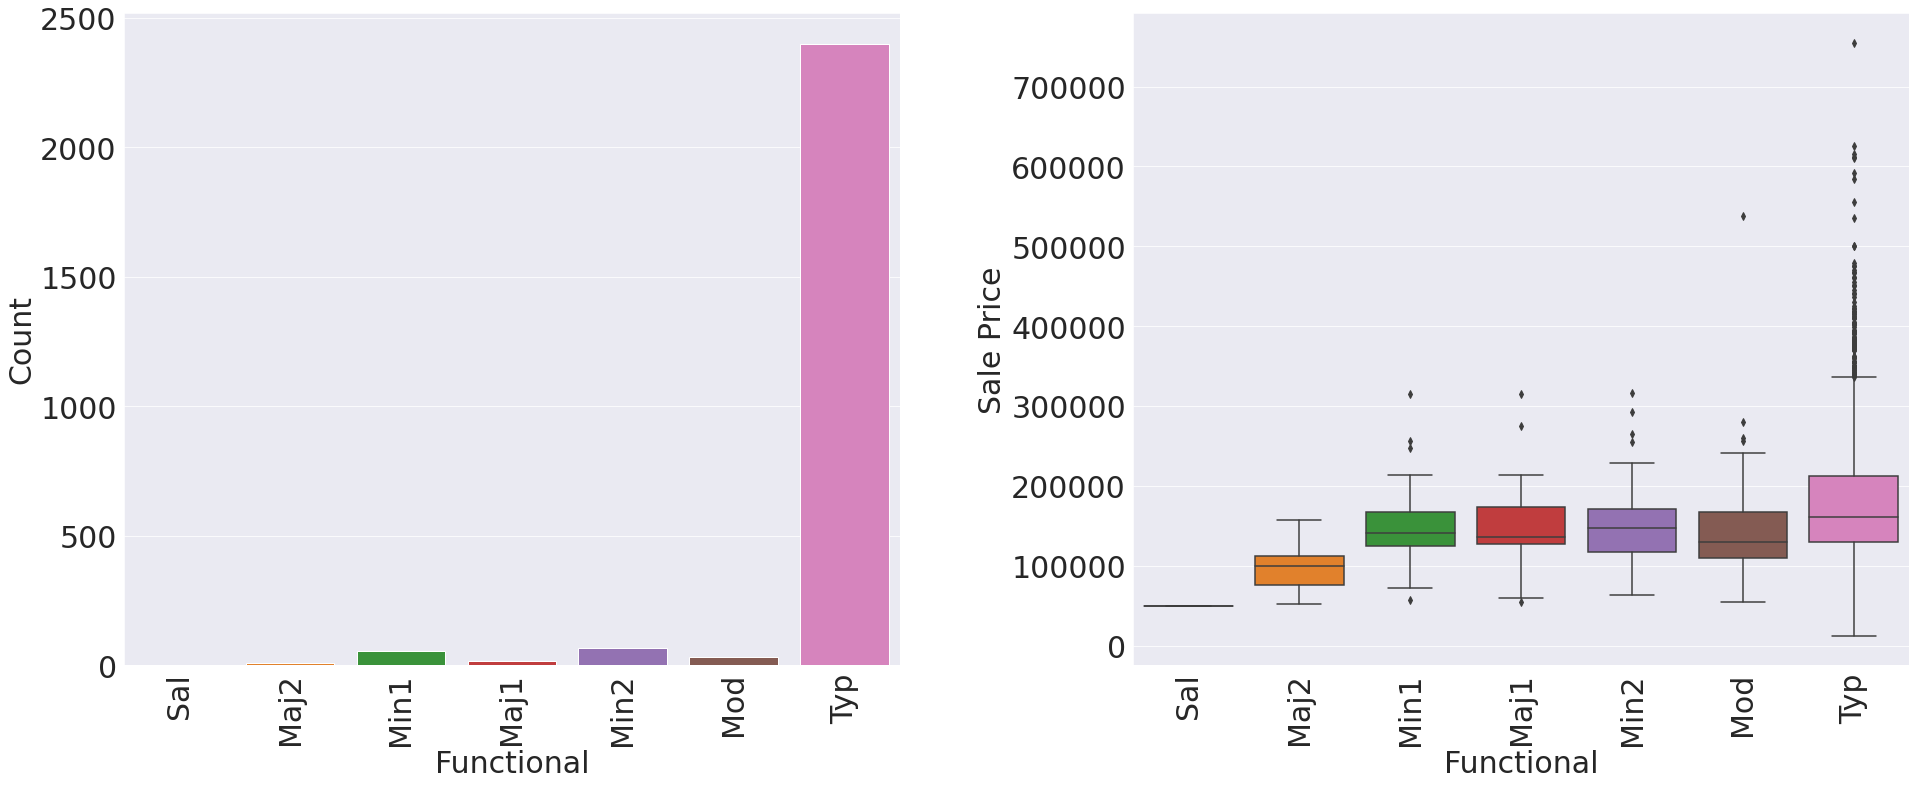

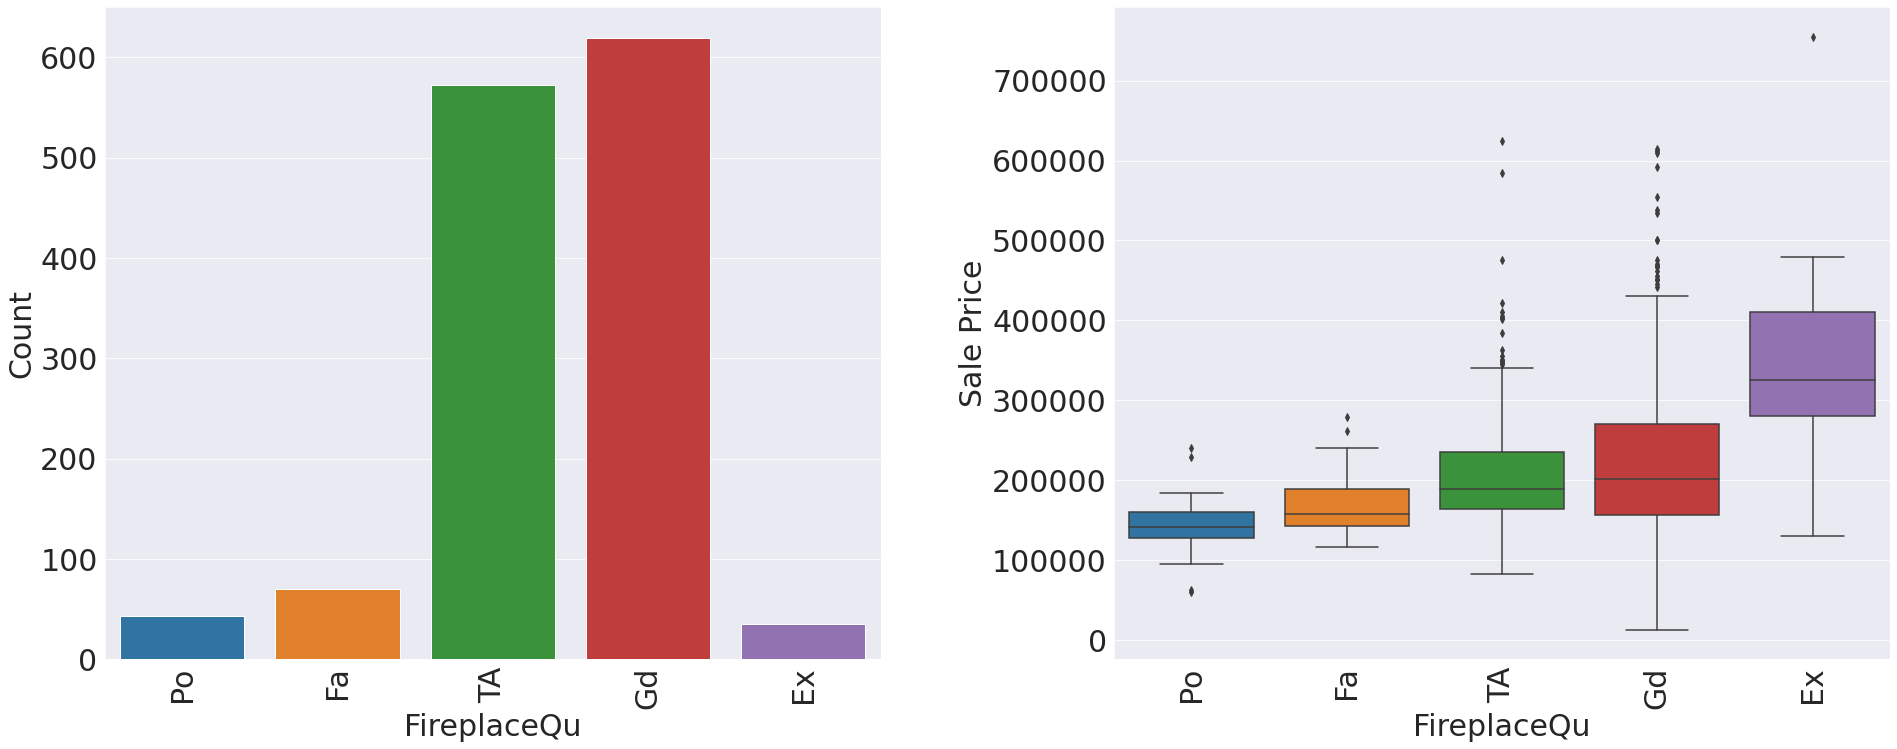

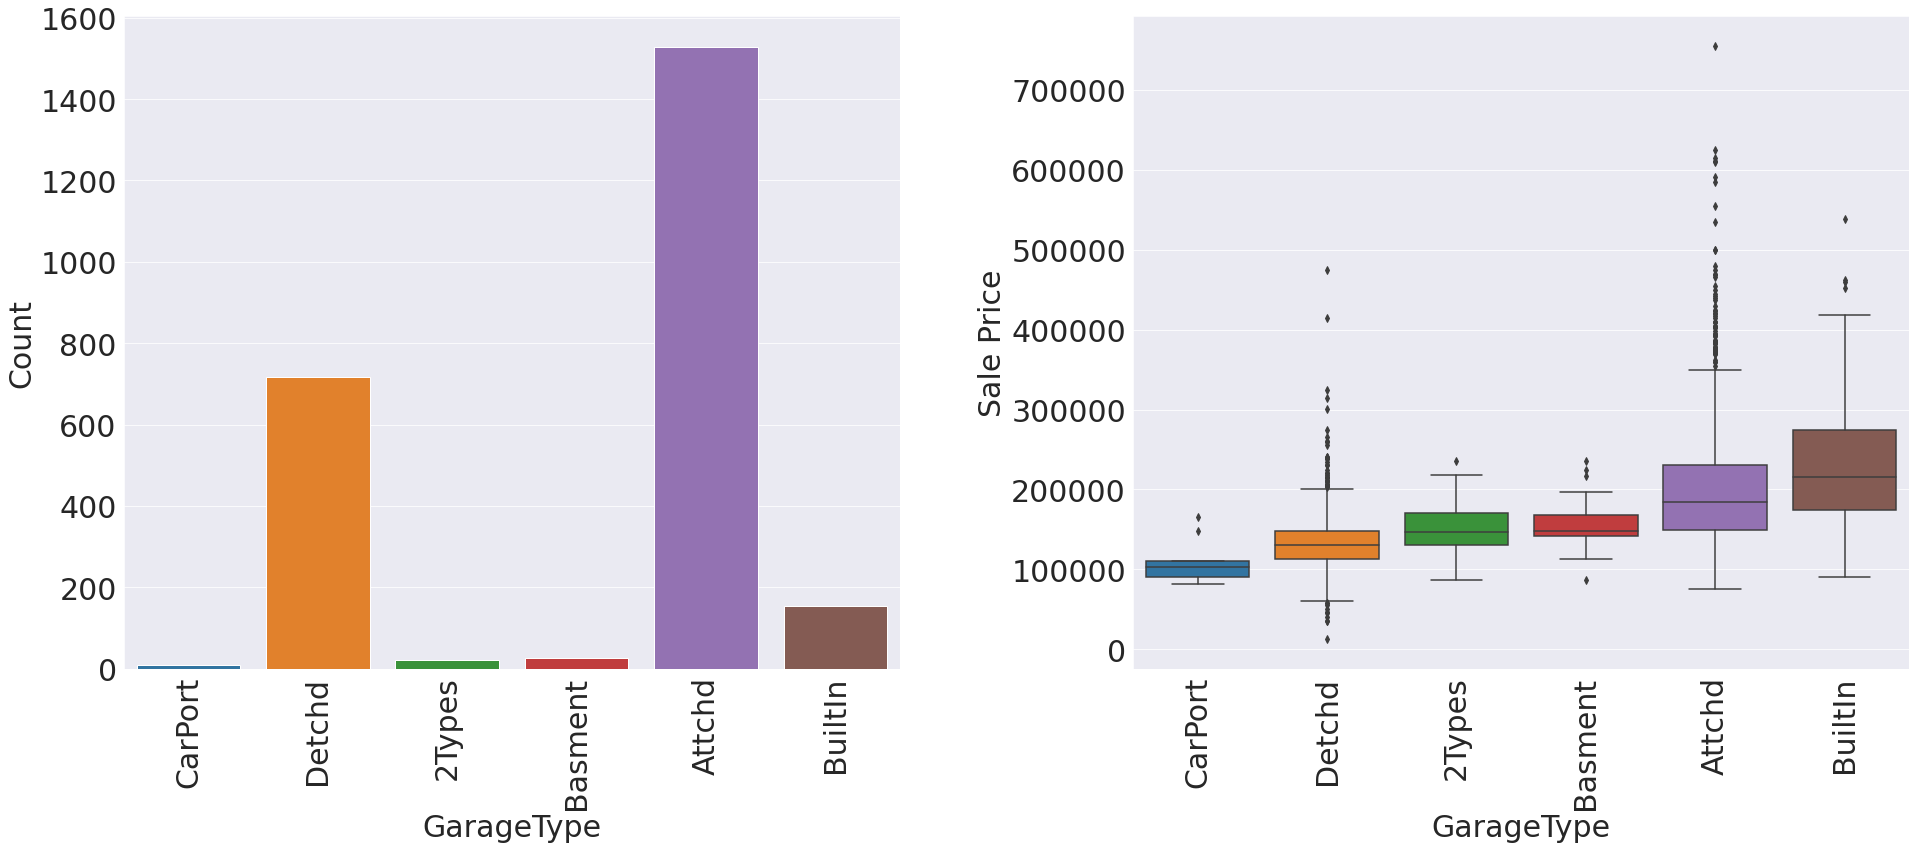

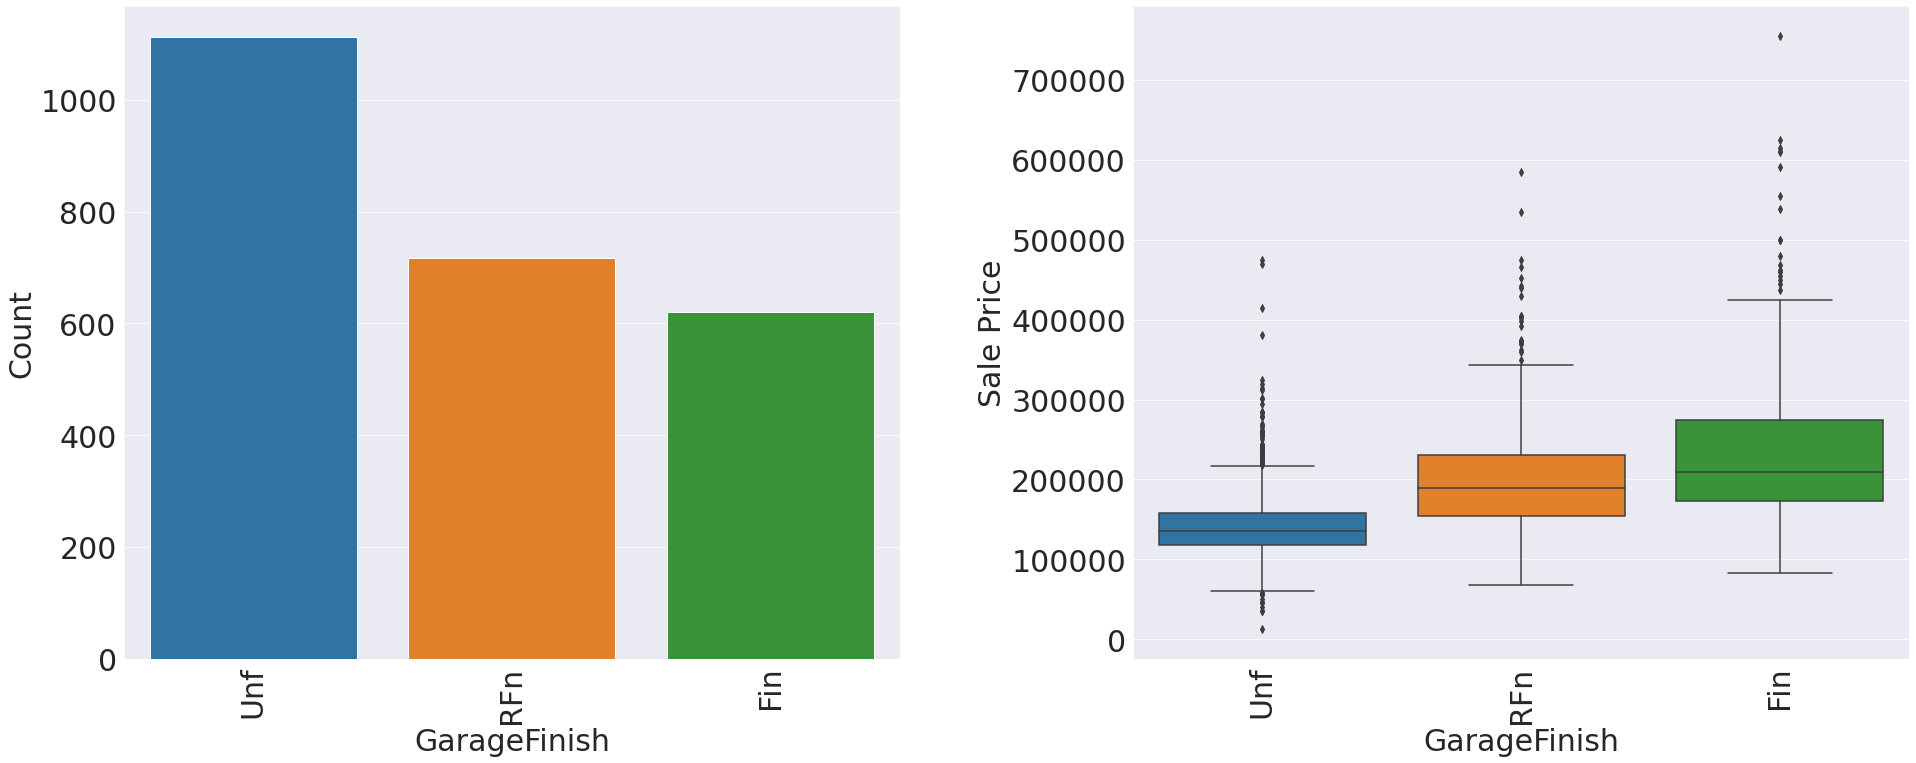

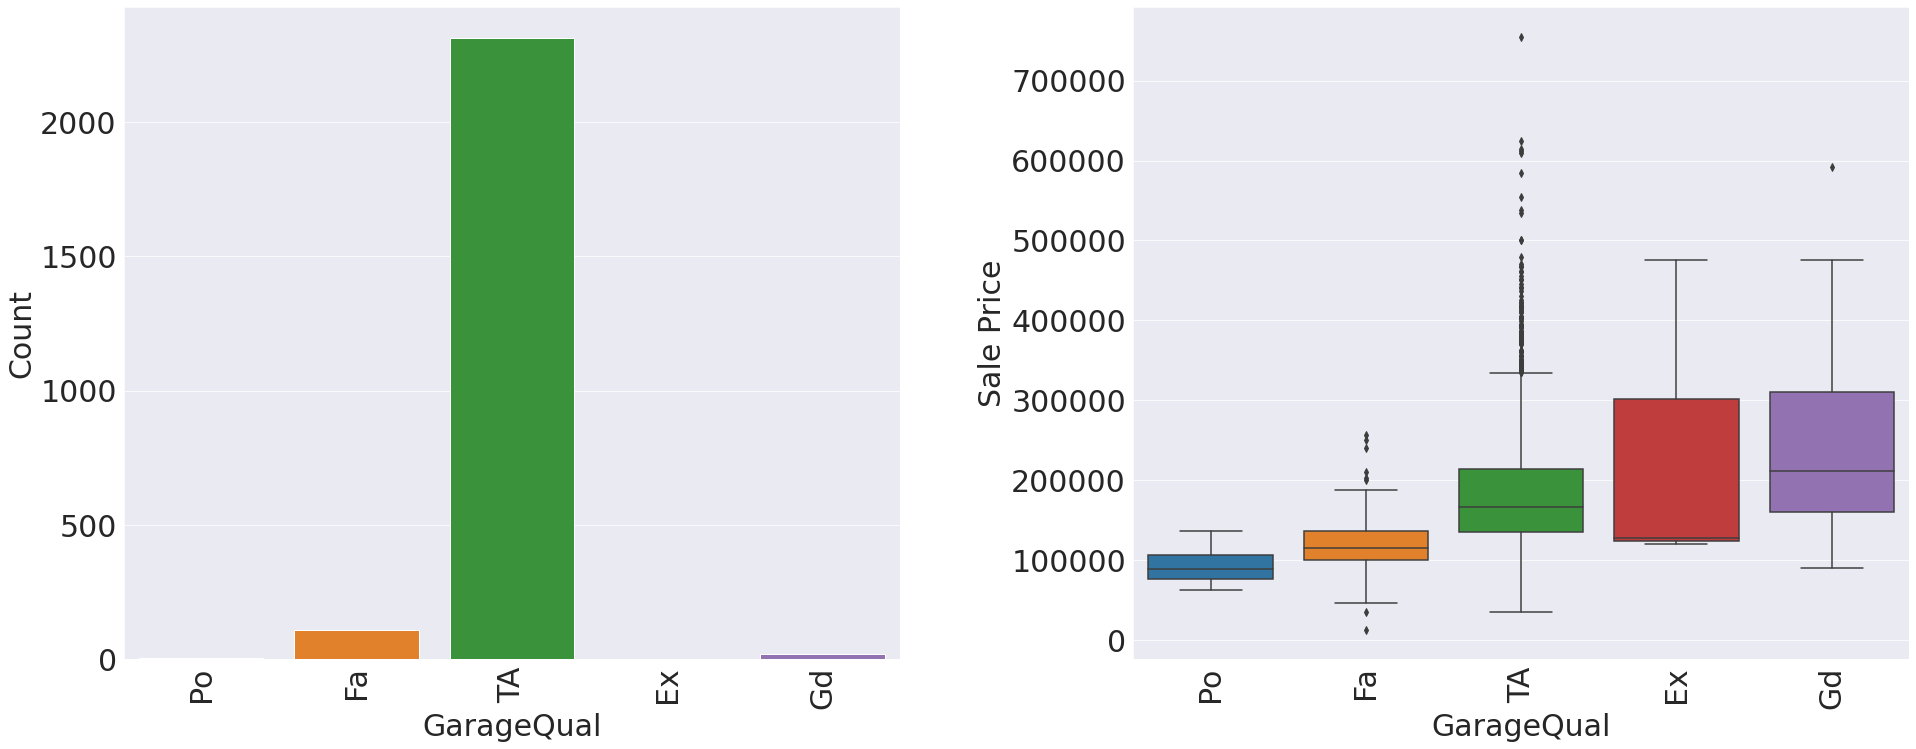

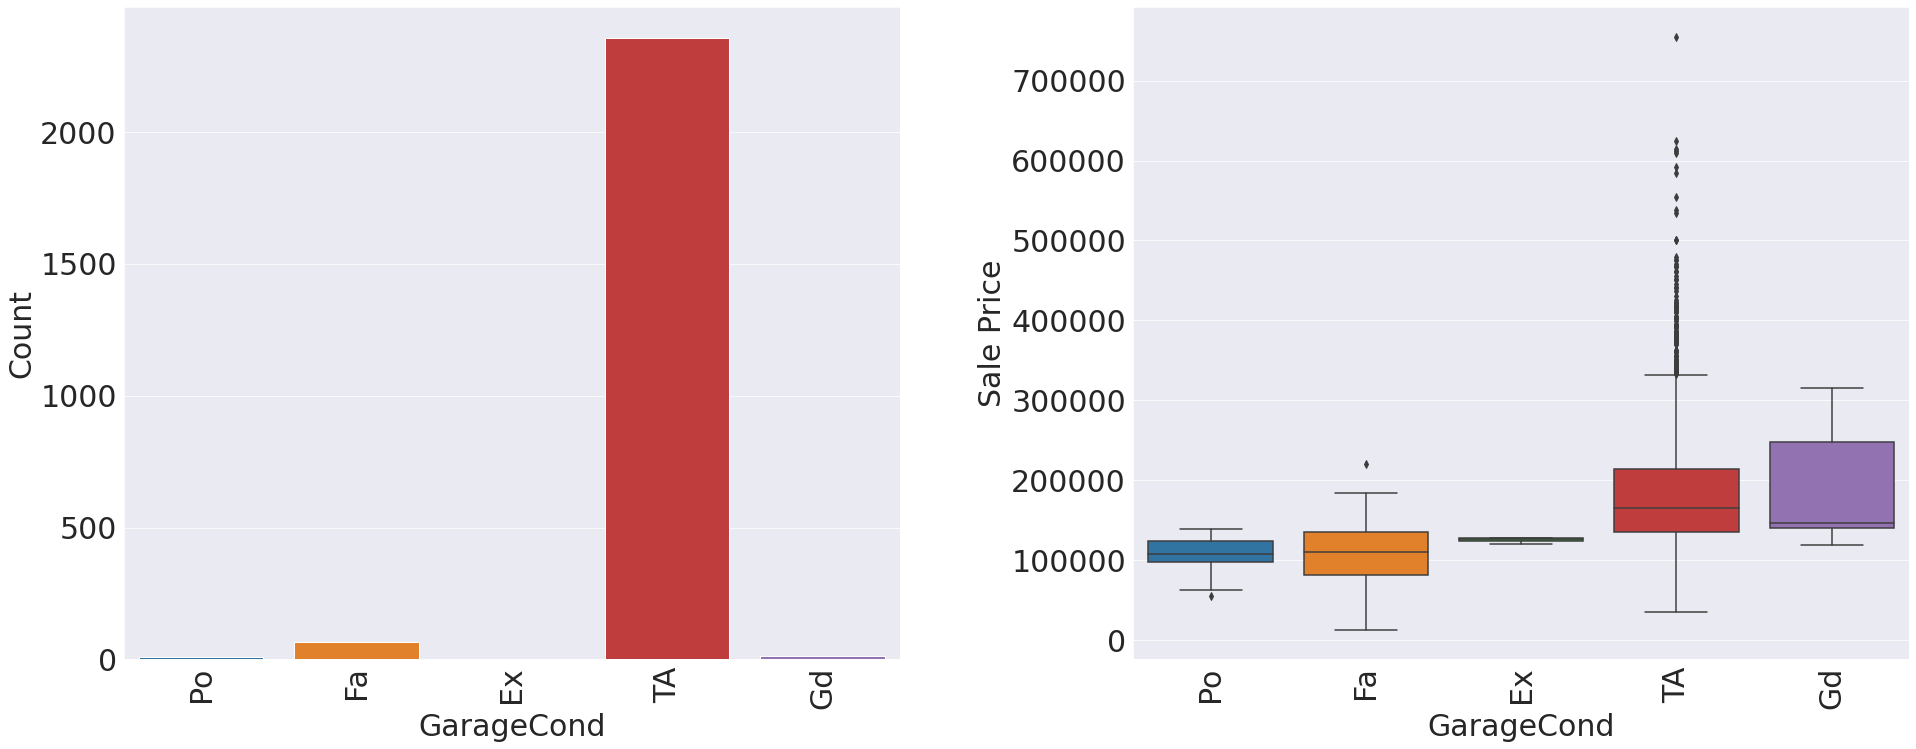

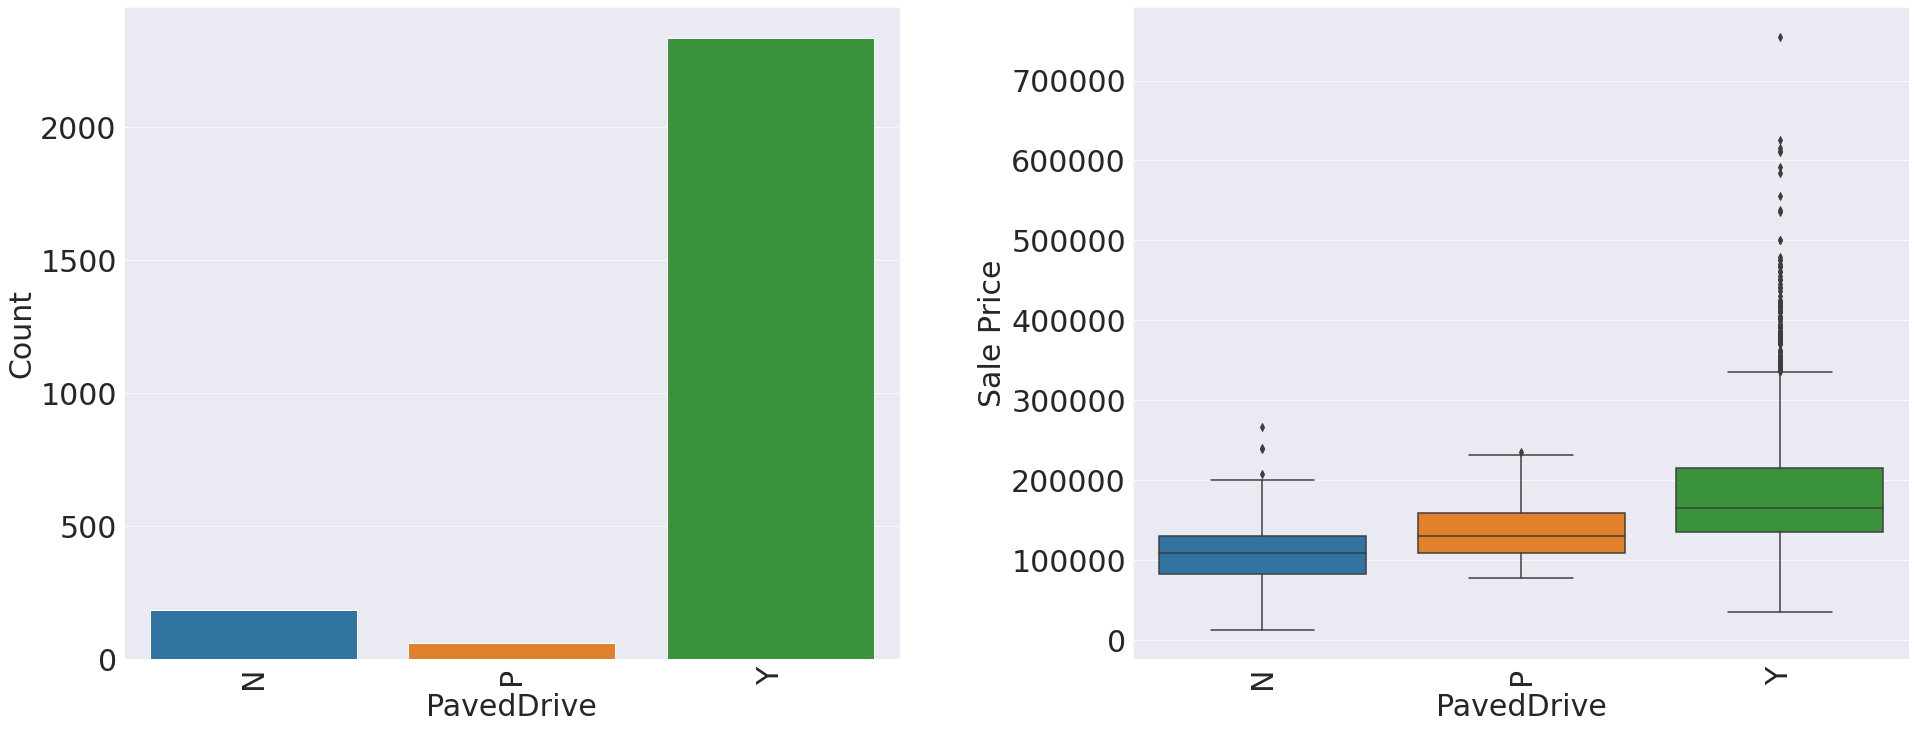

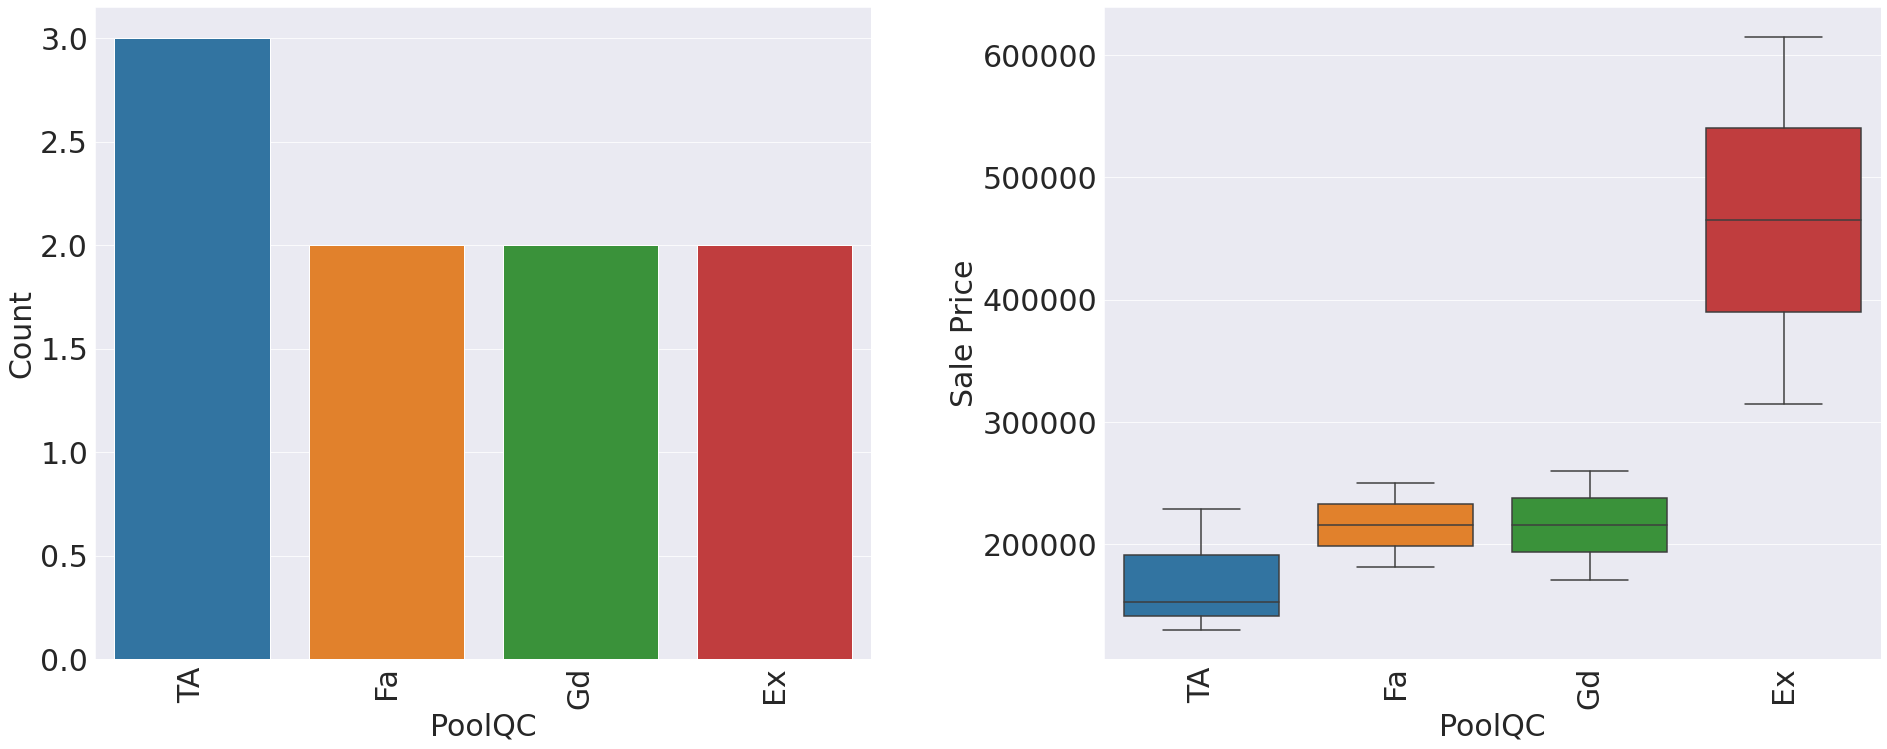

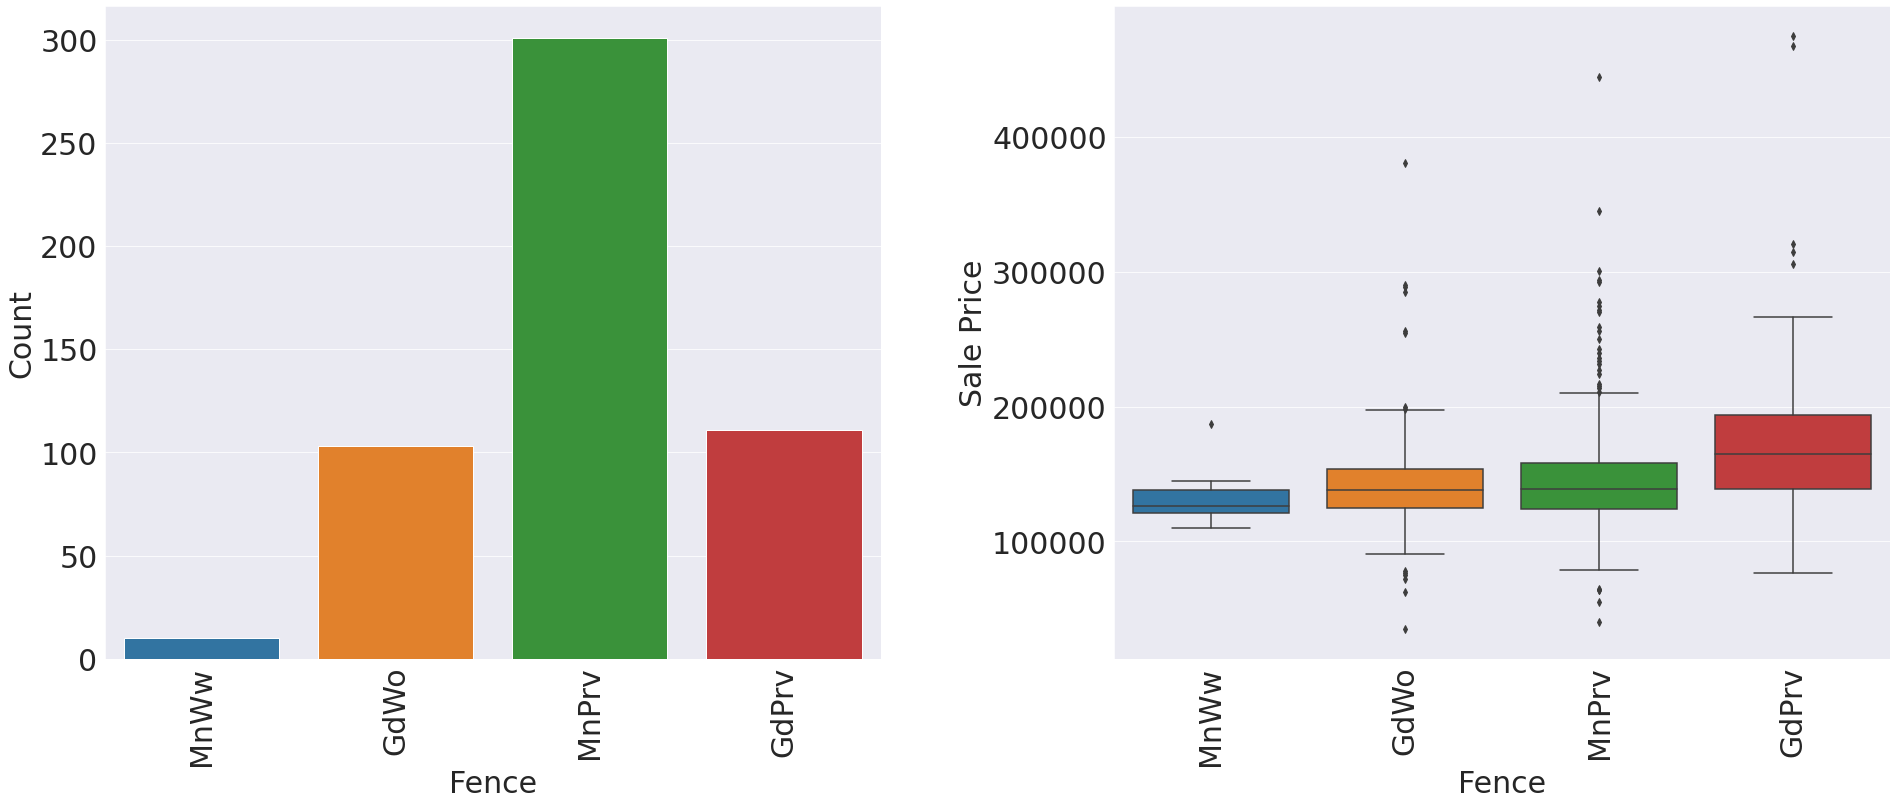

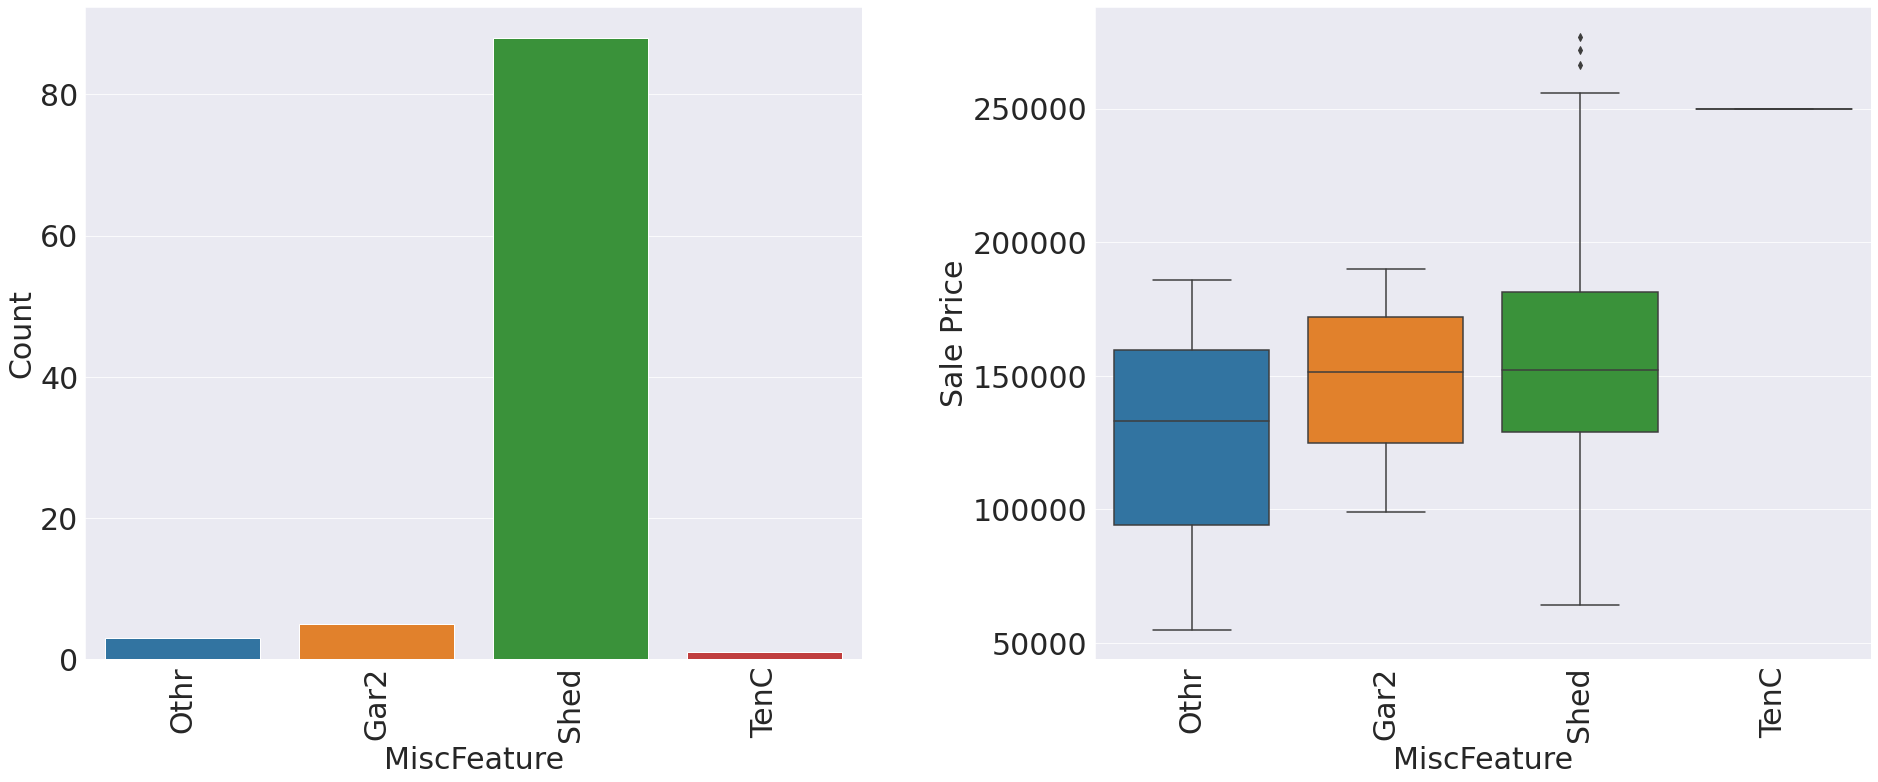

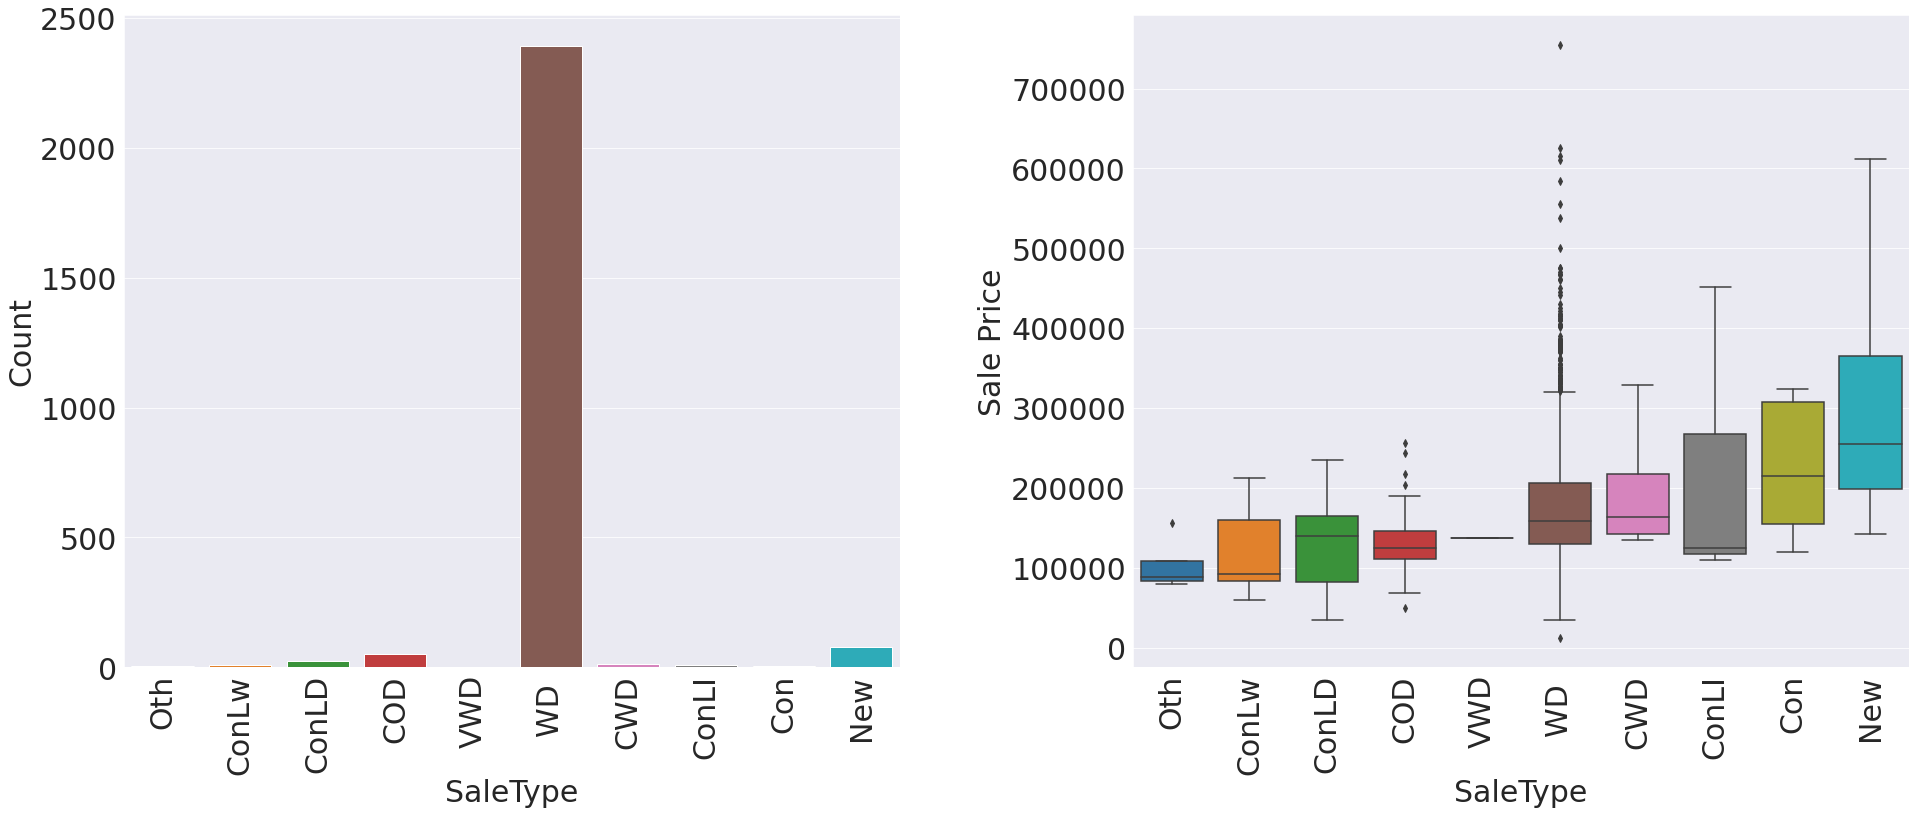

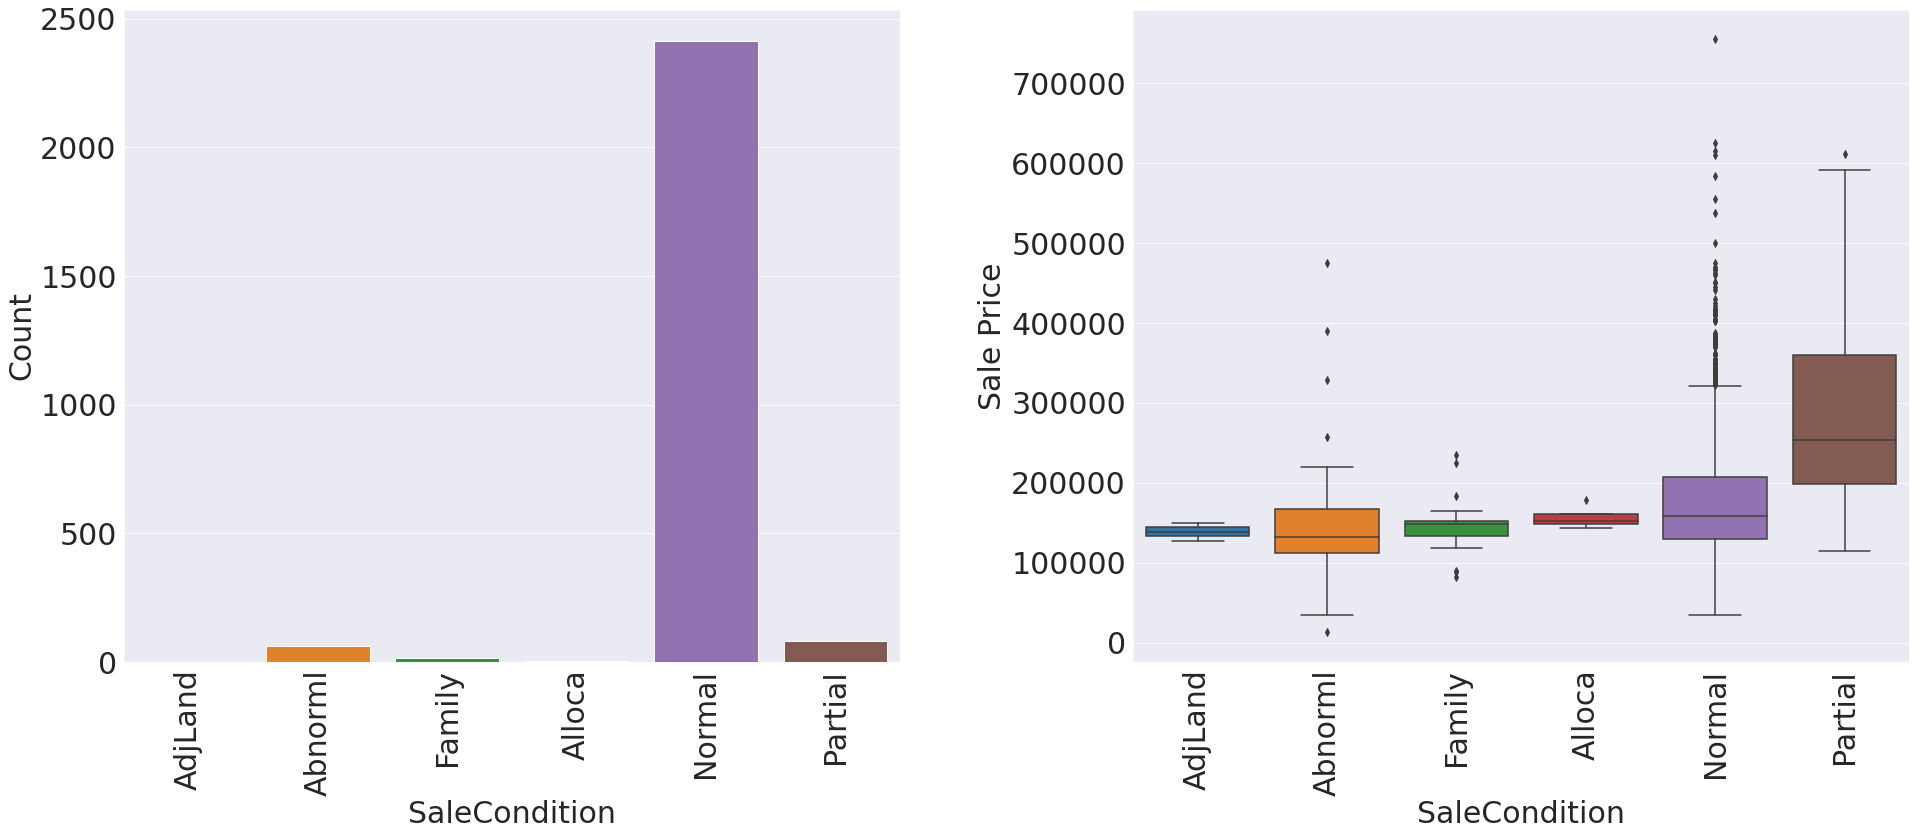

In [23]:
for feature in df_raw.select_dtypes(include=['O']):
    feature_plot(df_raw, feature)

# Remove features based on correlation to avoid multicollinearity 

GrLivArea  LotFrontage   LotArea  OverallQual  OverallCond  \
GrLivArea       1.000000     0.345448  0.260322     0.559897    -0.105670   
LotFrontage     0.345448     1.000000  0.463720     0.179656    -0.054048   
LotArea         0.260322     0.463720  1.000000     0.080607    -0.032693   
OverallQual     0.559897     0.179656  0.080607     1.000000    -0.095927   
OverallCond    -0.105670    -0.054048 -0.032693    -0.095927     1.000000   
YearBuilt       0.228400     0.099602  0.012397     0.574400    -0.397274   
YearRemodAdd    0.306035     0.063548  0.010293     0.546297     0.065100   
MasVnrArea      0.387206     0.202139  0.103416     0.405763    -0.143986   
BsmtFinSF1      0.164899     0.177304  0.163468     0.273919    -0.064347   
BsmtFinSF2     -0.021056     0.055247  0.082339    -0.030383     0.029990   
BsmtUnfSF       0.245545     0.104167  0.019738     0.255698    -0.123998   
TotalBsmtSF     0.409814     0.307885  0.222042     0.528069    -0.179473   
1stFlrSF        0.539135     0.437324  0.313086     0.454481    -0.156592   
2ndFlrSF        0.665001     0.005644  0.022434     0.246885     0.015073   
LowQualFinSF    0.088931    -0.010623 -0.000334    -0.044359     0.019018   
BsmtFullBath    0.044749     0.106641  0.118788     0.173342    -0.057921   
BsmtHalfBath   -0.053401    -0.028832  0.027586    -0.050571     0.085160   
FullBath        0.643937     0.169696  0.124352     0.508255    -0.210226   
HalfBath        0.445513     0.026992  0.026727     0.271455    -0.096052   
BedroomAbvGr    0.538022     0.247952  0.140430     0.067466     0.004108   
KitchenAbvGr    0.129797     0.018644 -0.014575    -0.153691    -0.075642   
TotRmsAbvGrd    0.807445     0.342825  0.204545     0.360675    -0.072482   
Fireplaces      0.457926     0.249181  0.245148     0.387777    -0.046570   
GarageYrBlt     0.266934     0.051578 -0.016526     0.558484    -0.335619   
GarageCars      0.495011     0.302285  0.175733     0.581023    -0.195780   
GarageArea      0.477152     0.337158  0.199241     0.538183    -0.168238   
WoodDeckSF      0.247716     0.123743  0.155687     0.250181     0.014161   
OpenPorchSF     0.321777     0.142809  0.084963     0.286861    -0.067437   
EnclosedPorch   0.000196     0.003480  0.017694    -0.134291     0.085910   
3SsnPorch       0.008714     0.034406  0.017721     0.014226     0.041904   
ScreenPorch     0.097835     0.083849  0.053820     0.049277     0.050417   
PoolArea        0.057935     0.086041  0.052636    -0.002484    -0.021193   
MiscVal        -0.003940     0.017859  0.040220    -0.025825     0.046015   
MoSold          0.038389     0.002164  0.010203     0.016780     0.012211   
YrSold         -0.008260    -0.002555 -0.017319     0.005668     0.017632   

               YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
GrLivArea       0.228400      0.306035    0.387206    0.164899   -0.021056   
LotFrontage     0.099602      0.063548    0.202139    0.177304    0.055247   
LotArea         0.012397      0.010293    0.103416    0.163468    0.082339   
OverallQual     0.574400      0.546297    0.405763    0.273919   -0.030383   
OverallCond    -0.397274      0.065100   -0.143986   -0.064347    0.029990   
YearBuilt       1.000000      0.572276    0.307228    0.303616   -0.009807   
YearRemodAdd    0.572276      1.000000    0.175371    0.156527   -0.051202   
MasVnrArea      0.307228      0.175371    1.000000    0.277336   -0.009519   
BsmtFinSF1      0.303616      0.156527    0.277336    1.000000   -0.058911   
BsmtFinSF2     -0.009807     -0.051202   -0.009519   -0.058911    1.000000   
BsmtUnfSF       0.092171      0.130649    0.080283   -0.480927   -0.242334   
TotalBsmtSF     0.400983      0.271944    0.361515    0.512642    0.110119   
1stFlrSF        0.294691      0.217709    0.362168    0.426763    0.094029   
2ndFlrSF        0.015754      0.166301    0.131230   -0.180968   -0.107159   
LowQualFinSF   -0.132086     -0.063714   -0.054146   -0.070774   -0.0044

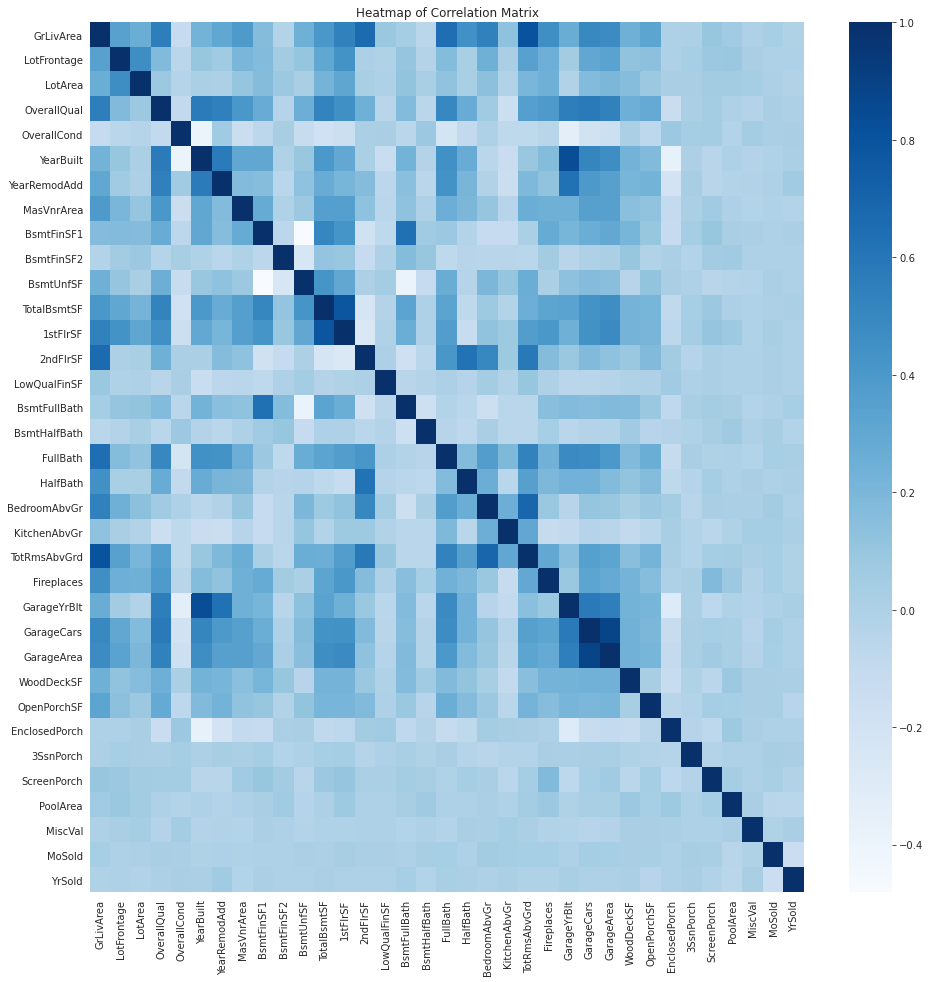

In [24]:
corr=df_train.corr()
plt.figure(figsize = (16, 16))
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values, cmap="Blues")

plt.title('Heatmap of Correlation Matrix')
corr

In [25]:
high_corr_pairs = np.where(abs(corr) > 0.7)
high_corr_pairs = [(corr.index[x], corr.columns[y]) for x, y in zip(*high_corr_pairs)
                                        if x != y and x < y]
high_corr_pairs

[('GrLivArea', 'TotRmsAbvGrd'),
 ('YearBuilt', 'GarageYrBlt'),
 ('TotalBsmtSF', '1stFlrSF'),
 ('GarageCars', 'GarageArea')]

### Per the data description, 
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

TotalBsmtSF=BsmtFinSF1+BsmtFinSF2+BsmtUnfSF

GrLivArea=1stFlrSF+2ndFlrSF+LowQualFinSF

In [26]:
#Dropping numerical columns of which have high correaltion with one another
df_train=df_train.drop(["TotRmsAbvGrd","GarageYrBlt","GarageArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","1stFlrSF","2ndFlrSF","LowQualFinSF"],axis=1)

## Data Inputation

### Categorical

In [27]:
#Show all column names with missing values
df_train.columns[df_train.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

In [28]:
#Show all categorical/object columns with missing values
df_train.select_dtypes("object").isna().sum()!=0

MSSubClass       False
MSZoning         False
Street           False
Alley             True
LotShape         False
LandContour      False
Utilities        False
LotConfig        False
LandSlope        False
Neighborhood     False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
RoofStyle        False
RoofMatl         False
Exterior1st      False
Exterior2nd      False
MasVnrType        True
ExterQual        False
ExterCond        False
Foundation       False
BsmtQual          True
BsmtCond          True
BsmtExposure      True
BsmtFinType1      True
BsmtFinType2      True
Heating          False
HeatingQC        False
CentralAir       False
Electrical        True
KitchenQual      False
Functional       False
FireplaceQu       True
GarageType        True
GarageFinish      True
GarageQual        True
GarageCond        True
PavedDrive       False
PoolQC            True
Fence             True
MiscFeature       True
SaleType         False
SaleConditi

In [29]:
#Fill NAs in these columns with None when a missing value means something
#e.g. NA basement means no basement

for column in ["Alley",
               "BsmtQual",
               "BsmtCond",
               "BsmtExposure",
               "BsmtFinType1",
               "BsmtFinType2",
               "FireplaceQu",
               "GarageType",
               "GarageFinish",
               "GarageQual",
               "GarageCond",
               "PoolQC",
               "Fence",
               "MiscFeature"]:
    df_train[column]=df_train[column].fillna("None")

In [30]:
#Fill NAs in these columns with mode
for column in ["MasVnrType","Electrical"]:
    df_train[column]=df_train[column].fillna(df_train[column].mode()[0])

In [31]:
df_train.select_dtypes("object").isna().sum()

MSSubClass       0
MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
dtype: int64

## Numerical

In [32]:
df_train.select_dtypes("number").isna().sum()

GrLivArea          0
LotFrontage      462
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        14
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
Fireplaces         0
GarageCars         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [33]:
#Show all numeric columns with missing values
df_train.select_dtypes("number").isna().sum()!=0

GrLivArea        False
LotFrontage       True
LotArea          False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
MasVnrArea        True
TotalBsmtSF       True
BsmtFullBath      True
BsmtHalfBath      True
FullBath         False
HalfBath         False
BedroomAbvGr     False
KitchenAbvGr     False
Fireplaces       False
GarageCars        True
WoodDeckSF       False
OpenPorchSF      False
EnclosedPorch    False
3SsnPorch        False
ScreenPorch      False
PoolArea         False
MiscVal          False
MoSold           False
YrSold           False
dtype: bool

In [34]:
#Fill NAs in these columns with mean
for column in ["MasVnrArea","TotalBsmtSF"]:
    df_train[column]=df_train[column].fillna(df_train[column].mean())

In [35]:
#Fill NAs in these columns with median because it's more approirate 
#i.e. number of bathrooms/cars in interger 
for column in ["BsmtFullBath","BsmtHalfBath","GarageCars"]:
    df_train[column]=df_train[column].fillna(df_train[column].median())

In [36]:
df_train.groupby("Neighborhood").LotFrontage.median()

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.5
ClearCr    81.0
CollgCr    70.0
Crawfor    70.0
Edwards    65.0
Gilbert    63.0
Greens     40.0
GrnHill     NaN
IDOTRR     60.0
Landmrk     NaN
MeadowV    21.0
Mitchel    72.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    89.0
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    70.0
Somerst    72.0
StoneBr    60.0
Timber     81.0
Veenker    80.0
Name: LotFrontage, dtype: float64

In [37]:
df_train.loc[df_train["Neighborhood"].isin(['Landmrk','GrnHill'])]

GrLivArea MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
110       1502        120       RM          NaN     9763   Pave  None   
684       1295        120       RM          NaN     8239   Pave  None   
205       1320        160       RH          NaN     3612   Pave  None   

    LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
110      IR1         Lvl    AllPub    Inside       Gtl      GrnHill   
684      IR1         Lvl    AllPub    Inside       Gtl      GrnHill   
205      IR1         Lvl    AllPub    Inside       Gtl      Landmrk   

    Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
110       Norm       Norm   TwnhsE     1Story            7            5   
684       Norm       Norm   TwnhsE     1Story            7            5   
205       Norm       Norm    Twnhs     2Story            6            5   

     YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
110       1998          1998     Gable  CompShg     Wd Sdng     Wd Sdng   
684       1986          1986     Gable  CompShg     BrkFace     Wd Sdng   
205       1993          1994     Gable  CompShg     VinylSd     VinylSd   

    MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
110    BrkFace       239.0        Gd        TA      PConc       Gd       TA   
684       None         0.0        Gd        TA     CBlock     None     None   
205       None         0.0        TA        TA      PConc       Gd       TA   

    BsmtExposure BsmtFinType1 BsmtFinType2  TotalBsmtSF Heating HeatingQC  \
110           No          GLQ          ALQ       1502.0    GasA        Ex   
684         None         None         None          0.0    GasA        Gd   
205           No          GLQ          Unf        630.0    GasA        Ex   

    CentralAir Electrical  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
110          Y      SBrkr           1.0           0.0         1         1   
684          Y      SBrkr           0.0           0.0         2         0   
205          Y      SBrkr           0.0           0.0         2         1   

     BedroomAbvGr  KitchenAbvGr KitchenQual Functional  Fireplaces  \
110             1             1          Gd        Typ           1   
684             2             1          Gd        Typ           0   
205             3             1          TA        Typ           0   

    FireplaceQu GarageType GarageFinish  GarageCars GarageQual GarageCond  \
110          TA     Attchd          Fin         1.0         TA         TA   
684        None     Attchd          RFn         1.0         TA         TA   
205        None     Detchd          Unf         2.0         TA         TA   

    PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
110          Y           0            0              0          0   
684          Y           0            0              0          0   
205          Y           0           48              0          0   

     ScreenPorch  PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold  \
110            0         0   None   None        None        0       9    2007   
684            0         0   None   None        None        0      11    2006   
205            0         0   None  MnPrv        None        0       6    2006   

    SaleType SaleCondition  
110      WD         Normal  
684      WD         Normal  
205      WD         Normal

In [38]:
#Impute missing values in LotFrontage with the median by Neighborhood 
df_train["LotFrontage"] = df_train["LotFrontage"].fillna(df_train.groupby("Neighborhood")['LotFrontage'].transform('median'))

In [39]:
#Fill the remaining 3NAs of LotFrontage with the Median of all LotFrontage
df_train["LotFrontage"]=df_train["LotFrontage"].fillna(df_train["LotFrontage"].median())

In [40]:
df_train.select_dtypes("number").isna().sum()

GrLivArea        0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
TotalBsmtSF      0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
Fireplaces       0
GarageCars       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

In [41]:
df_train.isna().sum()
#Check if there're still any missing values

GrLivArea        0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageCars  

In [42]:
num_cols=['ID','goal','pledged','backers',
          'usd pledged','usd_pledged_real','usd_goal_real',
          'duration_in_days','percent_pledged']

In [43]:
cat_cols=['name','category',
 'main_category',
 'currency',
 'deadline',
 'launched',
 'state',
 'country']

## Summarize numberical and categorical variables separately

In [44]:
df_train.describe(include=[np.number])

GrLivArea  LotFrontage        LotArea  OverallQual  OverallCond  \
count  2580.000000  2580.000000    2580.000000  2580.000000  2580.000000   
mean   1486.039922    68.868798   10120.153488     6.046124     5.618605   
std     488.650181    21.134646    8126.937892     1.367590     1.122008   
min     334.000000    21.000000    1300.000000     1.000000     1.000000   
25%    1112.000000    60.000000    7406.750000     5.000000     5.000000   
50%    1436.000000    70.000000    9391.000000     6.000000     5.000000   
75%    1733.000000    80.000000   11494.000000     7.000000     6.000000   
max    4676.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea  TotalBsmtSF  BsmtFullBath  \
count  2580.000000   2580.000000  2580.000000  2580.000000   2580.000000   
mean   1970.313953   1983.751938    99.308262  1036.686700      0.434884   
std      29.719705     20.490242   175.394322   418.474262      0.518768   
min    1872.000000   1950.000000     0.000000     0.000000      0.000000   
25%    1953.000000   1965.000000     0.000000   792.000000      0.000000   
50%    1972.000000   1992.000000     0.000000   979.500000      0.000000   
75%    1999.000000   2003.000000   157.000000  1266.250000      1.000000   
max    2010.000000   2010.000000  1600.000000  3206.000000      3.000000   

       BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr  \
count   2580.000000  2580.000000  2580.000000   2580.000000    2580.00000   
mean       0.062016     1.550775     0.378295      2.850388       1.04031   
std        0.244424     0.545825     0.499237      0.822863       0.20255   
min        0.000000     0.000000     0.000000      0.000000       0.00000   
25%        0.000000     1.000000     0.000000      2.000000       1.00000   
50%        0.000000     2.000000     0.000000      3.000000       1.00000   
75%        0.000000     2.000000     1.000000      3.000000       1.00000   
max        2.000000     4.000000     2.000000      6.000000       3.00000   

        Fireplaces   GarageCars   WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count  2580.000000  2580.000000  2580.000000  2580.000000    2580.000000   
mean      0.604264     1.747674    95.919767    46.085271      23.214341   
std       0.648604     0.738551   129.052016    66.060664      64.107825   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       0.000000     1.000000     0.000000     0.000000       0.000000   
50%       1.000000     2.000000     0.000000    25.500000       0.000000   
75%       1.000000     2.000000   168.000000    68.000000       0.000000   
max       4.000000     5.000000  1424.000000   742.000000    1012.000000   

         3SsnPorch  ScreenPorch     PoolArea       MiscVal       MoSold  \
count  2580.000000  2580.000000  2580.000000   2580.000000  2580.000000   
mean      2.511240    16.200388     1.662016     48.731395     6.150775   
std      25.293935    56.824783    30.339396    498.725058     2.670647   
min       0.000000     0.000000     0.000000      0.000000     1.000000   
25%       0.000000     0.000000     0.000000      0.000000     4.000000   
50%       0.000000     0.000000     0.000000      0.000000     6.000000   
75%       0.000000     0.000000     0.000000      0.000000     8.000000   
max     508.000000   576.000000   800.000000  15500.000000    12.000000   

            YrSold  
count  2580.000000  
mean   2007.838372  
std       1.312333  
min    2006.000000  
25%    2007.000000  
50%    2008.000000  
75%    2009.000000  
max    2010.000000

In [45]:
df_train.describe(include=['O']) #The 'O' stands for objects

MSSubClass MSZoning Street Alley LotShape LandContour Utilities  \
count        2580     2580   2580  2580     2580        2580      2580   
unique         16        7      2     3        4           4         2   
top            20       RL   Pave  None      Reg         Lvl    AllPub   
freq          939     2008   2570  2412     1641        2337      2578   

       LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
count       2580      2580         2580       2580       2580     2580   
unique         5         3           28          9          8        5   
top       Inside       Gtl        NAmes       Norm       Norm     1Fam   
freq        1886      2458          410       2228       2555     2139   

       HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
count        2580      2580     2580        2580        2580       2580   
unique          8         6        7          15          16          4   
top        1Story     Gable  CompShg     VinylSd     VinylSd       None   
freq         1288      2059     2544         868         856       1573   

       ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
count       2580      2580       2580     2580     2580         2580   
unique         4         5          6        6        6            5   
top           TA        TA     CBlock       TA       TA           No   
freq        1636      2232       1140     1166     2316         1708   

       BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical  \
count          2580         2580    2580      2580       2580       2580   
unique            7            7       6         5          2          4   
top             GLQ          Unf    GasA        Ex          Y      SBrkr   
freq            753         2180    2540      1293       2417       2366   

       KitchenQual Functional FireplaceQu GarageType GarageFinish GarageQual  \
count         2580       2580        2580       2580         2580       2580   
unique           5          7           6          7            4          6   
top             TA        Typ        None     Attchd          Unf         TA   
freq          1358       2399        1241       1527         1112       2312   

       GarageCond PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  
count        2580       2580   2580  2580        2580     2580          2580  
unique          6          3      5     5           5       10             6  
top            TA          Y   None  None        None      WD         Normal  
freq         2356       2336   2571  2055        2483     2392          2414

# Feature Transformations

In [46]:
df_train.select_dtypes("number")

GrLivArea  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
1          856         60.0     7890            6            6       1939   
2         1049         42.0     4235            5            5       1984   
3         1001         60.0     6060            5            9       1930   
4         1039         80.0     8146            4            8       1900   
5         1665         70.0     8400            8            6       2001   
..         ...          ...      ...          ...          ...        ...   
759        952         51.5     8854            6            6       1916   
760       1733         65.0    13680            3            5       1955   
761       2002         82.0     6270            5            6       1949   
762       1842         70.0     8826            7            5       2000   
763       1911         80.0     9554            8            5       1993   

     YearRemodAdd  MasVnrArea  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  \
1            1950         0.0        856.0           1.0           0.0   
2            1984       149.0       1049.0           1.0           0.0   
3            2007         0.0        837.0           0.0           0.0   
4            2003         0.0        405.0           0.0           0.0   
5            2001         0.0        810.0           1.0           0.0   
..            ...         ...          ...           ...           ...   
759          1950         0.0        952.0           0.0           0.0   
760          1955         0.0          0.0           0.0           0.0   
761          1950         0.0       1001.0           0.0           0.0   
762          2000       144.0        985.0           1.0           0.0   
763          1994       125.0        777.0           0.0           0.0   

     FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  Fireplaces  GarageCars  \
1           1         0             2             1           1         2.0   
2           2         0             2             1           0         1.0   
3           1         0             2             1           0         1.0   
4           1         0             2             1           0         1.0   
5           2         1             3             1           0         2.0   
..        ...       ...           ...           ...         ...         ...   
759         1         0             2             1           1         1.0   
760         2         0             4             1           1         2.0   
761         2         0             4             2           0         3.0   
762         2         1             3             1           1         2.0   
763         2         1             3             1           1         2.0   

     WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
1             0            0              0          0          166         0   
2             0          105              0          0            0         0   
3           154            0             42         86            0         0   
4             0            0            168          0          111         0   
5             0           45              0          0            0         0   
..          ...          ...            ...        ...          ...       ...   
759           0           98              0          0           40         0   
760           0            0              0          0            0         0   
761           0            0              0          0            0         0   
762         193           96              0          0            0         0   
763         182           81              0          0            0         0   

     MiscVal  MoSold  YrSold  
1          0       3    2010  
2          0       2    2009  
3          0      11    2007  
4          0       5    2009  
5          0      11    2009  
..       ...     ...     ...  
759        0       5    2009  
760        0       6 

In [47]:
numeric_cols=df_train.select_dtypes("number").columns

In [48]:
numeric_cols=pd.DataFrame(numeric_cols,columns=["Features"])

In [49]:
numeric_cols

Features
0       GrLivArea
1     LotFrontage
2         LotArea
3     OverallQual
4     OverallCond
5       YearBuilt
6    YearRemodAdd
7      MasVnrArea
8     TotalBsmtSF
9    BsmtFullBath
10   BsmtHalfBath
11       FullBath
12       HalfBath
13   BedroomAbvGr
14   KitchenAbvGr
15     Fireplaces
16     GarageCars
17     WoodDeckSF
18    OpenPorchSF
19  EnclosedPorch
20      3SsnPorch
21    ScreenPorch
22       PoolArea
23        MiscVal
24         MoSold
25         YrSold

In [50]:
scipy.stats.skew(df_train.select_dtypes("number"))

array([ 0.97949483,  1.13817613, 13.06594054,  0.18699771,  0.62435313,
       -0.59782952, -0.43714372,  2.67125462,  0.51494657,  0.52862064,
        3.7903816 ,  0.20599242,  0.66962427,  0.25366172,  4.5286104 ,
        0.73477173, -0.19127454,  1.84594824,  2.6037833 ,  4.03944974,
       11.82338566,  3.98830739, 19.8851274 , 21.27686429,  0.23279759,
        0.09292702])

In [51]:
numeric_cols["Skewness"]=scipy.stats.skew(df_train.select_dtypes("number"))
df_skew=numeric_cols.copy()
df_skew
#0 means no skew and normally distributed
#+ve number means right skew
#-ve number means left skew

Features   Skewness
0       GrLivArea   0.979495
1     LotFrontage   1.138176
2         LotArea  13.065941
3     OverallQual   0.186998
4     OverallCond   0.624353
5       YearBuilt  -0.597830
6    YearRemodAdd  -0.437144
7      MasVnrArea   2.671255
8     TotalBsmtSF   0.514947
9    BsmtFullBath   0.528621
10   BsmtHalfBath   3.790382
11       FullBath   0.205992
12       HalfBath   0.669624
13   BedroomAbvGr   0.253662
14   KitchenAbvGr   4.528610
15     Fireplaces   0.734772
16     GarageCars  -0.191275
17     WoodDeckSF   1.845948
18    OpenPorchSF   2.603783
19  EnclosedPorch   4.039450
20      3SsnPorch  11.823386
21    ScreenPorch   3.988307
22       PoolArea  19.885127
23        MiscVal  21.276864
24         MoSold   0.232798
25         YrSold   0.092927

In [52]:
df_skew["Absolute_Skew"]=np.abs(df_skew["Skewness"])

In [53]:
df_skew

Features   Skewness  Absolute_Skew
0       GrLivArea   0.979495       0.979495
1     LotFrontage   1.138176       1.138176
2         LotArea  13.065941      13.065941
3     OverallQual   0.186998       0.186998
4     OverallCond   0.624353       0.624353
5       YearBuilt  -0.597830       0.597830
6    YearRemodAdd  -0.437144       0.437144
7      MasVnrArea   2.671255       2.671255
8     TotalBsmtSF   0.514947       0.514947
9    BsmtFullBath   0.528621       0.528621
10   BsmtHalfBath   3.790382       3.790382
11       FullBath   0.205992       0.205992
12       HalfBath   0.669624       0.669624
13   BedroomAbvGr   0.253662       0.253662
14   KitchenAbvGr   4.528610       4.528610
15     Fireplaces   0.734772       0.734772
16     GarageCars  -0.191275       0.191275
17     WoodDeckSF   1.845948       1.845948
18    OpenPorchSF   2.603783       2.603783
19  EnclosedPorch   4.039450       4.039450
20      3SsnPorch  11.823386      11.823386
21    ScreenPorch   3.988307       3.988307
22       PoolArea  19.885127      19.885127
23        MiscVal  21.276864      21.276864
24         MoSold   0.232798       0.232798
25         YrSold   0.092927       0.092927

In [54]:
df_skew["Skewed"]=np.where(df_skew['Absolute_Skew'] > 0.75, True, False)

In [55]:
#Looks like half of the features are skewed.... (Absolute Skew>0.75)
df_skew.sort_values("Absolute_Skew")

Features   Skewness  Absolute_Skew  Skewed
25         YrSold   0.092927       0.092927   False
3     OverallQual   0.186998       0.186998   False
16     GarageCars  -0.191275       0.191275   False
11       FullBath   0.205992       0.205992   False
24         MoSold   0.232798       0.232798   False
13   BedroomAbvGr   0.253662       0.253662   False
6    YearRemodAdd  -0.437144       0.437144   False
8     TotalBsmtSF   0.514947       0.514947   False
9    BsmtFullBath   0.528621       0.528621   False
5       YearBuilt  -0.597830       0.597830   False
4     OverallCond   0.624353       0.624353   False
12       HalfBath   0.669624       0.669624   False
15     Fireplaces   0.734772       0.734772   False
0       GrLivArea   0.979495       0.979495    True
1     LotFrontage   1.138176       1.138176    True
17     WoodDeckSF   1.845948       1.845948    True
18    OpenPorchSF   2.603783       2.603783    True
7      MasVnrArea   2.671255       2.671255    True
10   BsmtHalfBath   3.790382       3.790382    True
21    ScreenPorch   3.988307       3.988307    True
19  EnclosedPorch   4.039450       4.039450    True
14   KitchenAbvGr   4.528610       4.528610    True
20      3SsnPorch  11.823386      11.823386    True
2         LotArea  13.065941      13.065941    True
22       PoolArea  19.885127      19.885127    True
23        MiscVal  21.276864      21.276864    True

In [56]:
df_skew[df_skew.Skewed==True].Features.values
#get all the features which are skewed

array(['GrLivArea', 'LotFrontage', 'LotArea', 'MasVnrArea',
       'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype=object)

In [57]:
df_skew[df_skew.Skewed==True].Features

0         GrLivArea
1       LotFrontage
2           LotArea
7        MasVnrArea
10     BsmtHalfBath
14     KitchenAbvGr
17       WoodDeckSF
18      OpenPorchSF
19    EnclosedPorch
20        3SsnPorch
21      ScreenPorch
22         PoolArea
23          MiscVal
Name: Features, dtype: object

In [58]:
#Check to see how those skewed columns are distributed
df_train[df_skew[df_skew.Skewed==True].Features.values].describe()

GrLivArea  LotFrontage        LotArea   MasVnrArea  BsmtHalfBath  \
count  2580.000000  2580.000000    2580.000000  2580.000000   2580.000000   
mean   1486.039922    68.868798   10120.153488    99.308262      0.062016   
std     488.650181    21.134646    8126.937892   175.394322      0.244424   
min     334.000000    21.000000    1300.000000     0.000000      0.000000   
25%    1112.000000    60.000000    7406.750000     0.000000      0.000000   
50%    1436.000000    70.000000    9391.000000     0.000000      0.000000   
75%    1733.000000    80.000000   11494.000000   157.000000      0.000000   
max    4676.000000   313.000000  215245.000000  1600.000000      2.000000   

       KitchenAbvGr   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count    2580.00000  2580.000000  2580.000000    2580.000000  2580.000000   
mean        1.04031    95.919767    46.085271      23.214341     2.511240   
std         0.20255   129.052016    66.060664      64.107825    25.293935   
min         0.00000     0.000000     0.000000       0.000000     0.000000   
25%         1.00000     0.000000     0.000000       0.000000     0.000000   
50%         1.00000     0.000000    25.500000       0.000000     0.000000   
75%         1.00000   168.000000    68.000000       0.000000     0.000000   
max         3.00000  1424.000000   742.000000    1012.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal  
count  2580.000000  2580.000000   2580.000000  
mean     16.200388     1.662016     48.731395  
std      56.824783    30.339396    498.725058  
min       0.000000     0.000000      0.000000  
25%       0.000000     0.000000      0.000000  
50%       0.000000     0.000000      0.000000  
75%       0.000000     0.000000      0.000000  
max     576.000000   800.000000  15500.000000

In [59]:
df_before_feature_transformed=df_train.copy()

In [60]:
df_skewed_features=df_train[df_skew[df_skew.Skewed==True].Features.values]
df_skewed_features

GrLivArea  LotFrontage  LotArea  MasVnrArea  BsmtHalfBath  KitchenAbvGr  \
1          856         60.0     7890         0.0           0.0             1   
2         1049         42.0     4235       149.0           0.0             1   
3         1001         60.0     6060         0.0           0.0             1   
4         1039         80.0     8146         0.0           0.0             1   
5         1665         70.0     8400         0.0           0.0             1   
..         ...          ...      ...         ...           ...           ...   
759        952         51.5     8854         0.0           0.0             1   
760       1733         65.0    13680         0.0           0.0             1   
761       2002         82.0     6270         0.0           0.0             2   
762       1842         70.0     8826       144.0           0.0             1   
763       1911         80.0     9554       125.0           0.0             1   

     WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
1             0            0              0          0          166         0   
2             0          105              0          0            0         0   
3           154            0             42         86            0         0   
4             0            0            168          0          111         0   
5             0           45              0          0            0         0   
..          ...          ...            ...        ...          ...       ...   
759           0           98              0          0           40         0   
760           0            0              0          0            0         0   
761           0            0              0          0            0         0   
762         193           96              0          0            0         0   
763         182           81              0          0            0         0   

     MiscVal  
1          0  
2          0  
3          0  
4          0  
5          0  
..       ...  
759        0  
760        0  
761        0  
762        0  
763        0  

[2580 rows x 13 columns]

In [61]:
lam = 0.15
for col in df_skewed_features.columns:
    df_train[col]=boxcox1p(df_train[col], lam)

In [62]:
numeric_cols["Skewness"]=scipy.stats.skew(df_train.select_dtypes("number"))
df_skew=numeric_cols.copy()
df_skew["Absolute_Skew"]=np.abs(df_skew["Skewness"])
df_skew["Skewed"]=np.where(df_skew['Absolute_Skew'] > 0.75, True, False)
df_skew.sort_values("Absolute_Skew",ascending=False)
#The number of skewed feaetures has gone down from 13 to 8
#after the BoxCox1p transformation

Features   Skewness  Absolute_Skew  Skewed
22       PoolArea  17.196323      17.196323    True
20      3SsnPorch   9.289242       9.289242    True
23        MiscVal   5.390692       5.390692    True
14   KitchenAbvGr   4.008220       4.008220    True
10   BsmtHalfBath   3.706005       3.706005    True
21    ScreenPorch   2.980675       2.980675    True
19  EnclosedPorch   2.006053       2.006053    True
1     LotFrontage  -0.821385       0.821385    True
15     Fireplaces   0.734772       0.734772   False
12       HalfBath   0.669624       0.669624   False
7      MasVnrArea   0.631862       0.631862   False
4     OverallCond   0.624353       0.624353   False
5       YearBuilt  -0.597830       0.597830   False
9    BsmtFullBath   0.528621       0.528621   False
8     TotalBsmtSF   0.514947       0.514947   False
6    YearRemodAdd  -0.437144       0.437144   False
13   BedroomAbvGr   0.253662       0.253662   False
24         MoSold   0.232798       0.232798   False
2         LotArea   0.218515       0.218515   False
17     WoodDeckSF   0.209432       0.209432   False
11       FullBath   0.205992       0.205992   False
16     GarageCars  -0.191275       0.191275   False
3     OverallQual   0.186998       0.186998   False
18    OpenPorchSF   0.123162       0.123162   False
25         YrSold   0.092927       0.092927   False
0       GrLivArea   0.090755       0.090755   False

## Transform Months/Cyclincal Features With Cosign Wave 

In [63]:
df_train.MoSold.value_counts().index.sort_values() #Month Sold
#It's cyclical. However, models may not be able to tell 

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

In [64]:
#A negative cosine wave (y=-cos(x)) can represent this pattern, 
#where month 1 and month 12 are similar and start from the same point
#high values mean hot and low values mean cold
#-cos(0.5x)

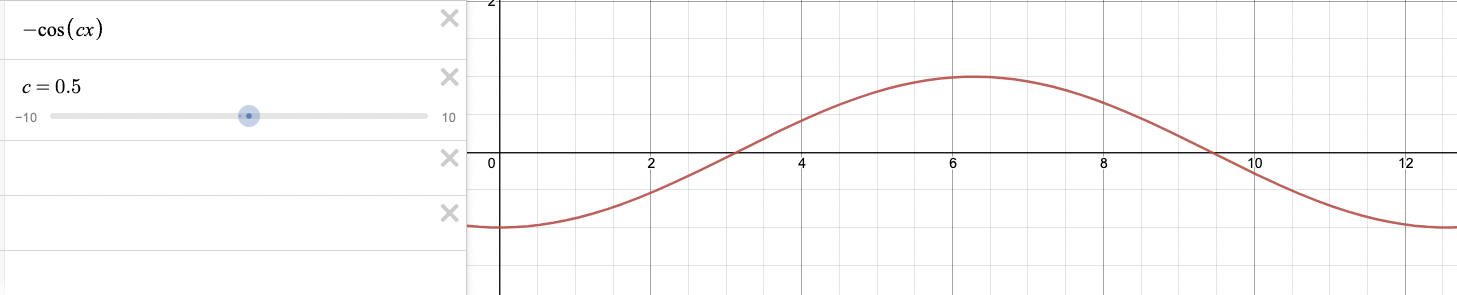

In [65]:
-np.cos(0.5*df_train.MoSold)

1     -0.070737
2     -0.540302
3     -0.708670
4      0.801144
5     -0.708670
         ...   
759    0.801144
760    0.989992
761    0.653644
762    0.936457
763    0.210796
Name: MoSold, Length: 2580, dtype: float64

In [66]:
(-np.cos(0.5*df_train.MoSold)).describe()
#after the transformation, the min is closed to -1 and the max is closed to 1

count    2580.000000
mean        0.388439
std         0.635138
min        -0.960170
25%        -0.070737
50%         0.653644
75%         0.936457
max         0.989992
Name: MoSold, dtype: float64

In [67]:
df_train.MoSold=-np.cos(0.5*df_train.MoSold)

# Encode Categoical Columns (after ensuring the dtype of those columns is string)

In [68]:
df_train=pd.get_dummies(df_train, drop_first=True)

In [69]:
df_train

GrLivArea  LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
1    11.692623     5.684507  18.947401            6            6       1939   
2    12.260567     5.053371  16.665342            5            5       1984   
3    12.128185     5.684507  17.953466            5            9       1930   
4    12.233418     6.221214  19.070362            4            8       1900   
5    13.617632     5.968981  19.189158            8            6       2001   
..         ...          ...        ...          ...          ...        ...   
759  11.987364     5.409598  19.394090            6            6       1916   
760  13.739720     5.831328  21.151366            3            5       1955   
761  14.185966     6.268453  18.079576            5            6       1949   
762  13.927183     5.968981  19.381713            7            5       2000   
763  14.041036     6.221214  19.693208            8            5       1993   

     YearRemodAdd  MasVnrArea  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  \
1            1950    0.000000        856.0           1.0           0.0   
2            1984    7.469200       1049.0           1.0           0.0   
3            2007    0.000000        837.0           0.0           0.0   
4            2003    0.000000        405.0           0.0           0.0   
5            2001    0.000000        810.0           1.0           0.0   
..            ...         ...          ...           ...           ...   
759          1950    0.000000        952.0           0.0           0.0   
760          1955    0.000000          0.0           0.0           0.0   
761          1950    0.000000       1001.0           0.0           0.0   
762          2000    7.397498        985.0           1.0           0.0   
763          1994    7.104297        777.0           0.0           0.0   

     FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  Fireplaces  GarageCars  \
1           1         0             2      0.730463           1         2.0   
2           2         0             2      0.730463           0         1.0   
3           1         0             2      0.730463           0         1.0   
4           1         0             2      0.730463           0         1.0   
5           2         1             3      0.730463           0         2.0   
..        ...       ...           ...           ...         ...         ...   
759         1         0             2      0.730463           1         1.0   
760         2         0             4      0.730463           1         2.0   
761         2         0             4      1.194318           0         3.0   
762         2         1             3      0.730463           1         2.0   
763         2         1             3      0.730463           1         2.0   

     WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
1      0.000000     0.000000       0.000000     0.0000     7.698683       0.0   
2      0.000000     6.751853       0.000000     0.0000     0.000000       0.0   
3      7.538898     0.000000       5.053371     6.3601     0.000000       0.0   
4      0.000000     0.000000       7.724359     0.0000     6.863135       0.0   
5      0.000000     5.172535       0.000000     0.0000     0.000000       0.0   
..          ...          ...            ...        ...          ...       ...   
759    0.000000     6.615044       0.000000     0.0000     4.969939       0.0   
760    0.000000     0.000000       0.000000     0.0000     0.000000       0.0   
761    0.000000     0.000000       0.000000     0.0000     0.000000       0.0   
762    8.025268     6.574447       0.000000     0.0000     0.000000       0.0   
763    7.897190     6.244956       0.000000     0.0000     0.000000       0.0   

     MiscVal    MoSold  YrSold  MSSubClass_150  MSSubClass_160  \
1        0.0 -0.070737    2010               0               0   
2        0.0 -0.540302    2009               0               0   
3        0.0 -0.708670    2007               0 

# Standardization/Standard Scaling

In [70]:
standard=StandardScaler() #give each column the same range of values and centered around 0
standard.fit(df_train)
df_train=pd.DataFrame(standard.transform(df_train), index=df_train.index, columns=df_train.columns)

In [71]:
df_train

GrLivArea  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
1    -1.514117    -0.291069 -0.256266    -0.033733     0.339988  -1.053847   
2    -0.921493    -1.333520 -1.394813    -0.765088    -0.551444   0.460593   
3    -1.059627    -0.291069 -0.752152    -0.765088     3.014285  -1.356735   
4    -0.949821     0.595413 -0.194919    -1.496443     2.122852  -2.366362   
5     0.494543     0.178798 -0.135650     1.428977     0.339988   1.032715   
..         ...          ...       ...          ...          ...        ...   
759  -1.206568    -0.745137 -0.033407    -0.033733     0.339988  -1.827894   
760   0.621936    -0.048564  0.843320    -2.227798    -0.551444  -0.515379   
761   1.087574     0.673439 -0.689235    -0.765088     0.339988  -0.717305   
762   0.817546     0.178798 -0.039582     0.697622    -0.551444   0.999061   
763   0.936346     0.595413  0.115827     1.428977    -0.551444   0.763481   

     YearRemodAdd  MasVnrArea  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  \
1       -1.647539   -0.780921    -0.431859      1.089555      -0.25474   
2        0.012109    1.044115     0.029430      1.089555      -0.25474   
3        1.134812   -0.780921    -0.477270     -0.838464      -0.25474   
4        0.939559   -0.780921    -1.509792     -0.838464      -0.25474   
5        0.841933   -0.780921    -0.541803      1.089555      -0.25474   
..            ...         ...          ...           ...           ...   
759     -1.647539   -0.780921    -0.202409     -0.838464      -0.25474   
760     -1.403473   -0.780921    -2.477781     -0.838464      -0.25474   
761     -1.647539   -0.780921    -0.085295     -0.838464      -0.25474   
762      0.793120    1.026596    -0.123536      1.089555      -0.25474   
763      0.500240    0.954954    -0.620676     -0.838464      -0.25474   

     FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  Fireplaces  GarageCars  \
1   -1.009265 -0.757892     -1.033650     -0.194425    0.610254    0.341716   
2    0.823179 -0.757892     -1.033650     -0.194425   -0.931817   -1.012549   
3   -1.009265 -0.757892     -1.033650     -0.194425   -0.931817   -1.012549   
4   -1.009265 -0.757892     -1.033650     -0.194425   -0.931817   -1.012549   
5    0.823179  1.245552      0.181855     -0.194425   -0.931817    0.341716   
..        ...       ...           ...           ...         ...         ...   
759 -1.009265 -0.757892     -1.033650     -0.194425    0.610254   -1.012549   
760  0.823179 -0.757892      1.397359     -0.194425    0.610254    0.341716   
761  0.823179 -0.757892      1.397359      4.694720   -0.931817    1.695980   
762  0.823179  1.245552      0.181855     -0.194425    0.610254    0.341716   
763  0.823179  1.245552      0.181855     -0.194425    0.610254    0.341716   

     WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
1     -0.941444    -1.040546      -0.426658  -0.107786     3.162487 -0.058717   
2     -0.941444     1.134955      -0.426658  -0.107786    -0.308021 -0.058717   
3      0.947157    -1.040546       1.479177   7.159042    -0.308021 -0.058717   
4     -0.941444    -1.040546       2.486517  -0.107786     2.785828 -0.058717   
5     -0.941444     0.626086      -0.426658  -0.107786    -0.308021 -0.058717   
..          ...          ...            ...        ...          ...       ...   
759   -0.941444     1.090874      -0.426658  -0.107786     1.932390 -0.058717   
760   -0.941444    -1.040546      -0.426658  -0.107786    -0.308021 -0.058717   
761   -0.941444    -1.040546      -0.426658  -0.107786    -0.308021 -0.058717   
762    1.068999     1.077793      -0.426658  -0.107786    -0.308021 -0.058717   
763    1.036914     0.971629      -0.426658  -0.107786    -0.308021 -0.058717   

      MiscVal    MoSold    YrSold  MSSubClass_150  MSSubClass_160  \
1   -0.190696 -0.723096  1.647483       -0.019691       -0.220863   
2   -0.190696 -1.462551  0.885334       -0.019691       -0.220863   
3   -0.190696 -1.727690 -0.638965       -0.019691 

In [72]:
#In production, use pipeline to encode and standard scale
#pd.get_dummies(df_test)
#
#df_dummmied=pd.get_dummies()
#pipe = Pipeline(
#    [("standardize", StandardScaler()), ("df_dummmied", df_dummmied)])

# Target Transformation

<AxesSubplot:>

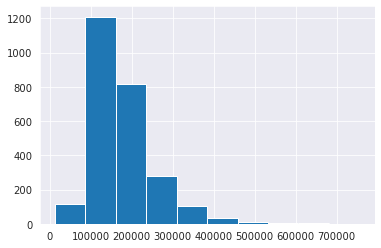

In [73]:
target.hist()
#the target Sale Price is right skewed

/home/jacquizz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jacquizz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


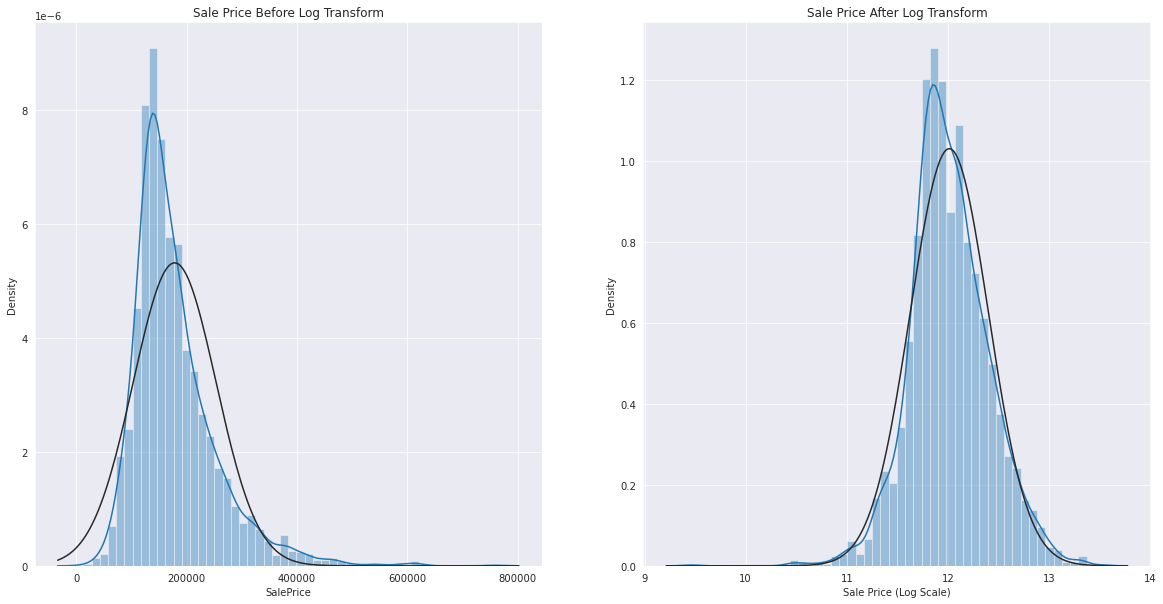

In [74]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title("Sale Price Before Log Transform")
sns.distplot(target,fit=scipy.stats.norm)
#the data's density plot does not lie up with a normal distrubtion very well

plt.subplot(1, 2, 2)
plt.title("Sale Price After Log Transform")
sns.distplot(np.log(target),fit=scipy.stats.norm)
plt.xlabel("Sale Price (Log Scale)")
#the data's density plot fits much better with a normal distrubtion after the log transmation
plt.show()

In [75]:
log_target=np.log(target)
#We're going to predict on the log Sale Price

In [76]:
#After making prediction with our modeals, 
#we need get back to the original Sale Price by exponentiating
np.exp(log_target)

1      126000.0
2      139500.0
3      124900.0
4      114000.0
5      227000.0
         ...   
759    121000.0
760    139600.0
761    145000.0
762    217500.0
763    215000.0
Name: SalePrice, Length: 2580, dtype: float64

# EDA/Multiple Linear Regression/No Cross Validation

In [77]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(df_train,log_target)

LinearRegression()

In [78]:
ols.intercept_

12.013473787587431

In [79]:
ols.coef_.shape #the number of elements match the number of columns 

(272,)

In [80]:
#str(np.round(ols.coef_, 3))

In [81]:
ols.score(df_train,log_target)

0.9451319417831148

# Modelling

In [82]:
homes_encoded = pd.read_csv("HousePrice_Encoded.csv")

In [83]:
df_train.head()

GrLivArea  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
1  -1.514117    -0.291069 -0.256266    -0.033733     0.339988  -1.053847   
2  -0.921493    -1.333520 -1.394813    -0.765088    -0.551444   0.460593   
3  -1.059627    -0.291069 -0.752152    -0.765088     3.014285  -1.356735   
4  -0.949821     0.595413 -0.194919    -1.496443     2.122852  -2.366362   
5   0.494543     0.178798 -0.135650     1.428977     0.339988   1.032715   

   YearRemodAdd  MasVnrArea  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  \
1     -1.647539   -0.780921    -0.431859      1.089555      -0.25474   
2      0.012109    1.044115     0.029430      1.089555      -0.25474   
3      1.134812   -0.780921    -0.477270     -0.838464      -0.25474   
4      0.939559   -0.780921    -1.509792     -0.838464      -0.25474   
5      0.841933   -0.780921    -0.541803      1.089555      -0.25474   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  Fireplaces  GarageCars  \
1 -1.009265 -0.757892     -1.033650     -0.194425    0.610254    0.341716   
2  0.823179 -0.757892     -1.033650     -0.194425   -0.931817   -1.012549   
3 -1.009265 -0.757892     -1.033650     -0.194425   -0.931817   -1.012549   
4 -1.009265 -0.757892     -1.033650     -0.194425   -0.931817   -1.012549   
5  0.823179  1.245552      0.181855     -0.194425   -0.931817    0.341716   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
1   -0.941444    -1.040546      -0.426658  -0.107786     3.162487 -0.058717   
2   -0.941444     1.134955      -0.426658  -0.107786    -0.308021 -0.058717   
3    0.947157    -1.040546       1.479177   7.159042    -0.308021 -0.058717   
4   -0.941444    -1.040546       2.486517  -0.107786     2.785828 -0.058717   
5   -0.941444     0.626086      -0.426658  -0.107786    -0.308021 -0.058717   

    MiscVal    MoSold    YrSold  MSSubClass_150  MSSubClass_160  \
1 -0.190696 -0.723096  1.647483       -0.019691       -0.220863   
2 -0.190696 -1.462551  0.885334       -0.019691       -0.220863   
3 -0.190696 -1.727690 -0.638965       -0.019691       -0.220863   
4 -0.190696  0.649913  0.885334       -0.019691       -0.220863   
5 -0.190696 -1.727690  0.885334       -0.019691       -0.220863   

   MSSubClass_180  MSSubClass_190  MSSubClass_20  MSSubClass_30  \
1       -0.076472       -0.144822      -0.756447       4.469408   
2       -0.076472       -0.144822      -0.756447      -0.223743   
3       -0.076472       -0.144822      -0.756447       4.469408   
4       -0.076472       -0.144822      -0.756447      -0.223743   
5       -0.076472       -0.144822      -0.756447      -0.223743   

   MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
1       -0.04828      -0.081442      -0.334051      -0.491506      -0.216974   
2       -0.04828      -0.081442      -0.334051      -0.491506      -0.216974   
3       -0.04828      -0.081442      -0.334051      -0.491506      -0.216974   
4       -0.04828      -0.081442      -0.334051      -0.491506       4.608837   
5       -0.04828      -0.081442      -0.334051       2.034562      -0.216974   

   MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
1      -0.090589      -0.210028      -0.130189      -0.186809   
2      -0.090589      -0.210028      -0.130189      -0.186809   
3      -0.090589      -0.210028      -0.130189      -0.186809   
4      -0.090589      -0.210028      -0.130189      -0.186809   
5      -0.090589      -0.210028      -0.130189      -0.186809   

   MSZoning_C (all)  MSZoning_FV  MSZoning_I (all)  MSZoning_RH  MSZoning_RL  \
1         -0.081442     -0.21402         -0.027853    -0.090589     0.533723   
2         -0.081442     -0.21402         -0.027853    -0.090589     0.533723   
3         12.278628     -0.21402         -0.027853    -0.090589    -1.873630   
4         -0.081442     -0.21402         -0.027853    -0.090589     0.533723   
5         -0.081442     -0.21402         -0.027853    -0.090589     0.533723   

   MSZoning_RM  

In [84]:
target.head()

1    126000
2    139500
3    124900
4    114000
5    227000
Name: SalePrice, dtype: int64

In [85]:
from sklearn.linear_model import LinearRegression

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   2.,   0.,   1.,   1.,   3.,   2.,   5.,
          5.,  15.,  35., 125., 284., 568., 655., 486., 242.,  92.,  28.,
         12.,   6.,   5.,   2.,   2.,   0.,   2.]),
 array([-1.3021196 , -1.25618047, -1.21024134, -1.16430221, -1.11836308,
        -1.07242395, -1.02648482, -0.98054569, -0.93460655, -0.88866742,
        -0.84272829, -0.79678916, -0.75085003, -0.7049109 , -0.65897177,
        -0.61303264, -0.5670935 , -0.52115437, -0.47521524, -0.42927611,
        -0.38333698, -0.33739785, -0.29145872, -0.24551958, -0.19958045,
        -0.15364132, -0.10770219, -0.06176306, -0.01582393,  0.0301152 ,
         0.07605433,  0.12199347,  0.1679326 ,  0.21387173,  0.25981086,
         0.30574999,  0.35168912,  0.39762825,  0.44356738,  0.48950652,
         0.53544565]),
 <BarContainer object of 40 artists>)

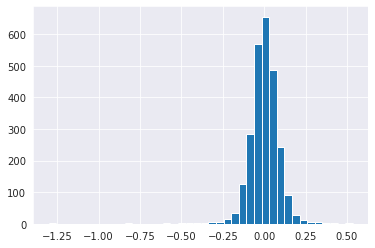

In [86]:
lm = LinearRegression()
lm.fit(df_train, log_target)
residuals = log_target - lm.predict(df_train)
plt.hist(residuals,bins=40)

In [87]:
print('R^2 is equal to %.6f' %(lm.score(df_train, log_target)))
print('RSS is equal to %.3f' %(np.sum(residuals**2)))
print('The intercept is %.3f' %(lm.intercept_))


R^2 is equal to 0.945132
RSS is equal to 21.229
The intercept is 12.013


In [88]:
import statsmodels.api as sm
x = sm.add_constant(df_train)
model = sm.OLS(log_target, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     149.8
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        07:32:39   Log-Likelihood:                 2531.4
No. Observations:                2580   AIC:                            -4529.
Df Residuals:                    2313   BIC:                            -2965.
Df Model:                         266                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    12.01

In [89]:
pValues = model.pvalues
sig = pValues[pValues<.05]
unsig = pValues[pValues>.05]

In [90]:
unsig

LotFrontage              0.726388
MasVnrArea               0.338941
BsmtHalfBath             0.050039
HalfBath                 0.084140
KitchenAbvGr             0.061670
OpenPorchSF              0.758252
EnclosedPorch            0.055808
3SsnPorch                0.445059
PoolArea                 0.141652
MiscVal                  0.554196
MSSubClass_150           0.205673
MSSubClass_180           0.280040
MSSubClass_190           0.954868
MSSubClass_20            0.859943
MSSubClass_30            0.517604
MSSubClass_40            0.860494
MSSubClass_45            0.635619
MSSubClass_50            0.679330
MSSubClass_60            0.450995
MSSubClass_70            0.856443
MSSubClass_75            0.638922
MSSubClass_80            0.194732
MSSubClass_85            0.773871
MSSubClass_90            0.147863
MSZoning_C (all)         0.076479
MSZoning_FV              0.716256
MSZoning_I (all)         0.601569
MSZoning_RH              0.749723
MSZoning_RL              0.781474
MSZoning_RM   

In [91]:
df_train_sig = df_train.copy()

In [92]:
list(sig.keys())

['const',
 'GrLivArea',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 'BsmtFullBath',
 'FullBath',
 'BedroomAbvGr',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'ScreenPorch',
 'MoSold',
 'YrSold',
 'MSSubClass_160',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'Neighborhood_Blueste',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Greens',
 'Neighborhood_GrnHill',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Condition1_Norm',
 'Condition1_PosA',
 'Condition1_PosN',
 'Condition2_PosN',
 'HouseStyle_2Story',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl',
 'Exterior1st_BrkFace',
 'Exterior1st_PreCast',
 'Exterior2nd_CmentBd',
 'Exterior2nd_PreCast',
 'Exterior2nd_Stucco',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'ExterQual_Gd',
 'ExterQual_TA',
 'Foundation_PConc',
 'BsmtQual_Fa',
 'BsmtQual_Gd',
 'BsmtQual_Po',
 'BsmtQual_TA',
 'BsmtExposure_Gd',
 'BsmtExposure_Mn',
 'Bsmt

In [93]:
sig_var = list(sig.keys())
all_var = df_train.columns.tolist()

In [94]:
for col in all_var:
    if col not in sig_var:
        df_train_sig = df_train_sig.drop(col,axis=1)

In [95]:
df_train_sig.shape

(2580, 81)

In [96]:
target.shape

(2580,)

(array([  1.,   7.,  30.,  77., 129., 263., 442., 376., 266., 248., 168.,
        133.,  98.,  85.,  65.,  33.,  42.,  26.,  15.,  21.,  12.,  12.,
          5.,   6.,   7.,   1.,   2.,   0.,   2.,   1.,   1.,   1.,   4.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 12778.06511693,  31333.27827599,  49888.49143505,  68443.70459411,
         86998.91775316, 105554.13091222, 124109.34407128, 142664.55723033,
        161219.77038939, 179774.98354845, 198330.19670751, 216885.40986656,
        235440.62302562, 253995.83618468, 272551.04934373, 291106.26250279,
        309661.47566185, 328216.68882091, 346771.90197996, 365327.11513902,
        383882.32829808, 402437.54145713, 420992.75461619, 439547.96777525,
        458103.18093431, 476658.39409336, 495213.60725242, 513768.82041148,
        532324.03357054, 550879.24672959, 569434.45988865, 587989.67304771,
        606544.88620676, 625100.09936582, 643655.31252488, 662210.52568394,
        680765.73884299, 699320.95200205, 

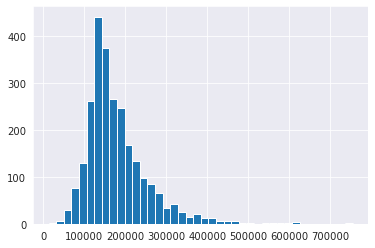

In [97]:
lm2 = LinearRegression()
lm2.fit(df_train_sig, log_target)
residuals2 = target - lm2.predict(df_train_sig)
plt.hist(residuals2,bins=40)

In [98]:
print('R^2 is equal to %.3f' %(lm2.score(df_train_sig, log_target)))
print('RSS is equal to %.3f' %(np.sum(residuals2**2)))
print('The intercept is %.3f' %(lm2.intercept_))

R^2 is equal to 0.932
RSS is equal to 96307224858850.406
The intercept is 12.013


In [99]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_train, target, test_size=0.5, stratify= target, random_state=0)

In [100]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(C=1e8, solver='liblinear')
logistic.fit(X_train, y_train)
print("Train Score", logistic.score(X_train, y_train))
print("Test Score", logistic.score(X_test, y_test))

Train Score 1.0
Test Score 0.014728682170542635


In [101]:
for C in [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]:
    logistic = LogisticRegression(C=C, solver='liblinear')
    logistic.fit(X_train, y_train)
    print("C =", C)
    print("Test Score", logistic.score(X_test, y_test), "\n")

C = 0.0001
Test Score 0.010077519379844961 

C = 0.01
Test Score 0.011627906976744186 

C = 1
Test Score 0.01317829457364341 

C = 100
Test Score 0.012403100775193798 

C = 10000
Test Score 0.014728682170542635 

C = 1000000
Test Score 0.014728682170542635 

C = 100000000
Test Score 0.014728682170542635 



In [102]:
print(y_train.mean())
print(y_test.mean())
y_test

177906.67984496124
178212.56666666668


954    142100
331    135000
671     68400
303    244600
437    143500
        ...  
797    222000
355    336860
97      99000
313    158500
590    142953
Name: SalePrice, Length: 1290, dtype: int64

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

skfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
logistic = LogisticRegression(solver='liblinear')
params = {
    "C": [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]
}

gs = GridSearchCV(logistic, params, cv=skfold)
gs.fit(X_train, y_train)
gs.cv_results_

/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


{'mean_fit_time': array([ 2.81825995,  9.7367487 , 19.21199632, 26.94354618, 29.09799993,
        30.21377718, 29.96516073]),
 'std_fit_time': array([0.02350473, 0.20199037, 0.07815242, 0.15730631, 0.09995162,
        0.02672422, 0.08275187]),
 'mean_score_time': array([0.00773144, 0.00915861, 0.00883555, 0.00749719, 0.00744987,
        0.00734746, 0.00709391]),
 'std_score_time': array([2.77042389e-04, 1.85298920e-03, 1.63817406e-03, 3.21269035e-04,
        9.29832458e-06, 1.91330910e-04, 4.31060791e-04]),
 'param_C': masked_array(data=[0.0001, 0.01, 1, 100, 10000, 1000000, 100000000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.01},
  {'C': 1},
  {'C': 100},
  {'C': 10000},
  {'C': 1000000},
  {'C': 100000000}],
 'split0_test_score': array([0.01550388, 0.01085271, 0.01550388, 0.01550388, 0.00930233,
        0.00930233, 0.00930233]),
 'split1_test_score': array([0.0139534

In [104]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
ridge = Ridge()
lasso = Lasso()
net   = ElasticNet()

In [105]:
ridge.set_params(alpha=1)
ridge.fit(df_train, log_target)
ridge.score(df_train, log_target)

0.9451187613624715

In [106]:
lasso.set_params(alpha=1, normalize=True)
lasso.fit(df_train, target)
lasso.score(df_train, target)

0.9268953226920937

In [107]:
X_train.shape

(1290, 272)

In [108]:
y_train.shape

(1290,)

In [110]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 6

In [ ]:
pipe = Pipeline([ 
    ("standardize", StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])

params = {
    "logit__C": [0.0001, 0.01, 1, 100, 10000]
}

skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

gs = GridSearchCV(pipe, params, scoring="roc_auc", cv=skfold)
gs.fit(X_resampled, y_resampled)

print("Cross-Validation score", gs.best_score_)
print("Train Score", gs.score(X_train, y_train)) # Why is this so different from the cv score?
print("Test Score", gs.score(X_test, y_test))

print(roc_auc_score(y_test, gs.predict_proba(X_test)[:,1]))
confusion_matrix(y_test, gs.predict(X_test))

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

logistic = LogisticRegression(max_iter=500, solver='liblinear', class_weight="balanced")
pipe = Pipeline([ 
    ("standardize", StandardScaler()), ('logit', logistic)])

params = {
    "logit__C": [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]
}

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(pipe, params, scoring="roc_auc", cv=skfold)

start= time.time()
gs.fit(X_train, y_train)
print(time.time() - start)

print("The best parameters are: ", gs.best_params_)
print("The score roc_auc score of the final model: ", gs.score(X_test, y_test))
print("An alternative way to obtain roc_auc: ", roc_auc_score(y_test, gs.predict_proba(X_test)[:,1]))
get_confusion_matrix(gs, X_test, y_test)

/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is

/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-te

/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-te

/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/home/jacquizz/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-te

1073.9006214141846
The best parameters are:  {'logit__C': 0.0001}


ValueError: multiclass format is not supported

In [ ]:
from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(log_target)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df_train, encoded, test_size=0.3, random_state=0)